<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/Antaki2021_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import statsmodels.stats.multitest
from statsmodels.stats.contingency_tables import Table2x2
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

import matplotlib.patches as mpatches
import matplotlib.lines as mlines


SMALL = 20
MEDIUM = 25
BIG = 30
MASSIVE = 60

YLABEL_PAD = 25.0

FIGSIZE_DEFAULT = (26, 16)


LINEWIDTH = 5


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Figure 1

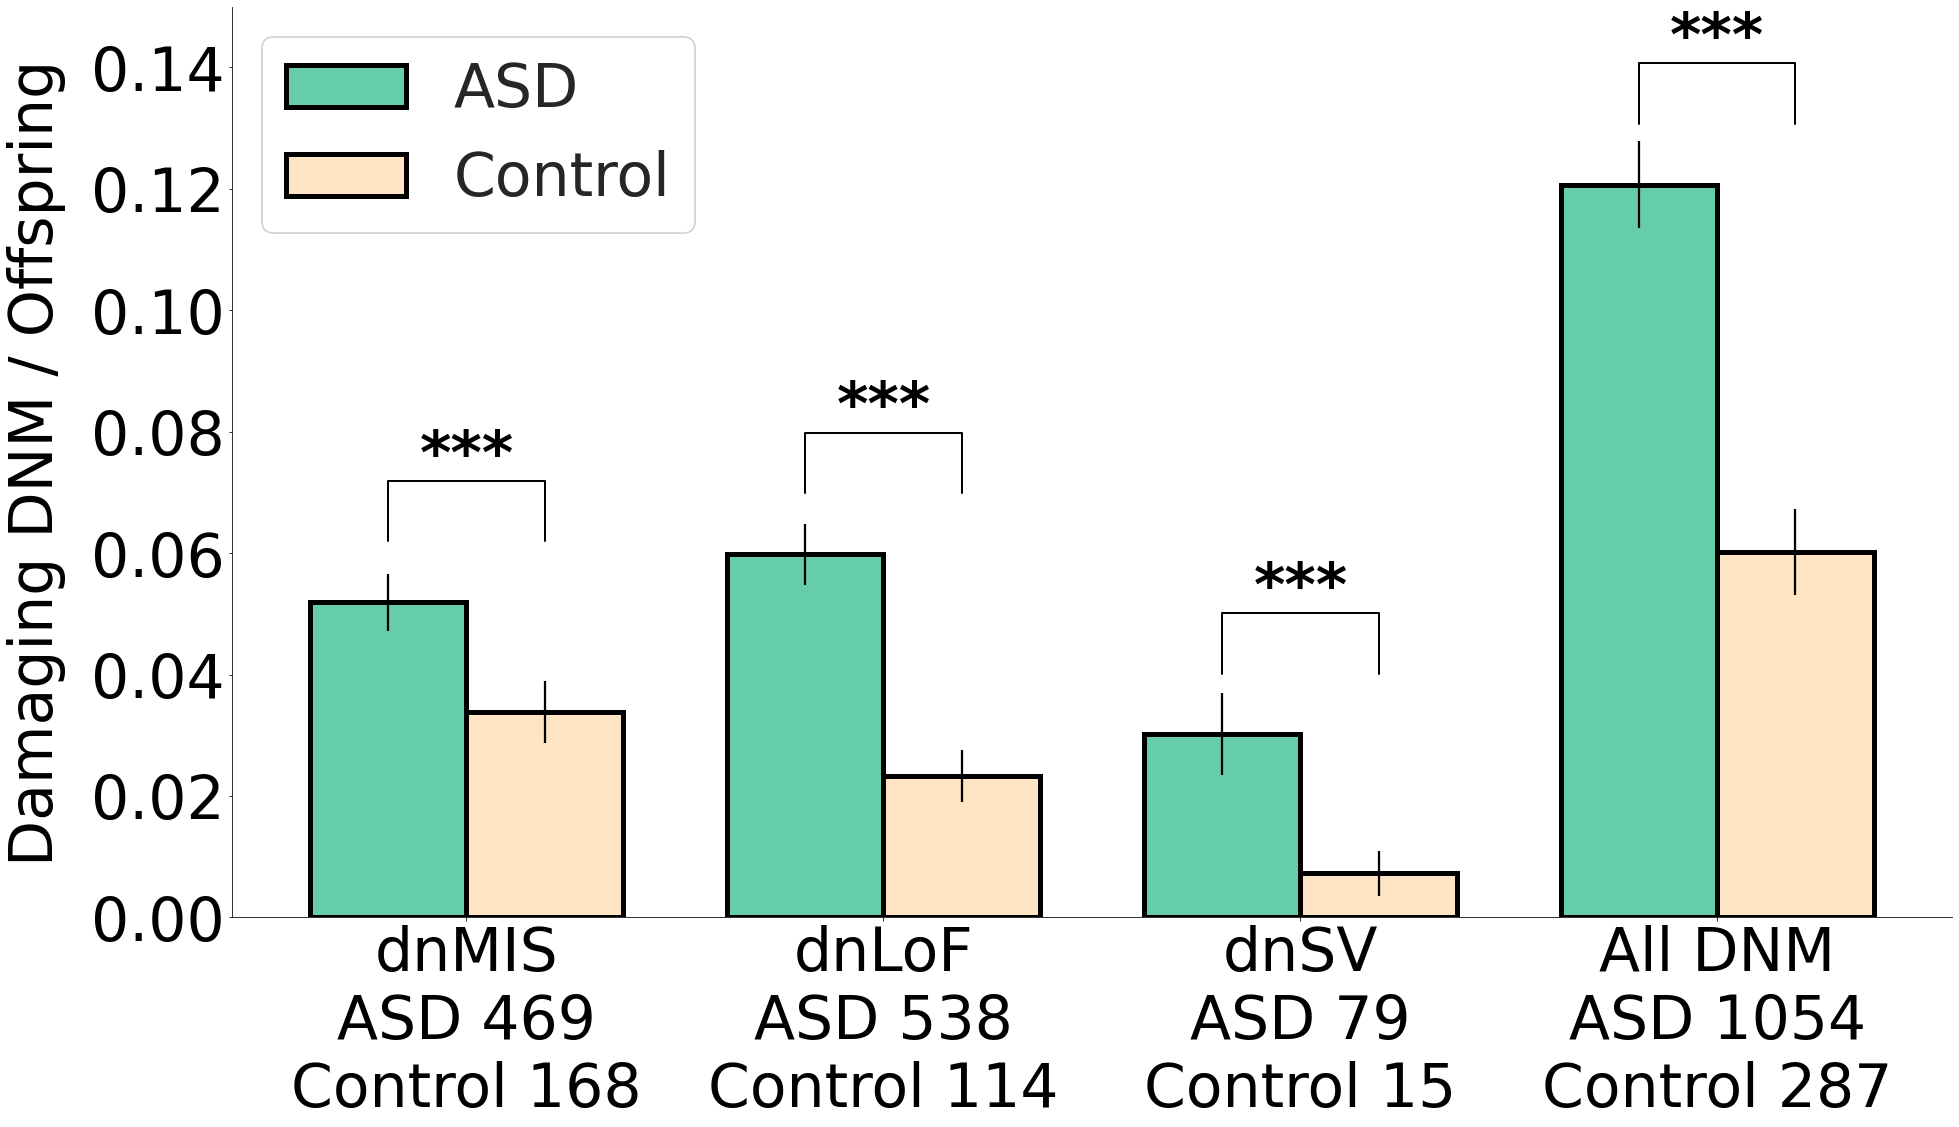

In [ ]:
# Figure 1A
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")


df['dnAll'] = df['dnLOF'] + df['dnMIS'] + df['dnSV'].fillna(0)
cols = ['dnMIS','dnLOF','dnSV','dnAll'] 

def calculate_plot_data(df, col):
  df_tmp = df.dropna(subset=[col])
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])


  # Put relevant data into tuples
  cas_data = (cas_mean, cas_ci, num_cas, cas_sum)
  ctl_data = (ctl_mean, ctl_ci, num_ctl, ctl_sum)
  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  return cas_data, ctl_data, p_val

def get_all_plot_data(df, cols):
  cas_data_arr = []
  ctl_data_arr = []
  p_vals_arr = []
  for col in cols:
    cas_data, ctl_data, p_val = calculate_plot_data(df, col)
    cas_data_arr.append(cas_data)
    ctl_data_arr.append(ctl_data)
    p_vals_arr.append(p_val)
  
  return cas_data_arr, ctl_data_arr, p_vals_arr

def plot_bar(ax, xbar, a, col, wid, lab, buf = 0):
    ax.bar(
        x = [x + buf for x in xbar],
        height = [x[0] for x in a],
        width = wid,
        yerr = [x[1] for x in a],
        color = col,
        label = lab,
        # linewidth = 2,
        linewidth = LINEWIDTH,
        edgecolor = 'k',
    )


def plot_ci2(cas_data_arr, ctl_data_arr, p_vals_arr):
  ymax = 0.15

  # f, ax = plt.subplots(1,1, figsize=(13,8))
  f, ax = plt.subplots(1,1, figsize=FIGSIZE_DEFAULT)
  sns.set_context('talk')
  sns.set_style('ticks')
  # ax.xaxis.grid(alpha=0.5)
  # ax.yaxis.grid(alpha=0.5)

  pal = ['mediumaquamarine', 'bisque']
  width = 0.75
  pheight = 0.01
  xbar = [x for x in range(0, len(cols)*2, 2)]
  px = [x/2 for x in xbar]
  plot_bar(ax, xbar, cas_data_arr, pal[0], width, 'ASD')
  plot_bar(ax, xbar, ctl_data_arr, pal[1], width, 'Control', buf = width)

  leg1 = ax.legend(loc = 2, fontsize = MASSIVE)
  plt.gca().add_artist(leg1)

  sns.despine(ax=ax)

  ax.set_xlabel('')
  ax.set_ylabel('Damaging DNM / Offspring', fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")
  ax.set_xticks([x + (width/2) for x in xbar])
  ax.set_xticklabels(['{}\nASD {}\nControl {}'.format(
      e,
      int(cas_data_arr[i][2]),
      int(ctl_data_arr[i][2]))
      for i,e in enumerate(xlabs)], fontsize = MASSIVE, color = "black")
  ax.set_ylim(0, ymax)
  bufff = 0.01
  py = [cas_data_arr[0][0]+bufff,
        cas_data_arr[1][0]+bufff,
        cas_data_arr[2][0]+bufff,
        cas_data_arr[3][0]+bufff]

  # Add lines (the p-value astericks will be above these branched lines)
  ax.plot([xbar[0], xbar[0], xbar[0] + width, xbar[0] + width], [py[0], py[0] + pheight, py[0] + pheight, py[0]], lw = 2, c = "k")
  ax.plot([xbar[1], xbar[1], xbar[1] + width, xbar[1] + width], [py[1], py[1] + pheight, py[1] + pheight, py[1]], lw = 2, c = "k")
  ax.plot([xbar[2], xbar[2], xbar[2] + width, xbar[2] + width], [py[2], py[2] + pheight, py[2] + pheight, py[2]], lw = 2, c = "k")
  ax.plot([xbar[3], xbar[3], xbar[3] + width, xbar[3] + width], [py[3], py[3] + pheight, py[3] + pheight, py[3]], lw = 2, c = "k")

  # Plot the p-value astericks
  for i, p_val in enumerate(p_vals_arr):
    ybuf = 0.0
    x = xbar[i] + (width/2)
    y = py[i] + pheight + 0.004
    if p_val < 0.05:
      asterick = get_asterick(p_val)
      ax.text(s=asterick, x=x, y=y, ha="center", va="center", fontsize = MASSIVE, color = "black", fontweight = "semibold")
  
  sns.despine(ax=ax)

  ax.set_axisbelow(True)
  f.tight_layout()

  plt.yticks(fontsize = MASSIVE, color = "black")

  # plt.axvline(x = 0, ymin = 0, ymax = 15, alpha = 0.8, color = 'black', linestyle = ':',linewidth=3)


  f.savefig("fig1a.png", bbox_inches = "tight")
  f.savefig("fig1a.svg", bbox_inches = "tight")
  f.savefig("fig1a.pdf", bbox_inches = "tight")
  
  f.show()
  return ax
      
def get_asterick(p_val):
  if p_val < 0.001:  return "***"
  elif p_val < 0.01: return "**"
  elif p_val < 0.05: return "*"
  return



xlabs = ['dnMIS','dnLoF','dnSV','All DNM']
cas_data_arr, ctl_data_arr, p_vals_arr = get_all_plot_data(df, cols)
ax = plot_ci2(cas_data_arr, ctl_data_arr, p_vals_arr)

# For supplementary table
# First, combine dnLOF and dnSV
df["dnLOF_SNV_INDEL_SV"] = df['dnLOF'] + df['dnSV'].fillna(0)
cas_data_arr_dnLOF_SNV_INDEL_SV, ctl_data_arr_dnLOF_SNV_INDEL_SV, p_val_dnLOF_SNV_INDEL_SV = calculate_plot_data(df, "dnLOF_SNV_INDEL_SV")

cas_data_arr.append(cas_data_arr_dnLOF_SNV_INDEL_SV)
ctl_data_arr.append(ctl_data_arr_dnLOF_SNV_INDEL_SV)
p_vals_arr.append(p_val_dnLOF_SNV_INDEL_SV)


In [ ]:
# Make SupplementaryTable2 Results Fig1A
# Rows are in order of xlabs ['dnMIS','dnLoF','dnSV','All DNM']

df_p_vals = pd.DataFrame(p_vals_arr, columns = ["P-value"])

df_supptable2_fig1a_cas = pd.DataFrame(cas_data_arr, columns = ["ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations"])
df_supptable2_fig1a_ctl = pd.DataFrame(ctl_data_arr, columns = ["Control Mean", "Control 95% CI", "Control Samples", "Control Mutations"])
df_supptable2_fig1a_dnm_type = pd.DataFrame(["De Novo Missense", "De Novo SNV/INDEL LoF", "De Novo SV LoF", "De Novo All", "De Novo LoF"], columns = ["DNMs"])

df_supptable2_fig1a = pd.concat([df_supptable2_fig1a_dnm_type, df_supptable2_fig1a_cas, df_supptable2_fig1a_ctl, df_p_vals], axis = "columns")
df_supptable2_fig1a = df_supptable2_fig1a.reindex([1, 0, 2, 4, 3])

df_supptable2_fig1a.to_csv("SupplementaryTable2.Results_Fig1A.csv", index = False)

In [ ]:
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")


df_reach = df[df['Cohort'] == "REACH"]
print("REACH DNLOF SUM: " + str(sum(df_reach["dnLOF"])))
print("REACH DNMIS SUM: " + str(sum(df_reach["dnMIS"])))

df_ssc = df[df['Cohort'] == "SSC"]
print("SSC DNLOF SUM: " + str(sum(df_ssc["dnLOF"])))
print("SSC DNMIS SUM: " + str(sum(df_ssc["dnMIS"])))

df_spark = df[df['Cohort'] == "SPARK"]
df_spark_dnmis = df_spark.dropna(subset = ["dnMIS"])
df_spark_dnlof = df_spark.dropna(subset = ["dnLOF"])
print("SPARK DNLOF SUM: " + str(sum(df_spark_dnlof["dnLOF"])))
print("SPARK DNMIS SUM: " + str(sum(df_spark_dnmis["dnMIS"])))

print(30+256+391)
print(538+114)

REACH DNLOF SUM: 30.0
REACH DNMIS SUM: 22.0
SSC DNLOF SUM: 256.0
SSC DNMIS SUM: 196.0
SPARK DNLOF SUM: 391.0
SPARK DNMIS SUM: 439.0
677
652


In [ ]:
sum(df_reach["dnLOF"])

30.0

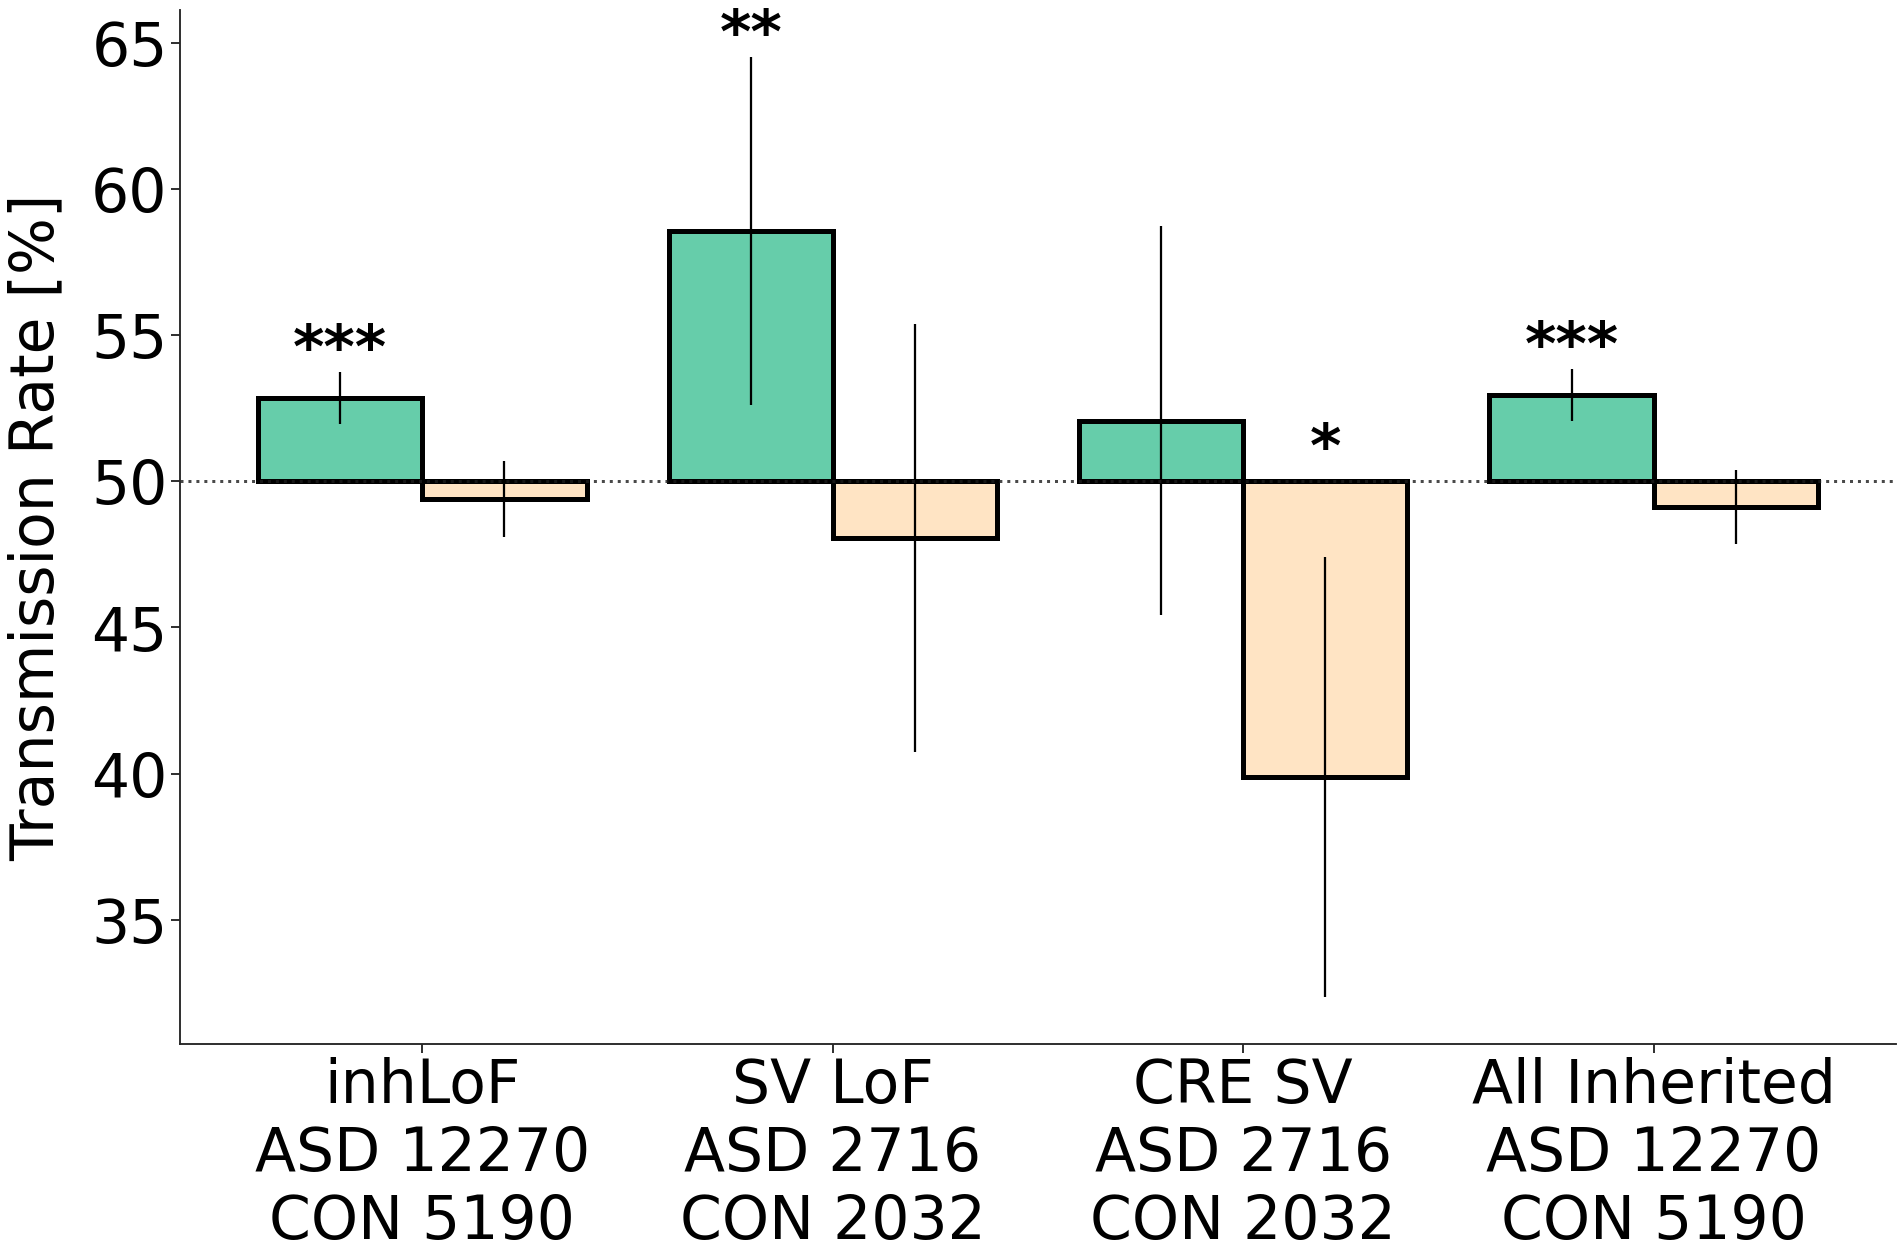

In [ ]:
# Figure 1B

# Functions
def add_sig_lines(ax, x1, x2, y, h):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw = 2, c = 'k')

def format_p(pv):
    fmt = ''
    if pv < 0.05: fmt='*'
    if pv < 0.01: fmt='**'
    if pv < 0.001: fmt='***'
    return fmt

def add_tbar(df, ax, x, width = 0.75, pbuf = 0.7):
    pal = ['mediumaquamarine','bisque']
    ax.bar(
        x = x,
        height = (df['aff_trate'] - 0.5)*100,
        width = width,
        yerr = df['aff_tci']*100,
        color = pal[0],
        edgecolor = 'k',
        # linewidth = 2,
        linewidth = LINEWIDTH,
    )
    ap = df['aff_tpval'].values[0]
    if ap <= 0.05:
        ax.text(
            x = x,
            y = ((df['aff_trate'].values[0] - 0.5)*100) + (df['aff_tci'].values[0]*100) + pbuf,
            s = '{}'.format(format_p(ap)),
            ha = 'center',
            va = 'center',
            fontsize = MASSIVE,
            color = "black",
            fontweight = "semibold"
        )

    ax.bar(
        x = x + width,
        height = (df['con_trate'] - 0.5)*100,
        width = width,
        yerr = df['con_tci']*100,
        color = pal[1],
        edgecolor = 'k',
        # linewidth = 2,
        linewidth = LINEWIDTH,
    
    )

    cp = df['con_tpval'].values[0]
    if cp <= 0.05:
        ax.text(
            x = x + width,
            # y = ((df['con_trate'].values[0] - 0.5)*100) - (df['con_tci'].values[0]*100) - pbuf,
            y = ((df['con_trate'].values[0] - 0.5)*100) - (df['con_tci'].values[0]*100) + 18 + pbuf,
            s = '{}'.format(format_p(cp)),
            ha = 'center',
            va = 'center',
            fontsize = MASSIVE,
            color = "black",
            fontweight = "semibold"
        )
    chi = df['tot_chisq'].values[0]
    pheight = 2

df = pd.read_csv("all_t1burden_tdt_results.tsv",sep="\t")
groups = ['snv_indel_lof', 'sv_lof', 'cresv', 'combined_lof_cre']
df = df[df["group_id"].isin(groups)]

# Plotting
ind = []
for x in range(1, len(groups) + 1):
  ind.append(x)

sns.set_context("talk")
# f, ax = plt.subplots(1, 1, figsize = (13,8))
f, ax = plt.subplots(1,1, figsize=FIGSIZE_DEFAULT)


width = 2/5
for i,g in enumerate(groups):
  add_tbar(df.loc[df["group_id"] == g], ax, ind[i], width)

ax.set_ylabel('Transmission Rate [%]', fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")

ytick_step = 5
rng = 20
ax.set_yticks([x for x in range(-1*rng, rng + ytick_step, ytick_step)])
ax.set_yticklabels([x for x in range(50 - rng, 50 + rng + ytick_step, ytick_step)])
ax.set_xticks([x + (width/2) for x in ind])

xlabs = ['inhLoF','SV LoF','CRE SV','All Inherited']
xtix = [
    '{}\nASD {}\nCON {}'.format(
        xlabs[i],
        df.loc[df['group_id'] == g]['n_asd_tot'].values[0],
        df.loc[df['group_id'] == g]['n_con_tot'].values[0],
    )
    for i,g in enumerate(groups)
]

xmin, xmax = ax.set_xlim()
ax.hlines(y = 0, xmin = xmin, xmax = xmax, alpha = 0.8, color = '#1c1c1c', linestyle = ':',linewidth=3)
ax.set_xticklabels(xtix)

pal = ['mediumaquamarine', 'bisque']
leg = [
    Patch(facecolor = pal[0], edgecolor = 'k', label = 'ASD'),
    Patch(facecolor = pal[1], edgecolor = 'k', label = 'Control')
]

# ax.legend(handles = leg, loc = 4, fontsize = MASSIVE)
# ax.xaxis.grid(alpha = 0.5)
# ax.yaxis.grid(alpha = 0.5)
ax.set_axisbelow(True)
sns.despine(ax = ax)
f.tight_layout()

plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")


f.savefig("fig1b.png", bbox_inches = "tight")
f.savefig("fig1b.pdf", bbox_inches = "tight")
f.savefig("fig1b.svg", bbox_inches = "tight")


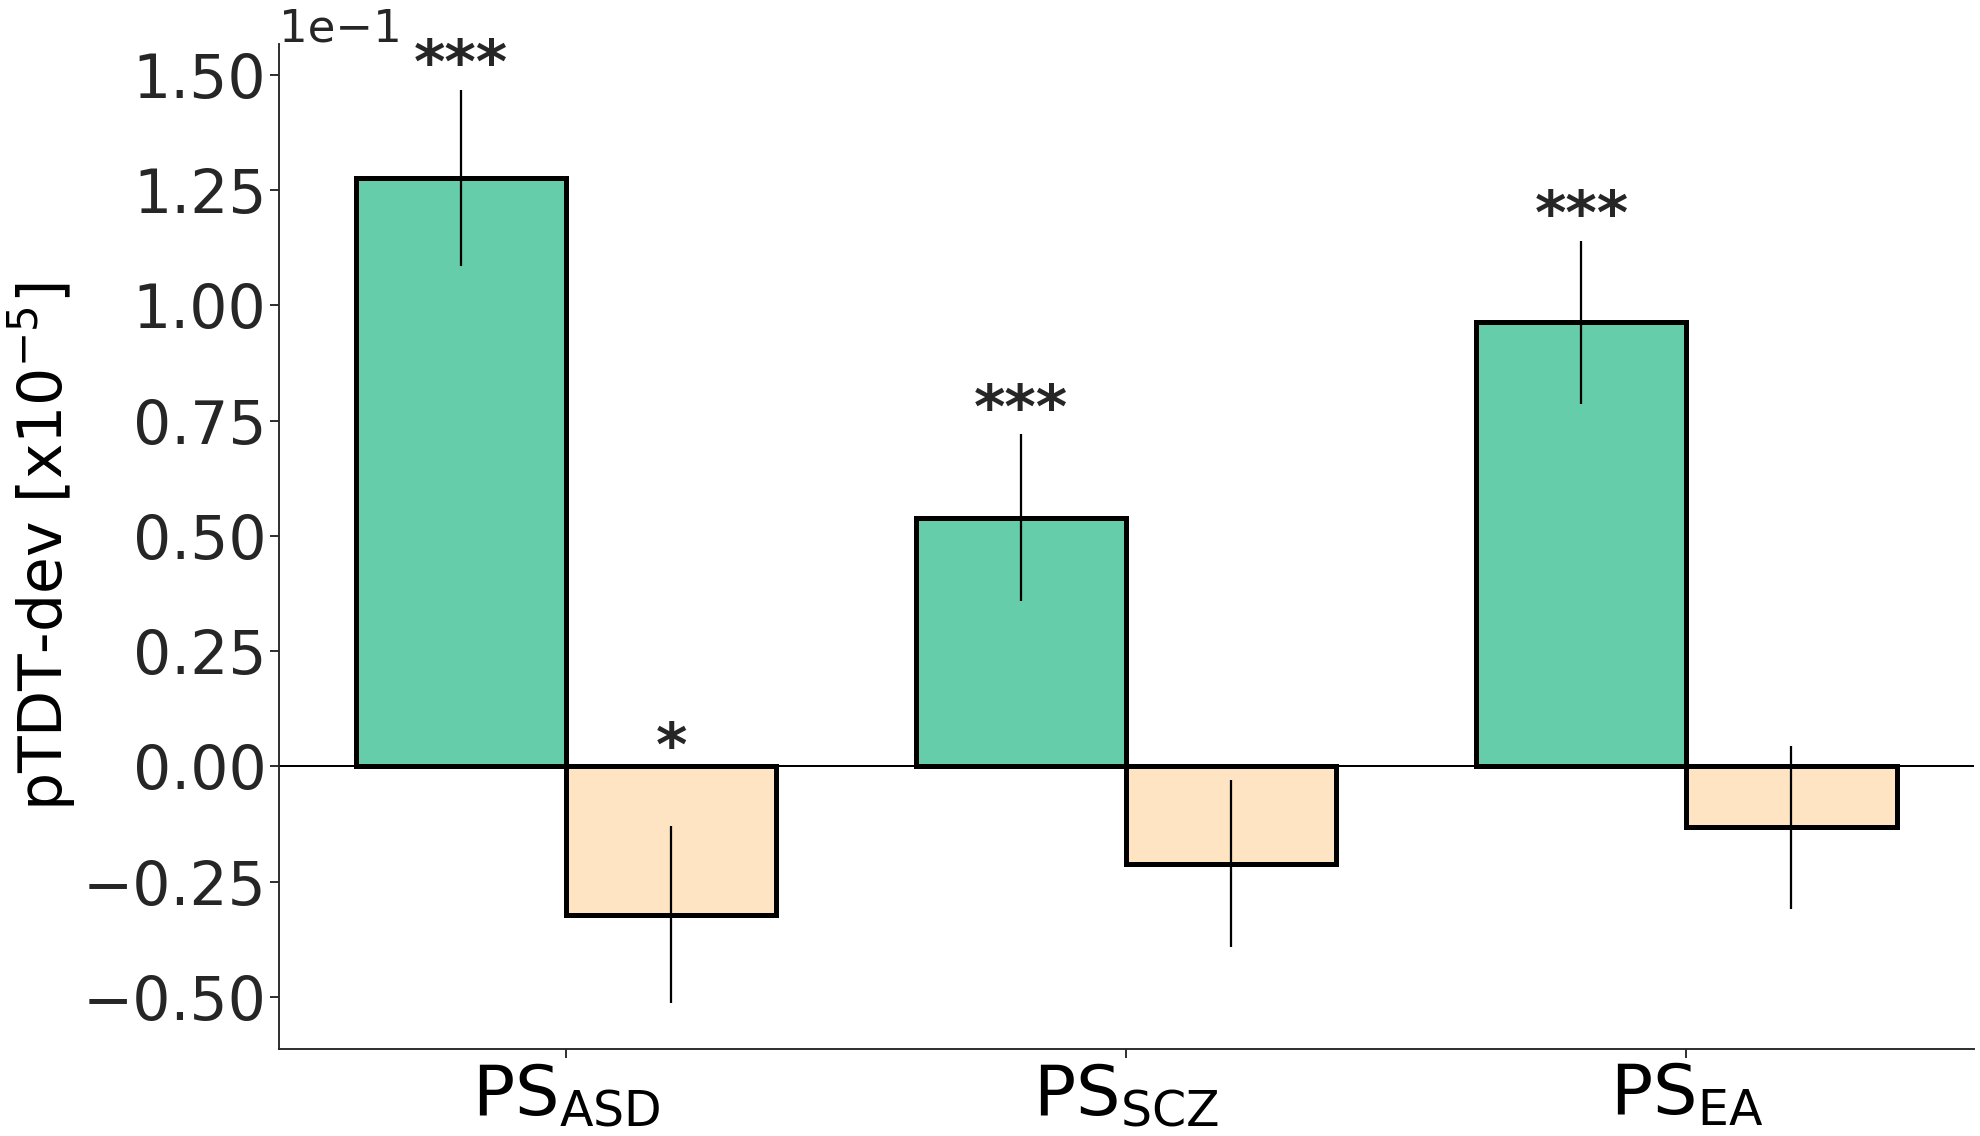

In [ ]:
# Figure 1C

# Figure 1C functions

def ttest(a,popmean=0):
    return scipy.stats.ttest_1samp(a,popmean=popmean)[1]

def paired_ttest(a,b):
    return scipy.stats.ttest_ind(a,b)[1]

def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def return_plot_data(df,c):
    m,ci = mean_ci(df[c])
    return( (m,ci,len(set(df['IID'])),ttest(df[c]) ) )

def calc_plot_data(df,cols):
    asd,con,pvs=[],[],[]
    # foreach column
    for c in cols:
        cas = df.loc[df['Phenotype']==1].dropna(subset=[c])
        ctl = df.loc[df['Phenotype']!=1].dropna(subset=[c])

        # mean, ci95, n-samples, pvalue, paired-t-test
        pvs.append(paired_ttest(cas[c],ctl[c]))
        asd.append(return_plot_data(cas,c))
        con.append(return_plot_data(ctl,c))
    
    return asd,con,pvs

def plot_bar(ax,xbar,a,col,wid,lab,buf=0):
    ax.bar(
        x=[x+buf for x in xbar],
        height=[x[0] for x in a],
        width=wid,
        yerr=[ x[1]  for x in a],
        color=col,
        label=lab,
        edgecolor='k',
        linewidth=2,
    )
    pbuf=0.5e-06
    for i,x in enumerate(xbar):
        if a[i][-1]>0.05: continue
        y = a[i][0]+a[i][1]+pbuf
        if 'Con' in lab:y=a[i][0]-a[i][1]-pbuf
        ax.text(
            x=x+buf,
            y=y,
            s=format_p(a[i][-1]),
            ha='center', va='center'
        )
    
def format_p(pv):
    fmt = ''
    if pv<0.05: fmt='*'
    if pv<0.01: fmt='**'
    if pv<0.001: fmt='***'
    return fmt

def add_sig_lines(ax,x1,x2,y,h):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')

def plot_ci(ax,df,cols,xlabs):
    asd,con,pvs = calc_plot_data(df,cols)
    pal = ['mediumaquamarine','bisque']
    width=0.75
    xbar = [x for x in range(0,len(cols)*2,2)]
    plot_bar(ax,xbar,asd,pal[0],width,'ASD : {}'.format(asd[0][2]))
    plot_bar(ax,xbar,con,pal[1],width,'Control : {}'.format(con[0][2]),buf=width)

    # ax.legend(loc=4)
    ax.set_xlabel('')
    ax.set_ylabel('Child - Midparent PRS')
    
    # x ticks
    ax.set_xticks(np.array(xbar)+width/2)
    ax.set_xticklabels(
        ['{LAB}'.format(LAB=e,ASD=asd[i][2],CON=con[i][2]) for i,e in enumerate(xlabs)],
        fontsize=MEDIUM
    )
    ax.xaxis.grid(alpha=0.5)
    ax.yaxis.grid(alpha=0.5)
    pheight=0.1e-05
    pbuf=0.1e-05
    for i,pv in enumerate(pvs):
        x = xbar[i]
        y = asd[i][0]+asd[i][1]+pbuf
        print(pv)
        if 1 > 2:
        #if pv<=0.05:
            add_sig_lines(
                ax,
                x,
                x+width,
                y,
                pheight
            )
            ax.text(
                s='P={:.2e}'.format(pv),
                x=x+(width/2),
                y=y+(pbuf*1.5),
                ha='center',
                va='center',
            )    


# Figure 1C
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")


df = df[df["EUR Ancestry"] == 1]
cols = ['pTDT ASD Dev','pTDT SCZ Dev', 'pTDT EA Dev']


def calculate_plot_data(df, col):
  df_tmp = df.dropna(subset=[col])
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]


  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = cas[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])

  # Put relevant data into tuples
  cas_data = (cas_mean, cas_ci, num_cas, cas_sum)
  ctl_data = (ctl_mean, ctl_ci, num_ctl, ctl_sum)
  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  # 1 sample ttest
  popmean = 0
  cas_p_val_1s = scipy.stats.ttest_1samp(cas[col], popmean = popmean)[1]
  ctl_p_val_1s = scipy.stats.ttest_1samp(ctl[col], popmean = popmean)[1]
  p_val_1s = (cas_p_val_1s, ctl_p_val_1s)

  return cas_data, ctl_data, p_val, p_val_1s


def get_all_plot_data(df, cols):
  cas_data_arr = []
  ctl_data_arr = []
  p_vals_arr = []
  p_vals_1s_arr = []
  for col in cols:
    cas_data, ctl_data, p_val, p_vals_1s = calculate_plot_data(df, col)
    cas_data_arr.append(cas_data)
    ctl_data_arr.append(ctl_data)
    p_vals_arr.append(p_val)
    p_vals_1s_arr.append(p_vals_1s)
  
  return cas_data_arr, ctl_data_arr, p_vals_arr, p_vals_1s_arr

def get_asterick(p_val):
  if p_val < 0.001:  return "***"
  elif p_val < 0.01: return "**"
  elif p_val < 0.05: return "*"
  return



cas_data_arr, ctl_data_arr, p_vals_arr, p_vals_1s_arr = get_all_plot_data(df, cols)


# Plotting
def format_p(pval):
    fmt = ''
    if pval < 0.05: fmt = '*'
    if pval < 0.01: fmt = '**'
    if pval < 0.001: fmt = '***'
    return fmt


def plot_bar(p_vals_1s, ax, xbar, arr, pal, width, label, buf = 0):
    ax.bar(
        x = [x + buf for x in xbar],
        height = [x[0] for x in arr],
        width = width,
        yerr = [x[1] for x in arr],
        color = pal,
        label = label,
        edgecolor = 'k',
        linewidth = 5,
    )
    # p_value astericks (for each individual bar)
    pbuf = 0.5e-06
    pbuf = 0.5e-06 + 0.5e-02
    for i, x in enumerate(xbar):
        if p_vals_1s[i] > 0.05: continue
        y = arr[i][0] + arr[i][1] + pbuf
        if 'Con' in label: y = arr[i][0] - arr[i][1] + pbuf + 0.5e-01 # (- pbuf before)
        ax.text(
            x = x + buf,
            y = y,
            s = format_p(p_vals_1s[i]),
            ha='center', va='center',
            fontsize = MASSIVE,
            fontweight = "semibold"
        )



def plot_ci2(cas_data_arr, ctl_data_arr, p_vals_arr_1s, cols, xlabs, p_vals_arr):
  ymax = 0.15

  params = {'mathtext.default': 'regular' }   
  plt.rcParams.update(params)


  # f, ax = plt.subplots(1,1,figsize=(13,8))
  f, ax = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)
  # f, ax = plt.subplots(1,1,figsize=(13*1.5, 8*1.5))


  sns.set_context('talk')
  sns.set_style('ticks')
  # ax.xaxis.grid(alpha=0.5)
  # ax.yaxis.grid(alpha=0.5)


  pal = ['mediumaquamarine', 'bisque']
  width = 0.75
  pheight = 0.01
  xbar = [x for x in range(0, len(cols)*2, 2)]
  px = [x/2 for x in xbar]

  # Unpack the tuple of p-values
  p_vals_arr_1s_unpack = [i for sublist in p_vals_arr_1s for i in sublist]
  cas_p_vals = p_vals_arr_1s_unpack[::2]   # cas p-values
  ctl_p_vals = p_vals_arr_1s_unpack[1::2]  # con p-values 

  plot_bar(cas_p_vals, ax, xbar, cas_data_arr, pal[0], width, 'ASD')
  plot_bar(ctl_p_vals, ax, xbar, ctl_data_arr, pal[1], width, 'Control', buf = width) # buf is width before

  sns.despine(ax = ax)

  # ax.legend(loc = 3, fontsize = SMALL)
  ax.set_xlabel('')
  ax.set_ylabel('pTDT-dev [x10$^{-5}$]', fontsize = MASSIVE, color = "black")

  ax.set_xticks(np.array(xbar)+width/2)
  ax.set_xticklabels(['{LAB}'.format(LAB = e, ASD = cas_data_arr[i][2], CON = ctl_data_arr[i][2]) for i,e in enumerate(xlabs)], fontsize=MASSIVE)

  # Plot the p-value comparison lines/astericks at the top
  pheight = 0.1e-05
  pbuf = 0.1e-05
  pbuf = 0.1e-05 + 0.8e-02

  # for i, p_val in enumerate(p_vals_arr):
  #   x = xbar[i]
  #   y = cas_data_arr[i][0] + cas_data_arr[i][1] + pbuf
  #   if p_val < 0.05:
  #     asterick = get_asterick(p_val)
  #     ax.text(s = 'P = {:.2e}'.format(p_val), x = x + (width/2) + .2, y = y + (pbuf*1.5), ha="center", va="center", fontsize = MASSIVE)
  
  ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
  ax.yaxis.get_offset_text().set_fontsize(BIG + 15)


  sns.despine(ax=ax)
  ax.set_axisbelow(True)

  ax.axhline(linewidth=2, color='black')

  f.tight_layout()

  plt.yticks(fontsize = MASSIVE)
  plt.xticks(fontsize = MASSIVE + 10, color = "black")

  ax.grid(False)

  # f.set_size_inches(8, 6)
  f.savefig("fig1c.png", bbox_inches = "tight")
  f.savefig("fig1c.svg", bbox_inches = "tight")
  f.savefig("fig1c.pdf", bbox_inches = "tight")

  f.show()
  return ax


xlabs = ['$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$']
ax = plot_ci2(cas_data_arr, ctl_data_arr, p_vals_1s_arr, cols, xlabs, p_vals_arr)

In [ ]:
print(cas_data_arr)

print(ctl_data_arr)

[(0.12761476473910555, 0.019140329781286016, 2969, 669.5946705860867), (0.05391202180605553, 0.018114572755281704, 2777, 282.87637841637337), (0.09629085996202258, 0.017733463921975483, 2921, 505.23814222073247)]
[(-0.03215817412809562, 0.01914350147831507, 1476, -98.21106378720404), (-0.021096013397608967, 0.01811757447663379, 1477, -64.42722491629779), (-0.013200387478208965, 0.017736402490719016, 1520, -40.31398335845018)]


In [ ]:
# Make supplementary table 4 from Figure 1C

# Get number of samples (should be all the same for each type of score)
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210709.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")

df = df[df["EUR Ancestry"] == 1]
# ASD
df_asd = df.dropna(subset=["pTDT ASD Dev"])
df_asd_cas = df_asd[df_asd["Phenotype"] == 1]
df_asd_ctl = df_asd[df_asd["Phenotype"] == 0]
df_asd_cas_num = len(df_asd_cas)
df_asd_ctl_num = len(df_asd_ctl)
# SCZ
df_scz = df.dropna(subset=["pTDT SCZ Dev"])
df_scz_cas = df_scz[df_scz["Phenotype"] == 1]
df_scz_ctl = df_scz[df_scz["Phenotype"] == 0]
df_scz_cas_num = len(df_scz_cas)
df_scz_ctl_num = len(df_scz_ctl)
# EA
df_ea = df.dropna(subset=["pTDT EA Dev"])
df_ea_cas = df_ea[df_ea["Phenotype"] == 1]
df_ea_ctl = df_ea[df_ea["Phenotype"] == 0]
df_ea_cas_num = len(df_ea_cas)
df_ea_ctl_num = len(df_ea_ctl)

# cols = ['pTDT ASD Dev','pTDT SCZ Dev', 'pTDT EA Dev']
# cas_data_arr, ctl_data_arr, p_vals_arr, p_vals_1s_arr
# cas_data_arr contains (cas_mean, cas_ci, num_cas, cas_sum)
# ctl_data_arr contains (ctl_mean, ctl_ci, num_ctl, ctl_sum)
# p_vals_arr contains between-group (control vs. case) t-test p-values
# p_vals_1s_arr contains ((case_p_val_asd, ctl_p_val_asd), (case_p_val_scz, ctl_p_val_scz), (case_p_val_ea, ctl_p_val_ea))

# Get means and confidence intervals from previously stored arrays
cas_mean_asd = cas_data_arr[0][0]
cas_ci_asd = cas_data_arr[0][1]
cas_mean_scz = cas_data_arr[1][0]
cas_ci_scz = cas_data_arr[1][1]
cas_mean_ea = cas_data_arr[2][0]
cas_ci_ea = cas_data_arr[2][1]

ctl_mean_asd = ctl_data_arr[0][0]
ctl_ci_asd = ctl_data_arr[0][1]
ctl_mean_scz = ctl_data_arr[1][0]
ctl_ci_scz = ctl_data_arr[1][1]
ctl_mean_ea = ctl_data_arr[2][0]
ctl_ci_ea = ctl_data_arr[2][1]

# Get p-values (from single group t-tests)
cas_p_asd, cas_p_scz, cas_p_ea = p_vals_1s_arr[0][0], p_vals_1s_arr[1][0], p_vals_1s_arr[2][0]
ctl_p_asd, ctl_p_scz, ctl_p_ea = p_vals_1s_arr[0][1], p_vals_1s_arr[1][1], p_vals_1s_arr[2][1]

# Make new tuples
asd_row = ("PS ASD Child-Midparent", cas_mean_asd, cas_ci_asd, df_asd_cas_num, cas_p_asd, ctl_mean_asd, ctl_ci_asd, df_asd_ctl_num, ctl_p_asd)
scz_row = ("PS SCZ Child-Midparent", cas_mean_scz, cas_ci_scz, df_scz_cas_num, cas_p_scz, ctl_mean_scz, ctl_ci_scz, df_scz_ctl_num, ctl_p_scz)
ea_row  = ("PS EA Child-Midparent",  cas_mean_ea,  cas_ci_ea,  df_ea_cas_num,  cas_p_ea,  ctl_mean_ea,  ctl_ci_ea,  df_ea_ctl_num,  ctl_p_ea)

rows = [asd_row, scz_row, ea_row]

df_st4 = pd.DataFrame(rows, columns =['PS', 'ASD Mean', 'ASD 95% CI', 'ASD Samples', 'ASD P-value', 'Control Mean', 'Control 95% CI', 'Control Samples', 'Control P-value'])

df_st4.to_csv("SupplementaryTable4.pTDT_Results.csv", index=False)


# Figure 2

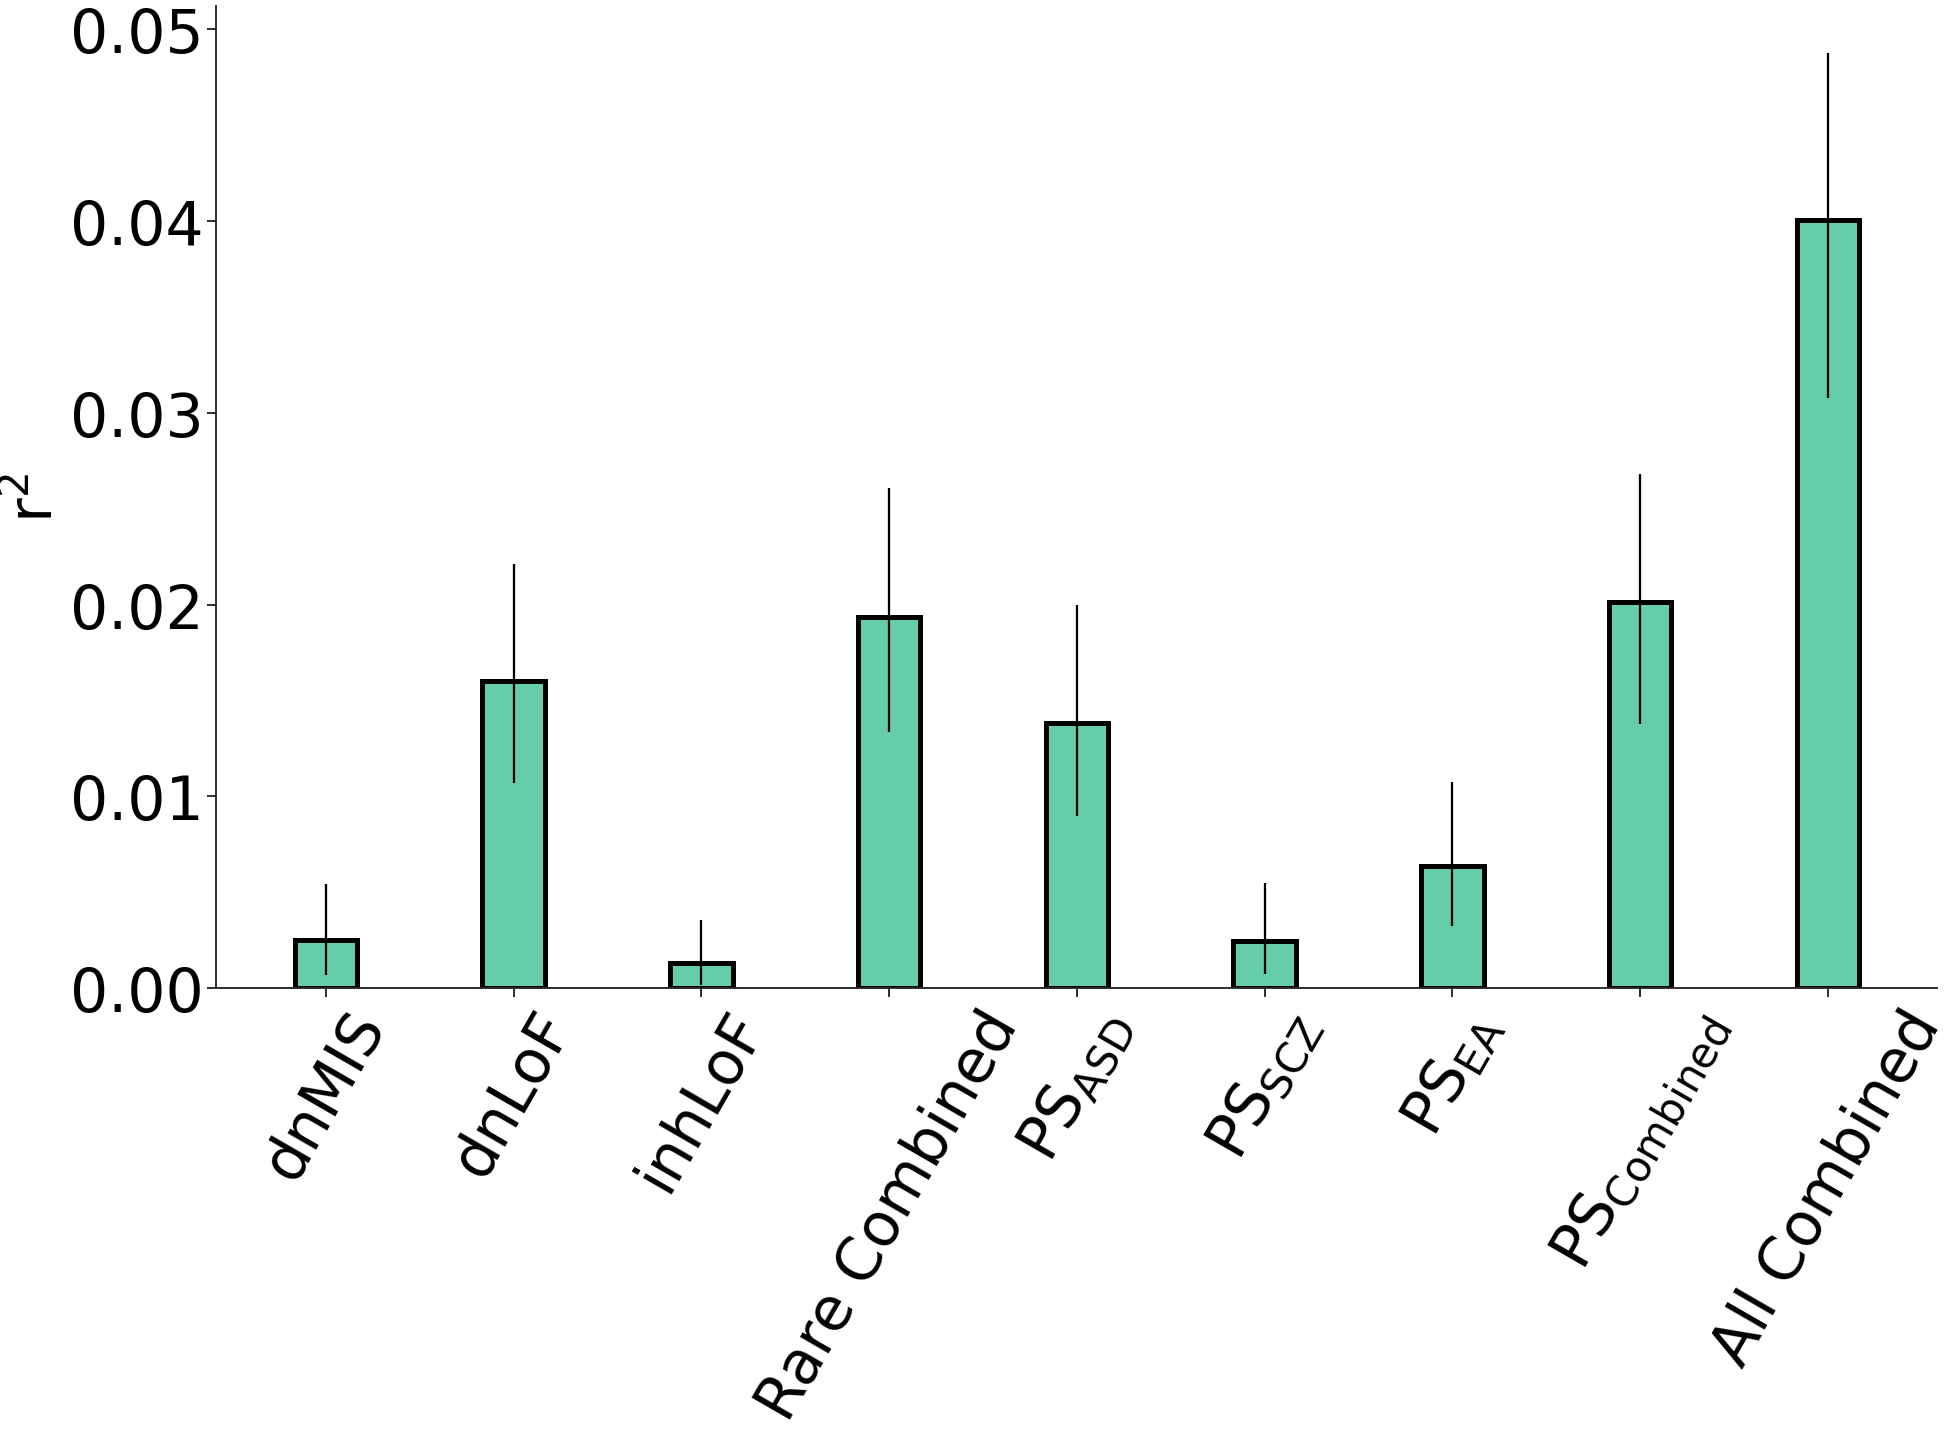

In [ ]:
# Figure 2A
# Functions
def format_p(pv):
    fmt = ''
    if pv < 0.05: fmt='*'
    if pv < 0.01: fmt='**'
    if pv < 0.001: fmt='***'
    return fmt

# Data analysis
# df = pd.read_csv("R2_estimates.bootstrap-test-convergence.csv", sep=",")
# df = pd.read_csv("/content/R2_estimates.tmp.csv", sep=",")
df = pd.read_csv("/content/r2_table.csv", sep=",")



# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand=True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci']= df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]


# Rename columns for R2_type (for now?)
df["R2_type"] = df["R2_type"].replace({
    "combined": "all_combined",
    "prs": "prs_combined",
    "rare": "rare_combined",
    "ptdt.asd.dev": "prs_asd_load",
    "ptdt.ea.dev": "prs_ea_load",
    "ptdt.scz.dev": "prs_scz_load",
    "dnMIS": "snv_dn_mis",
    "dnLOF": "snv_dn_lof",
    "inhLOF": "snv_lof_t"
})


# Plotting
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
sns.set_context('talk')
pal = ['mediumaquamarine','dodgerblue','silver']

f, ax = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

risk = [
    'snv_dn_mis','snv_dn_lof',
    'snv_lof_t',
    'rare_combined',
    'prs_asd_load','prs_scz_load','prs_ea_load',
    'prs_combined',
    'all_combined'
]

ybar = np.array([x for x in range(0, len(risk))])


r2, err, pv = [], [], []
ci_lower, ci_upper = [], []
ci_lower_upper = []
for r in risk:
  r2.append(df[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['nagelkerke_R2_val'].values[0])
  err.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['ci'].values[0])
  pv.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['lr_p_val'].values[0])
  ci_lower.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['ci_lower_adj'].values[0])
  ci_upper.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['ci_upper_adj'].values[0])


ci_lower_upper = (ci_lower, ci_upper)

width = 1/3

ax.bar(
    x = ybar,
    height = r2,
    width = width,
    # yerr = err,
    yerr = ci_lower_upper,
    color = pal[0],
    edgecolor = "k",
    # linewidth = 2,
    linewidth = LINEWIDTH,
)

# p-values
# pbuf = 0.002
# buff = 0
# for i, p in enumerate(pv):
#   ax.text(
#       y = r2[i] + err[i] + pbuf,
#       # y = r2[i] + pbuf,
#       x = ybar[i] + buff,
#       s = format_p(p),
#       ha = 'center',
#       va = 'center',
#       weight = 'bold',
#       fontsize = MASSIVE
#       )

xlabs = [
    'dnMIS','dnLoF','inhLoF','Rare Combined',
    '$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$',
    '$PS_{Combined}$',
    'All Combined'
]

ax.set_ylabel('r$^2$', fontsize = MASSIVE, color = "black")
ax.set_xlabel('')
ax.set_xticks([x for x in ybar])
ax.set_xticklabels(xlabs, rotation = 60)
ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()

plt.yticks(fontsize = MASSIVE, color = "black")
# plt.xticks(fontsize = SMALL + 5)
plt.xticks(fontsize = MASSIVE, color = "black")

# ax.grid(False)
# sns.despine(ax=ax)
# ax.set_facecolor('white')

f.savefig("fig2a.png", bbox_inches = "tight")
f.savefig("fig2a.svg", bbox_inches = "tight")
f.savefig("fig2a.pdf", bbox_inches = "tight")

# Add more spacing between bars?

In [ ]:
# Make supplementary table 5
# df = pd.read_csv("R2_estimates.bootstrap-test-convergence.csv", sep=",")
df = pd.read_csv("r2_table.csv", sep=",")


# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand=True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})

df = df.rename(columns = {"text": "Model",
                          "nagelkerke_R2_val": "r2",
                          "ci_lower": "Lower 95% CI",
                          "ci_upper": "Upper 95% CI",
                          "lr_p_val": "P-Value",
                          "ste": "Standard Error"})

df = df[df["Sex"] == "Female & Male"]
df = df[["Model", "r2", "P-Value", "Standard Error", "Lower 95% CI", "Upper 95% CI"]]


df['Model'].replace({'combined_both': 'All Combined', 
                     'prs_both': 'PS Combined', 
                     'rare_both': 'Rare Combined', 
                     'ptdt.asd.dev_both': 'PS ASD',
                     'ptdt.ea.dev_both': 'PS EA',
                     'ptdt.scz.dev_both': 'PS SCZ',
                     'dnMIS_both': 'dnMIS',
                     'dnLOF_both': 'dnLoF',
                     'inhLOF_both': 'inhLoF'}, inplace = True)

df = df.reset_index(drop=True)
df = df.reindex([0,1,2,3,4,5,7,6,8])

cols = ["Model", "r2", "Lower 95% CI", "Upper 95% CI", "P-Value", "Standard Error"]
df = df[cols]

df.to_csv("SupplementaryTable5.Results_Fig2a.csv", index=False)


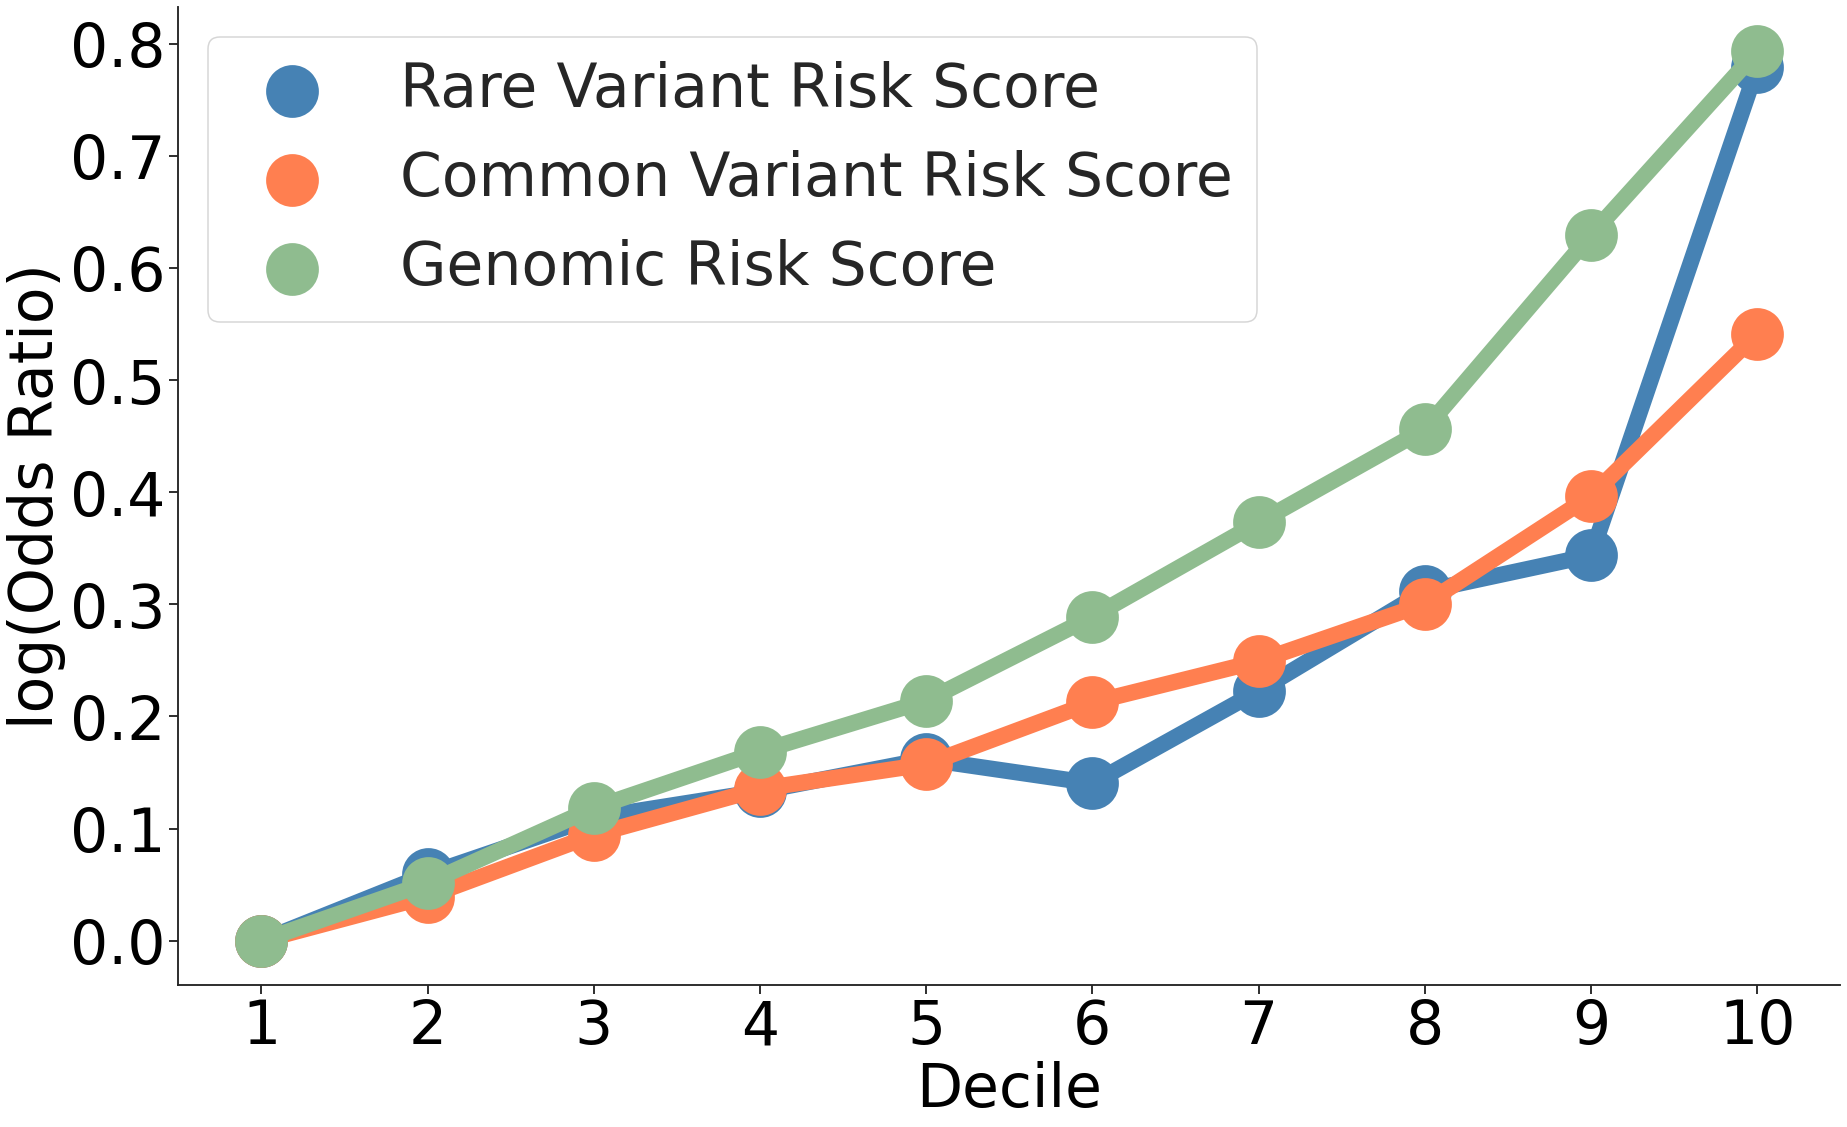

In [ ]:
# Figure 2B
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")


df = df.dropna(subset=["GRS", "PRS", "RVRS"])


df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})

def response_or(df):
  """
                    asd   |  con
      at thres    | a     |   b
      below thres | c     |   d
      
      OR = a/c / b/d
  """
  results = []
  for x in range(1,11):
    a = len(df[(df["Phenotype"] == "ASD")     & (df["response_deciles"] >= x)])
    b = len(df[(df["Phenotype"] == "Control") & (df["response_deciles"] >= x)])
    c = len(df[df["Phenotype"] == "ASD"])
    d = len(df[df["Phenotype"] == "Control"])

    # Make a 2x2 contigency table
    table = Table2x2([[a,b], [c,d]], shift_zeros=True)
    c_, p, dof, expected = chi2_contingency([[a,b],[c,d]])
    lo,hi = table.oddsratio_confint()
    results.append([x, table.oddsratio, lo, hi, p, a, b, c, d])
  return results

df["response_deciles"] = pd.qcut(df["GRS"], q = 10, labels = [x for x in range(1,11)])
co = response_or(df)
df["response_deciles"] = pd.qcut(df["PRS"], q = 10, labels=[x for x in range(1,11)])
ps = response_or(df)
df["response_deciles"] = pd.qcut(df["RVRS"], q = 10, labels = [x for x in range(1,11)])
ra = response_or(df)

# Write results to file
ofh = open('response_oddsratio.tsv', 'w')
header = ['feat','decile','or','lo','hi','chi','asd_gt','con_gt','asd_lt','con_lt']
ofh.write('\t'.join(header) + '\n')
for x in co:
    ofh.write('Genomic Risk Score\t' + '\t'.join(map(str,x)) + '\n')
for x in ps:
    ofh.write('Common Variant Risk Score\t' + '\t'.join(map(str,x)) + '\n')
for x in ra:
    ofh.write('Rare Variant Risk Score\t' + '\t'.join(map(str,x)) + '\n')
ofh.close()

# Read results
df = pd.read_csv("response_oddsratio.tsv", sep="\t")
df["logodds"] = np.log(df["or"])

# Plotting
sns.set_context("talk")
# f, ax = plt.subplots(1, 1, figsize = (8,5))
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)


sns.pointplot(
    x='decile',
    y='logodds',
    data=df,
    hue='feat',
    hue_order=['Rare Variant Risk Score', 'Common Variant Risk Score', 'Genomic Risk Score'],
    palette=['steelblue', 'coral', 'darkseagreen'],
    saturation=1,
    scale = 4
)

# ax.errorbar(
#     x = df["decile"],
#     y = df["logodds"],
#     yerr = np.abs(df["hi"]) - np.abs(df["lo"]),
#     )

# ax.xaxis.grid(alpha=0.5)
# ax.yaxis.grid(alpha=0.5)
ax.legend(loc=2, title='', fontsize = MASSIVE)
ax.set_axisbelow(True)
sns.despine(ax=ax)
ax.set_xlabel('Decile', fontsize = MASSIVE, color = "black")
ax.set_ylabel('log(Odds Ratio)', fontsize = MASSIVE, color = "black")
plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

f.tight_layout()
f.savefig("fig2b.svg", bbox_inches = "tight")
f.savefig("fig2b.png", bbox_inches = "tight")
f.savefig("fig2b.pdf", bbox_inches = "tight")

In [ ]:
# Make SupplementaryTable5 (results for figure 2B)

# feat, decile, or, lo (ci), hi (ci), chi, asd_gt (cases > decile threshold), con_gt (controls > decile threshold), asd_lt (total #), con_lt (total #)
df_st5 = pd.read_csv("response_oddsratio.tsv", sep="\t")

df_st5 = df_st5.rename(columns = {"feat": "Risk score",
                                  "decile": "Decile",
                                  "or": "Odds Ratio",
                                  "lo": "Odds Ratio Lower 95% CI",
                                  "hi": "Odds Ratio Upper 95% CI",
                                  "chi": "ChiSq P-Value",
                                  "asd_gt": "Cases > Decile Threshold",
                                  "con_gt": "Controls > Decile Threshold",
                                  "asd_lt": "Cases Total",
                                  "con_lt": "Controls Total",
                                  })

df_st5 = df_st5[["Risk score", "Decile", 
                 "Cases > Decile Threshold", "Controls > Decile Threshold",
                 "Cases Total", "Controls Total", 
                 "Odds Ratio", "Odds Ratio Lower 95% CI", "Odds Ratio Upper 95% CI",
                 "ChiSq P-Value"]]

df_st5.to_csv("SupplementaryTable5.Results_Fig2B.csv", index=False)


In [ ]:
# Make logOR comparison figure

df  = df_st5[["Risk score", "Decile", "Odds Ratio"]]
df = df.pivot(index = "Decile", columns='Risk score', values='Odds Ratio')

df = df.rename(columns = {"Genomic Risk Score": "GRS",
                          "Rare Variant Risk Score": "RVRS",
                          "Common Variant Risk Score": "CVRS",
                         })


# Axis = 0 applies the function (log10) to each column, giving you the log10 odds ratios
df = df.apply(np.log10, axis = 0)



df["GRS vs RVRS"] = (df["GRS"] - df["RVRS"])/df["RVRS"]
df["GRS vs CVRS"] = (df["GRS"] - df["CVRS"])/df["CVRS"]

df['GRS vs RVRS'] = df['GRS vs RVRS'].fillna(0)
df['GRS vs CVRS'] = df['GRS vs CVRS'].fillna(0)

df['GRS vs RVRS'] = df['GRS vs RVRS']*100
df['GRS vs CVRS'] = df['GRS vs CVRS']*100


# Print means of percent increases in effect sizes
print(df["GRS vs RVRS"].mean())
print(df["GRS vs CVRS"].mean())


df.to_csv("logOR_comparison_Fig2B.csv", sep=",")


35.85224270653398
35.955448316248024


# Figure 3

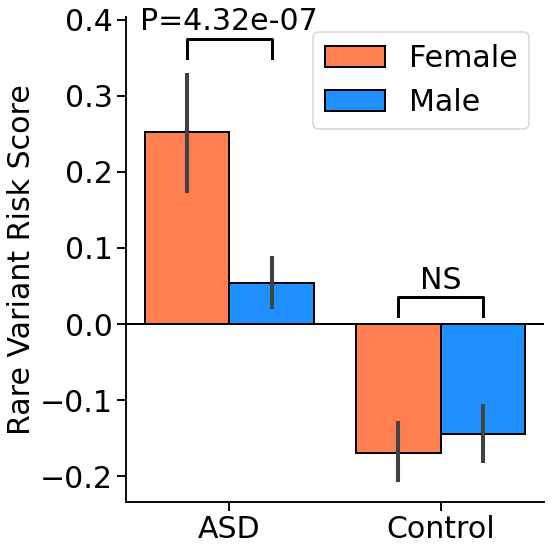

In [ ]:
# Figure 3A
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")



feature = "RVRS"
df = df.dropna(subset=[feature])

df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})

asd_male_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")])
asd_male_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")][feature]
asd_female_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")])
asd_female_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")][feature]
con_male_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")])
con_male_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")][feature]
con_female_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")])
con_female_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")][feature]

asd_male_female_p_value = scipy.stats.ttest_ind(asd_male_vals, asd_female_vals)[1]
con_male_female_p_value = scipy.stats.ttest_ind(con_male_vals, con_female_vals)[1]

# Plotting
sns.set_context("talk")
f, ax = plt.subplots(1, 1, figsize = (8,8))
ax = sns.barplot(
    x = "Phenotype",
    y = feature,
    hue = "Sex",
    data = df,
    hue_order=['Female','Male'],
    order = ["ASD","Control"],
    palette = ['coral','dodgerblue'],
    linewidth = 2,
    edgecolor = "k",
    saturation = 1,
    ax = ax
)

x_pos = []
for pos in ax.patches:
    x_pos.append(pos.get_x() + pos.get_width()/2.)

# Add p-values
height = 0.025

# Cases
y = 0.335
y = 0.35

s = "NS"
if asd_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(asd_male_female_p_value)
ax.plot([x_pos[0], x_pos[0], x_pos[2], x_pos[2]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[0] + x_pos[2])/2.,
    y = y + (1.5 * height) + .01,
    s = s,
    ha = "center",
    va = "center",
    fontsize = BIG,  
    color = "black"
    # fontsize = MEDIUM                  
)

# Controls
y = 0.01
s = "NS"
if con_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(con_male_female_p_value)
ax.plot([x_pos[1], x_pos[1], x_pos[3], x_pos[3]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[1] + x_pos[3])/2.,
    y = y + (1.5 * height) + .01,
    s = s,
    ha = "center",
    va = "center",
    fontsize = BIG,
    color = "black"           
    # fontsize = MEDIUM           
)


ylabel = "Rare Variant Risk Score"

ax.set_xticklabels(['ASD','Control'])
ax.set_xlabel("")
# ax.set_ylabel(ylabel)
ax.set_ylabel(ylabel, fontsize = BIG, color = "black")

plt.yticks(fontsize = BIG, color = "black")
plt.xticks(fontsize = BIG, color = "black")
# ax.xaxis.grid(alpha=0.5)
# ax.yaxis.grid(alpha=0.5)
ax.axhline(linewidth=2, color='black')
ax.legend(loc = 1, title='', fontsize = BIG)

ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("fig3a.png")
f.savefig("fig3a.svg")
f.savefig("fig3a.pdf")

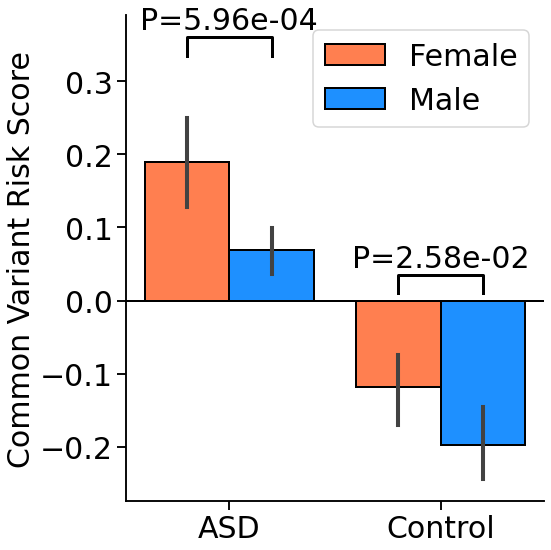

In [ ]:
# Figure 3B
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")


feature = "PRS"
df = df.dropna(subset=[feature])

df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})

asd_male_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")])
asd_male_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")][feature]
asd_female_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")])
asd_female_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")][feature]
con_male_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")])
con_male_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")][feature]
con_female_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")])
con_female_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")][feature]

asd_male_female_p_value = scipy.stats.ttest_ind(asd_male_vals, asd_female_vals)[1]
con_male_female_p_value = scipy.stats.ttest_ind(con_male_vals, con_female_vals)[1]



# Plotting
sns.set_context("talk")
f, ax = plt.subplots(1, 1, figsize = (8,8))
ax = sns.barplot(
    x = "Phenotype",
    y = feature,
    hue = "Sex",
    data = df,
    hue_order=['Female','Male'],
    order = ["ASD","Control"],
    palette = ['coral','dodgerblue'],
    linewidth = 2,
    edgecolor = "k",
    saturation = 1,
    ax = ax,
    # ci = 68,
    # estimator = np.mean
)

x_pos = []
for pos in ax.patches:
    x_pos.append(pos.get_x() + pos.get_width()/2.)

# Add p-values
height = 0.025
# Cases
y = 0.335
s = "NS"
if asd_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(asd_male_female_p_value)
ax.plot([x_pos[0], x_pos[0], x_pos[2], x_pos[2]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[0] + x_pos[2])/2.,
    y = y + (1.5 * height) + .01,
    s = s,
    ha = "center",
    va = "center",
    fontsize = BIG,
    color = "black"        
)

# Controls
y = 0.01
s = "NS"
if con_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(con_male_female_p_value)
ax.plot([x_pos[1], x_pos[1], x_pos[3], x_pos[3]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[1] + x_pos[3])/2.,
    y = y + (1.5 * height) + .01,
    s = s,
    ha = "center",
    va = "center",
    fontsize = BIG,
    color = "black"           
)


ylabel = "Common Variant Risk Score"

ax.set_xticklabels(['ASD','Control'])
ax.set_xlabel("")
ax.set_ylabel(ylabel, fontsize = BIG, color = "black")

plt.yticks(fontsize = BIG, color = "black")
plt.xticks(fontsize = BIG, color = "black")

# ax.xaxis.grid(alpha=0.5)
# ax.yaxis.grid(alpha=0.5)
ax.axhline(linewidth=2, color='black')
ax.legend(loc = 1, title='', fontsize = BIG)
ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("fig3b.png")
f.savefig("fig3b.svg")
f.savefig("fig3b.pdf")


In [ ]:
# asd_male_female_p_value = scipy.stats.ttest_ind(asd_male_vals, asd_female_vals)[1]
# con_male_female_p_value = scipy.stats.ttest_ind(con_male_vals, con_female_vals)[1]

print("ASD male mean: " + str(np.mean(asd_male_vals)))
print("ASD female mean: " + str(np.mean(asd_female_vals)))
print("CON male mean: " + str(np.mean(con_male_vals)))
print("CON female mean: " + str(np.mean(con_female_vals)))

print("ASD male standard deviation: " + str(np.std(asd_male_vals)))
print("ASD female standard deviation: " + str(np.std(asd_female_vals)))
print("CON male standard deviation: " + str(np.std(con_male_vals)))
print("CON female standard deviation: " + str(np.std(con_female_vals)))


scipy.stats.sem(con_male_vals)

ASD male mean: 0.06867509477542982
ASD female mean: 0.1894405765537241
CON male mean: -0.1974970962519262
CON female mean: -0.1180523754619857
ASD male standard deviation: 1.0054101278534227
ASD female standard deviation: 0.9570217677183626
CON male standard deviation: 0.998236471437932
CON female standard deviation: 0.9690615910899465


0.025748619105385697

In [ ]:
def ci(a, which=95, axis=None):
    """Return a percentile range from an array of values."""
    p = 50 - which / 2, 50 + which / 2
    return percentiles(a, p, axis)


def percentiles(a, pcts, axis=None):
    """Like scoreatpercentile but can take and return array of percentiles.
    Parameters
    ----------
    a : array
        data
    pcts : sequence of percentile values
        percentile or percentiles to find score at
    axis : int or None
        if not None, computes scores over this axis
    Returns
    -------
    scores: array
        array of scores at requested percentiles
        first dimension is length of object passed to ``pcts``
    """
    scores = []
    try:
        n = len(pcts)
    except TypeError:
        pcts = [pcts]
        n = 0
    for i, p in enumerate(pcts):
        if axis is None:
            score = stats.scoreatpercentile(a.ravel(), p)
        else:
            score = np.apply_along_axis(stats.scoreatpercentile, axis, a, p)
        scores.append(score)
    scores = np.asarray(scores)
    if not n:
        scores = scores.squeeze()
    return scores

import scipy.stats as stats



ci(asd_male_vals)


array([-1.94956588,  1.91265971])

In [ ]:
from seaborn.algorithms import bootstrap

def get_95_confinterval_of_mean(vals):
  boots = bootstrap(vals, func=np.mean, n_boot=1000,
                    units=None, seed=None)
  ci = 95
  confint = []
  confint.append(utils.ci(boots, ci))
  return confint


print("ASD male mean 95% confidence level: " + str(get_95_confinterval_of_mean(asd_male_vals)))
print("ASD female mean 95% confidence level: " + str(get_95_confinterval_of_mean(asd_female_vals)))
print("CON male mean 95% confidence level: " + str(get_95_confinterval_of_mean(con_male_vals)))
print("CON female mean 95% confidence level: " + str(get_95_confinterval_of_mean(con_female_vals)))


# n_boot = 1000
# boots = bootstrap(asd_male_vals, func=np.mean, n_boot=n_boot, 
#                   units=None, seed=None)

# ci = 95
# confint = []

# confint.append(utils.ci(boots, ci))
# confint

ASD male mean 95% confidence level: [array([0.04096581, 0.09630489])]
ASD female mean 95% confidence level: [array([0.12417582, 0.25247919])]
CON male mean 95% confidence level: [array([-0.24929196, -0.14579034])]
CON female mean 95% confidence level: [array([-0.16888412, -0.06765332])]


In [ ]:
scipy.stats.sem(con_male_vals)
scipy.stats.sem(con_male_vals)
scipy.stats.sem(con_male_vals)
scipy.stats.sem(con_male_vals)

print("ASD male SEM: " + str(scipy.stats.sem(asd_male_vals)))
print("ASD female SEM: " + str(scipy.stats.sem(asd_female_vals)))
print("CON male SEM: " + str(scipy.stats.sem(con_male_vals)))
print("CON female SEM: " + str(scipy.stats.sem(con_female_vals)))


ASD male SEM: 0.015413223412995227
ASD female SEM: 0.030416148420438133
CON male SEM: 0.025748619105385697
CON female SEM: 0.024622132932894433


In [ ]:
print("ASD male standard deviation: " + str(np.std(asd_male_vals)))
print("ASD female standard deviation: " + str(np.std(asd_female_vals)))
print("CON male standard deviation: " + str(np.std(con_male_vals)))
print("CON female standard deviation: " + str(np.std(con_female_vals)))

print("ASD male N: " + str(len(asd_male_vals)))
print("ASD female N: " + str(len(asd_female_vals)))
print("CON male N: " + str(len(con_male_vals)))
print("CON female N: " + str(len(con_female_vals)))



ASD male standard deviation: 1.0054101278534227
ASD female standard deviation: 0.9570217677183626
CON male standard deviation: 0.998236471437932
CON female standard deviation: 0.9690615910899465
ASD male N: 4256
ASD female N: 991
CON male N: 1504
CON female N: 1550


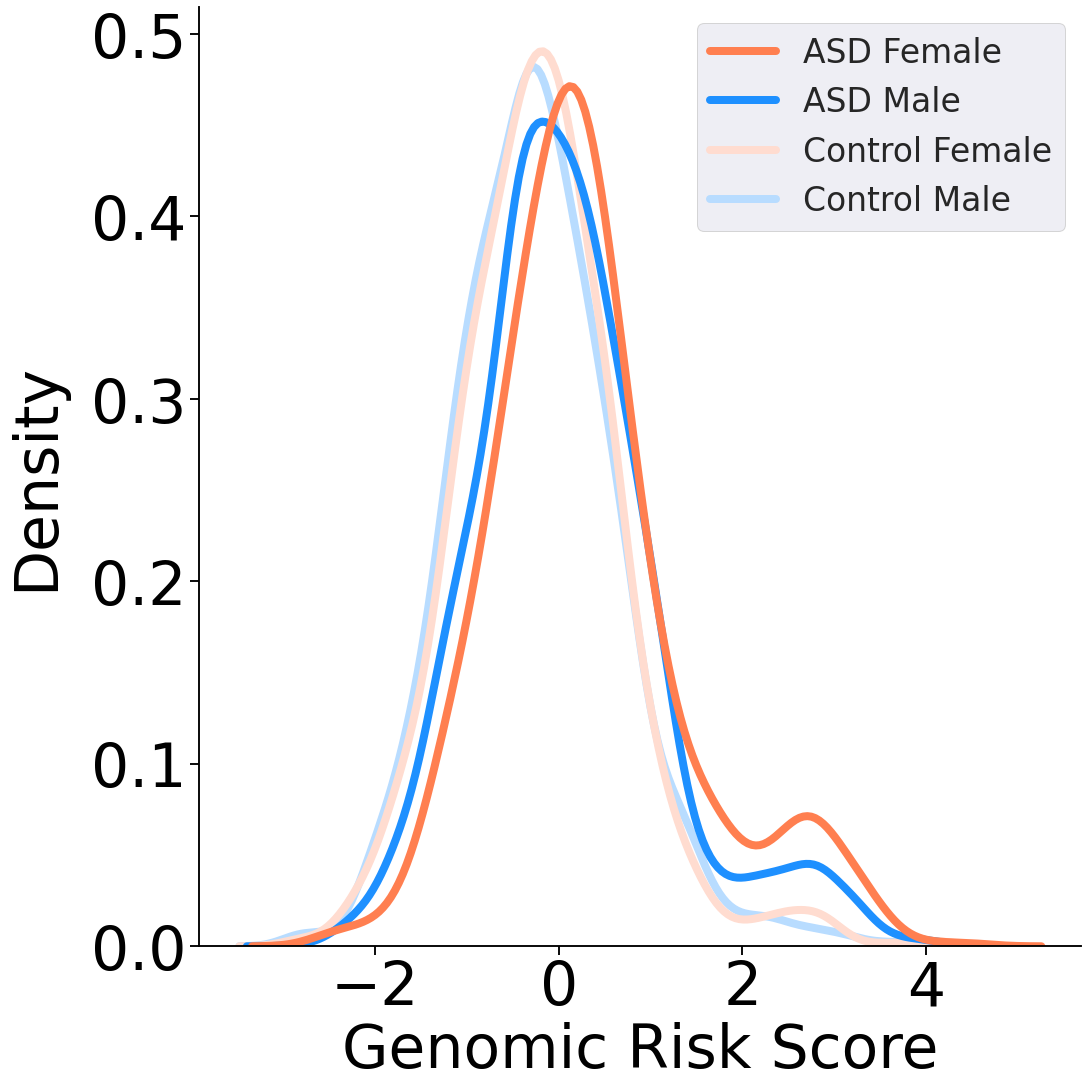

In [ ]:
# Figure 3C
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")


df = df.dropna(subset=["GRS"])


df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})
df['Category']=df['Phenotype']+' '+df['Sex']

# Plotting
sns.set_context('talk')
# f, ax = plt.subplots(1, 1, figsize=(8,8))
f, ax = plt.subplots(1, 1, figsize=(16,16))


sns.set(font_scale=3)

kdeplot = sns.kdeplot(
    data=df,
    x="GRS",
    hue="Category",
    linewidth=8,
    hue_order=['ASD Female','ASD Male','Control Female','Control Male'],
    palette=['coral','dodgerblue','#ffdcd0','#b8dcff'],
    alpha=0.8,
    common_norm=False,
    legend='brief',
    multiple="layer",
    ax=ax)

kdeplot.legend_.set_title(None)


sns.despine(ax=ax)
# ax.xaxis.grid(alpha=0.5)
# ax.yaxis.grid(alpha=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Genomic Risk Score', fontsize = MASSIVE, color = "black")

plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")

ax.set_ylabel("Density", fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")
ax.grid(False)


f.tight_layout()
f.savefig("fig3c.png", bbox_inches = "tight")
f.savefig("fig3c.svg", bbox_inches = "tight")
f.savefig("fig3c.pdf", bbox_inches = "tight")



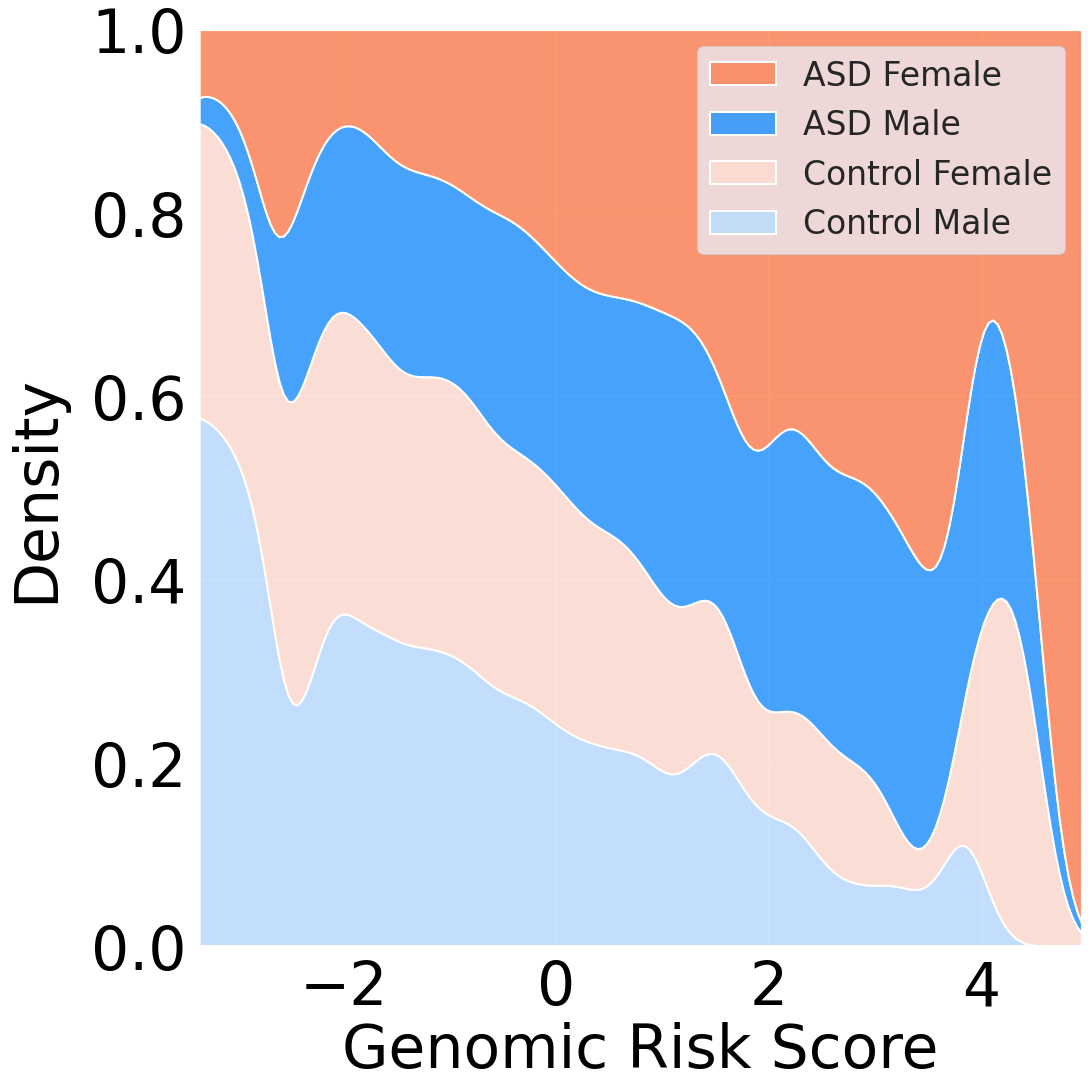

In [ ]:
# Figure 3D
sns.set_context('talk')
# f, ax = plt.subplots(1,1,figsize=(8,8))
f, ax = plt.subplots(1,1,figsize=(16,16))


sns.set(font_scale=3)

kdeplot = sns.kdeplot(
    data=df,
    x="GRS",
    hue="Category",
    linewidth=2,
    hue_order=['ASD Female','ASD Male','Control Female','Control Male'],
    palette=['coral','dodgerblue','#ffdcd0','#b8dcff'],
    alpha=0.8,
    common_norm=False,
    legend='brief',
    multiple="fill",
    ax=ax)

kdeplot.legend_.set_title(None)

sns.despine(ax=ax)
# ax.xaxis.grid(alpha=0.5)
# ax.yaxis.grid(alpha=0.5)
ax.set_axisbelow(True)
# ax.set_xlabel('Genomic Risk Score', fontsize = MEDIUM)
ax.set_xlabel('Genomic Risk Score', fontsize = MASSIVE, color = "black")


# plt.yticks(fontsize = MEDIUM)
# plt.xticks(fontsize = MEDIUM)
plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")


# ax.set_ylabel("Density", fontsize = BIG)
ax.set_ylabel("Density", fontsize = MASSIVE, labelpad = YLABEL_PAD, color = "black")


f.tight_layout()
f.savefig("fig3d.png", bbox_inches = "tight")
f.savefig("fig3d.pdf", bbox_inches = "tight")
f.savefig("fig3d.svg", bbox_inches = "tight")

# Figure 4

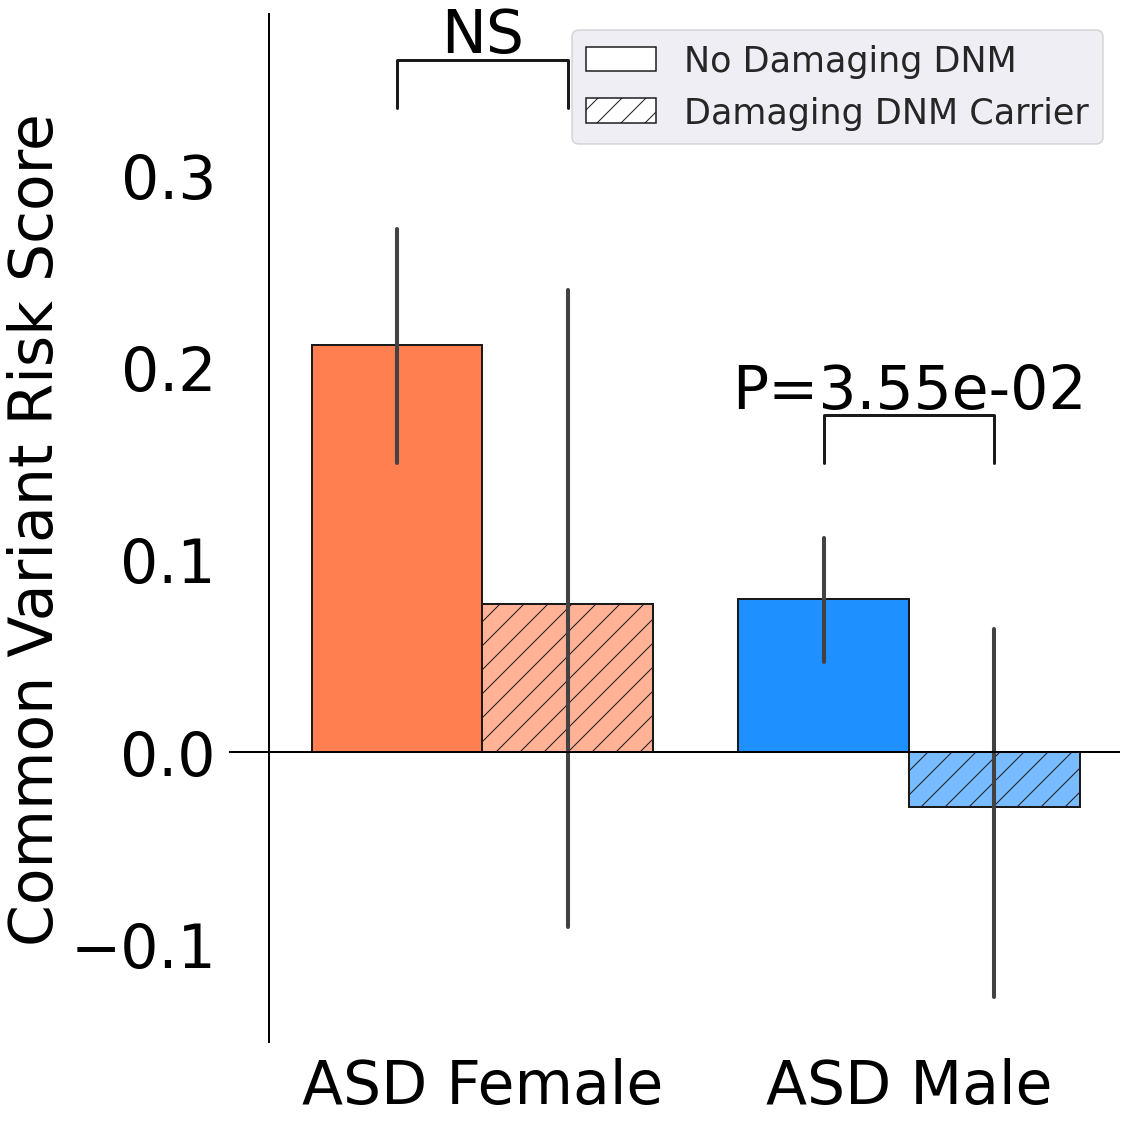

In [ ]:
# Figure 4A
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210715.csv", sep=",")


feature = "PRS"
df = df.dropna(subset=[feature])

# df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})
df["dnAll"] = df["dnLOF"] + df["dnMIS"]

# Samples only with ASD now
df = df[df["Phenotype"] == "ASD"]
df["dnBool"] = df["dnAll"] > 0
df['Sex'] = df['Sex'].replace({0:'ASD Male', 1:'ASD Female'})
df['dnBool'] = df['dnBool'].replace({True:'Damaging DNM Carrier', False:'No Damaging DNM'})

# ASD: no damaging DNM female vs. damaging DNM female
asd_female_dnm = df[(df["dnBool"] == "Damaging DNM Carrier") & (df["Sex"] == "ASD Female")]
asd_female_no_dnm = df[(df["dnBool"] == "No Damaging DNM") & (df["Sex"] == "ASD Female")]
asd_male_dnm = df[(df["dnBool"] == "Damaging DNM Carrier") & (df["Sex"] == "ASD Male")]
asd_male_no_dnm = df[(df["dnBool"] == "No Damaging DNM") & (df["Sex"] == "ASD Male")]

asd_female_dnm_num = len(asd_female_dnm)
asd_female_dnm_vals = asd_female_dnm[feature]
asd_female_no_dnm_num = len(asd_female_no_dnm)
asd_female_no_dnm_vals = asd_female_no_dnm[feature]

asd_male_dnm_num = len(asd_male_dnm)
asd_male_dnm_vals = asd_male_dnm[feature]
asd_male_no_dnm_num = len(asd_male_no_dnm)
asd_male_no_dnm_vals = asd_male_no_dnm[feature]

# asd_no_dnm_male_male_dnm_p_value = scipy.stats.ttest_ind(asd_male_no_dnm_vals, asd_male_dnm_vals)
# asd_dnm_female_no_dnm_female_p_value = scipy.stats.ttest_ind(asd_female_no_dnm_vals, asd_female_dnm_vals)

asd_male_dnm_no_dnm_p_value = scipy.stats.ttest_ind(asd_male_dnm_vals, asd_male_no_dnm_vals)
asd_female_dnm_no_dnm_p_value = scipy.stats.ttest_ind(asd_female_dnm_vals, asd_female_no_dnm_vals)

# Plotting
sns.set_context("talk")
f , ax = plt.subplots(1,1,figsize=(16,16))

ax = sns.barplot(
    x="Sex",
    y=feature,
    hue="dnBool",
    data=df,
    hue_order=['No Damaging DNM','Damaging DNM Carrier'],
    order=['ASD Female','ASD Male'],
    palette=['bisque','mediumaquamarine'],
    linewidth=2,
    edgecolor='k',
    saturation=1,
    ax=ax,
)


x_pos = []
for i, p in enumerate(ax.patches):
    x_pos.append(p.get_x() + p.get_width()/2.)
    if i == 2 or i == 3:
        p.set_hatch('/')
    if i == 0:
        p.set_color('coral')
    if i == 2:
        p.set_color('#ffb296')
    if i == 1: 
        p.set_color("dodgerblue")
    if i == 3:
        p.set_color("#78bcff")
    p.set_linewidth(2)
    p.set_edgecolor('k')


# Add p-values (females)
height = 0.025
y = 0.335
s = "NS"
if asd_female_dnm_no_dnm_p_value[1] <= 0.05:
  s = 'P={:.2e}'.format(asd_female_dnm_no_dnm_p_value[1])
ax.plot([x_pos[0], x_pos[0], x_pos[2], x_pos[2]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[0] + x_pos[2])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center",
    fontsize = MASSIVE,
    color = "black"           
    # fontsize = MEDIUM           
)

# Add p-values (males)
height = 0.025
y = 0.15
s = "NS"
if asd_male_dnm_no_dnm_p_value[1] <= 0.05:
  s = 'P={:.2e}'.format(asd_male_dnm_no_dnm_p_value[1])
ax.plot([x_pos[1], x_pos[1], x_pos[3], x_pos[3]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[1] + x_pos[3])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center",
    fontsize = MASSIVE,
    color = "black"   
    # fontsize = MEDIUM               
)



ax.set_xlabel("")
# ax.set_ylabel(ylabel, fontsize = MEDIUM)
# ax.set_ylabel(ylabel, fontsize = MASSIVE)
ax.set_ylabel("Common Variant Risk Score", fontsize = MASSIVE, color = "black")

# ax.xaxis.grid(alpha=0.5)
# ax.yaxis.grid(alpha=0.5)
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black', x = -.5)


leg = [
    Patch(facecolor='white',edgecolor='k',label='No Damaging DNM'),
    Patch(facecolor='white',edgecolor='k',hatch='/',label='Damaging DNM Carrier')
]

# plt.yticks(fontsize = MEDIUM)
# plt.xticks(fontsize = MEDIUM)
plt.yticks(fontsize = MASSIVE, color = "black")
plt.xticks(fontsize = MASSIVE, color = "black")


ax.grid(False)


# ax.legend(loc=3, title='', handles = leg, fontsize = SMALL)
ax.legend(loc=1, title='', handles = leg, fontsize = BIG + 5)
ax.set_facecolor('white')

ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("fig4a.png")
f.savefig("fig4a.svg")
f.savefig("fig4a.pdf")

# Figure 6

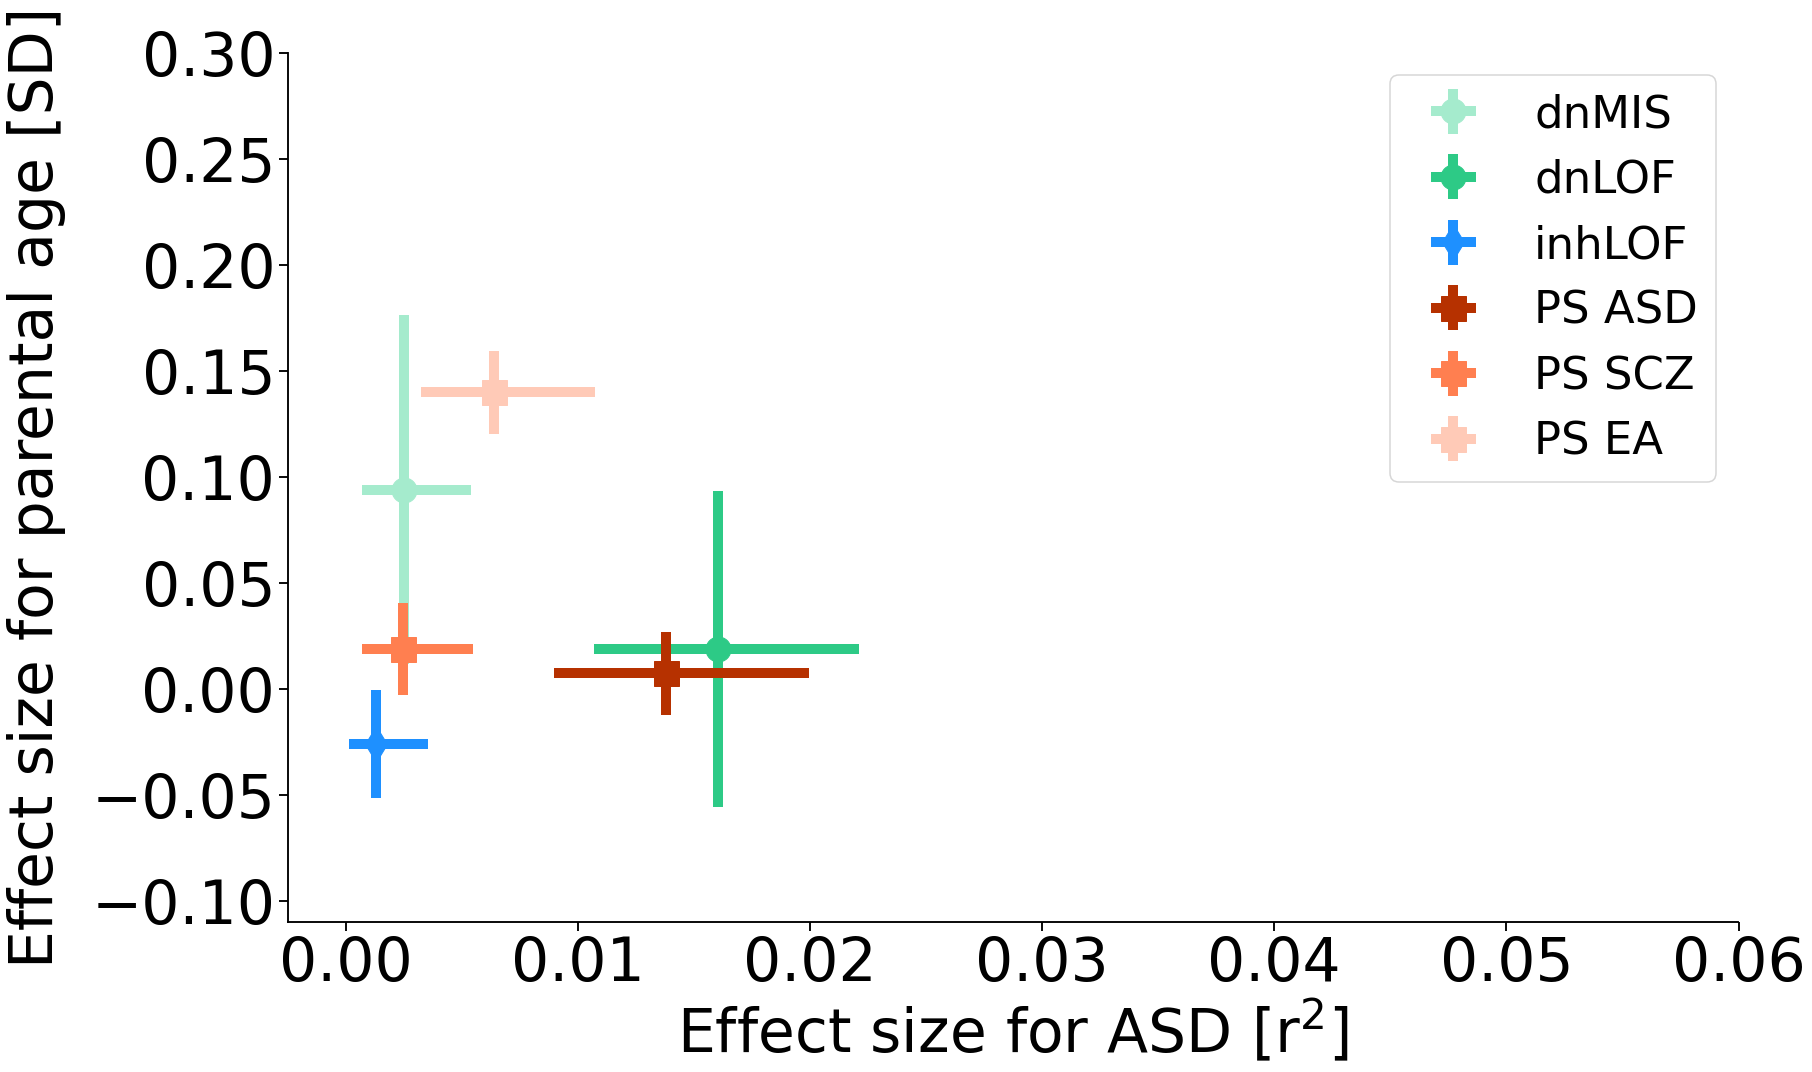

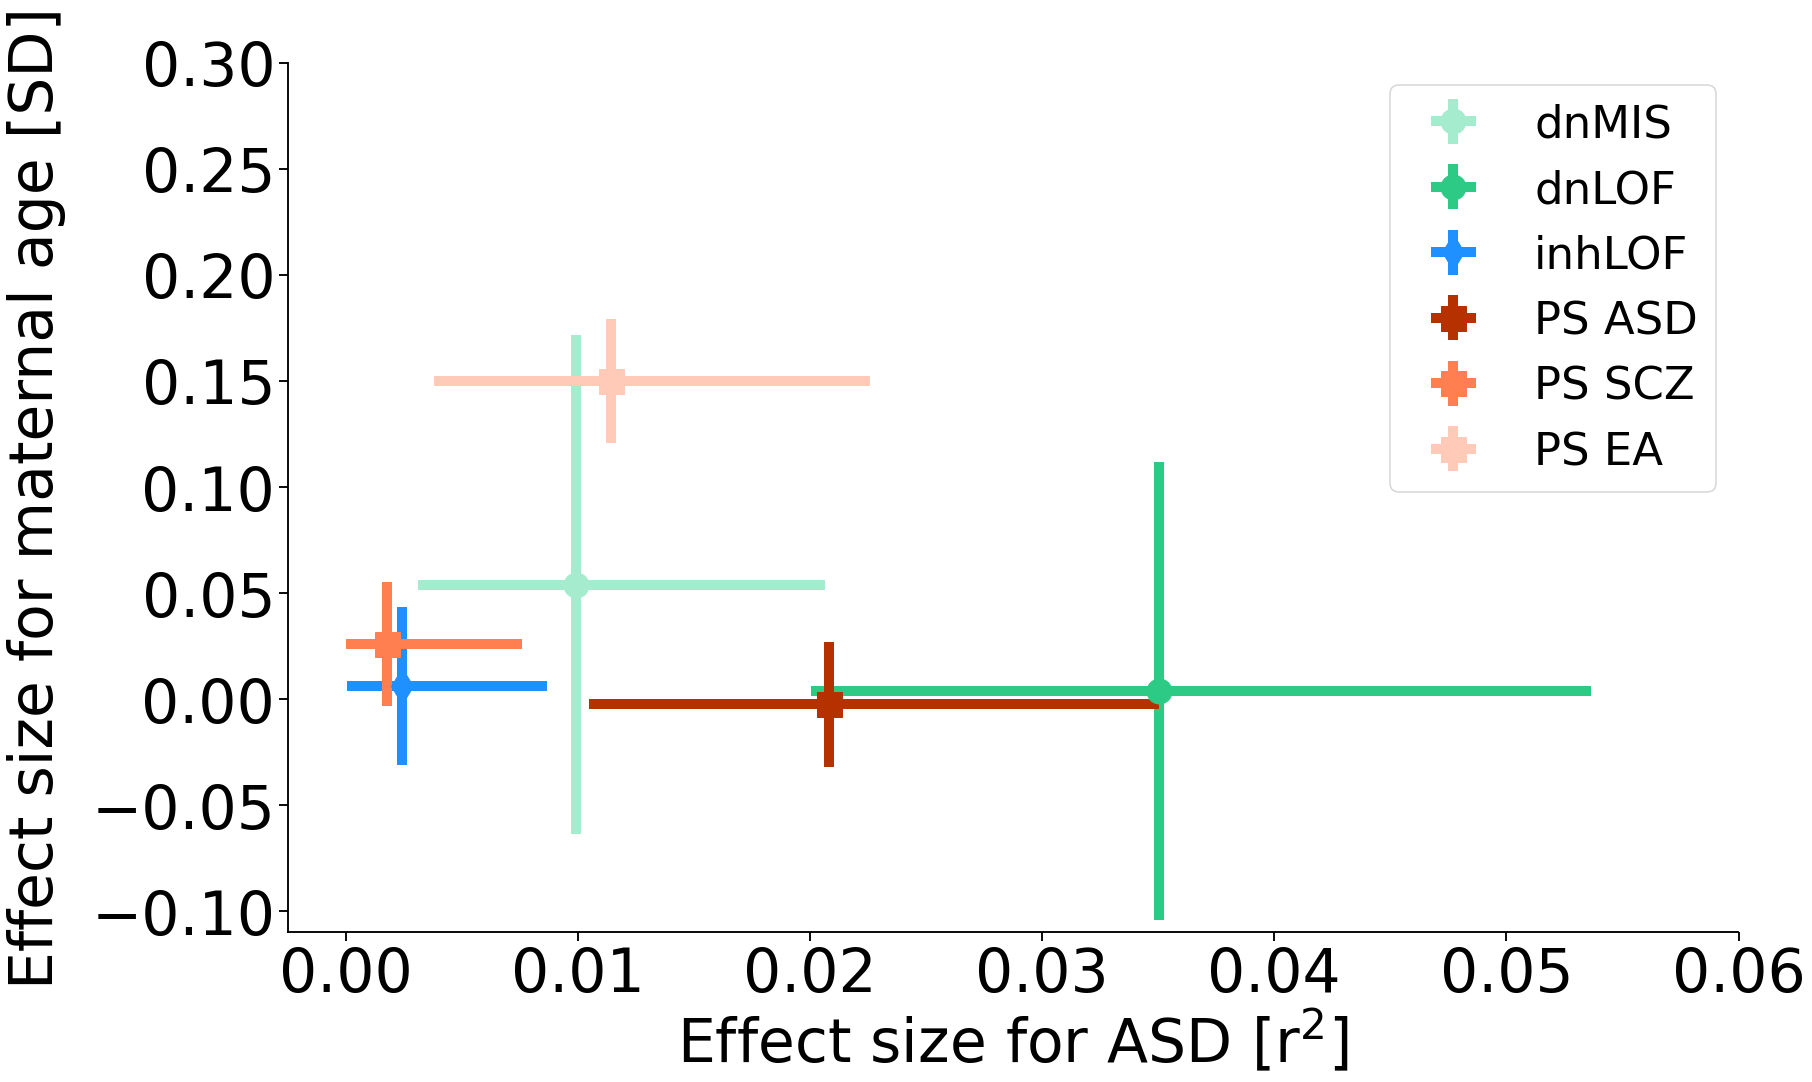

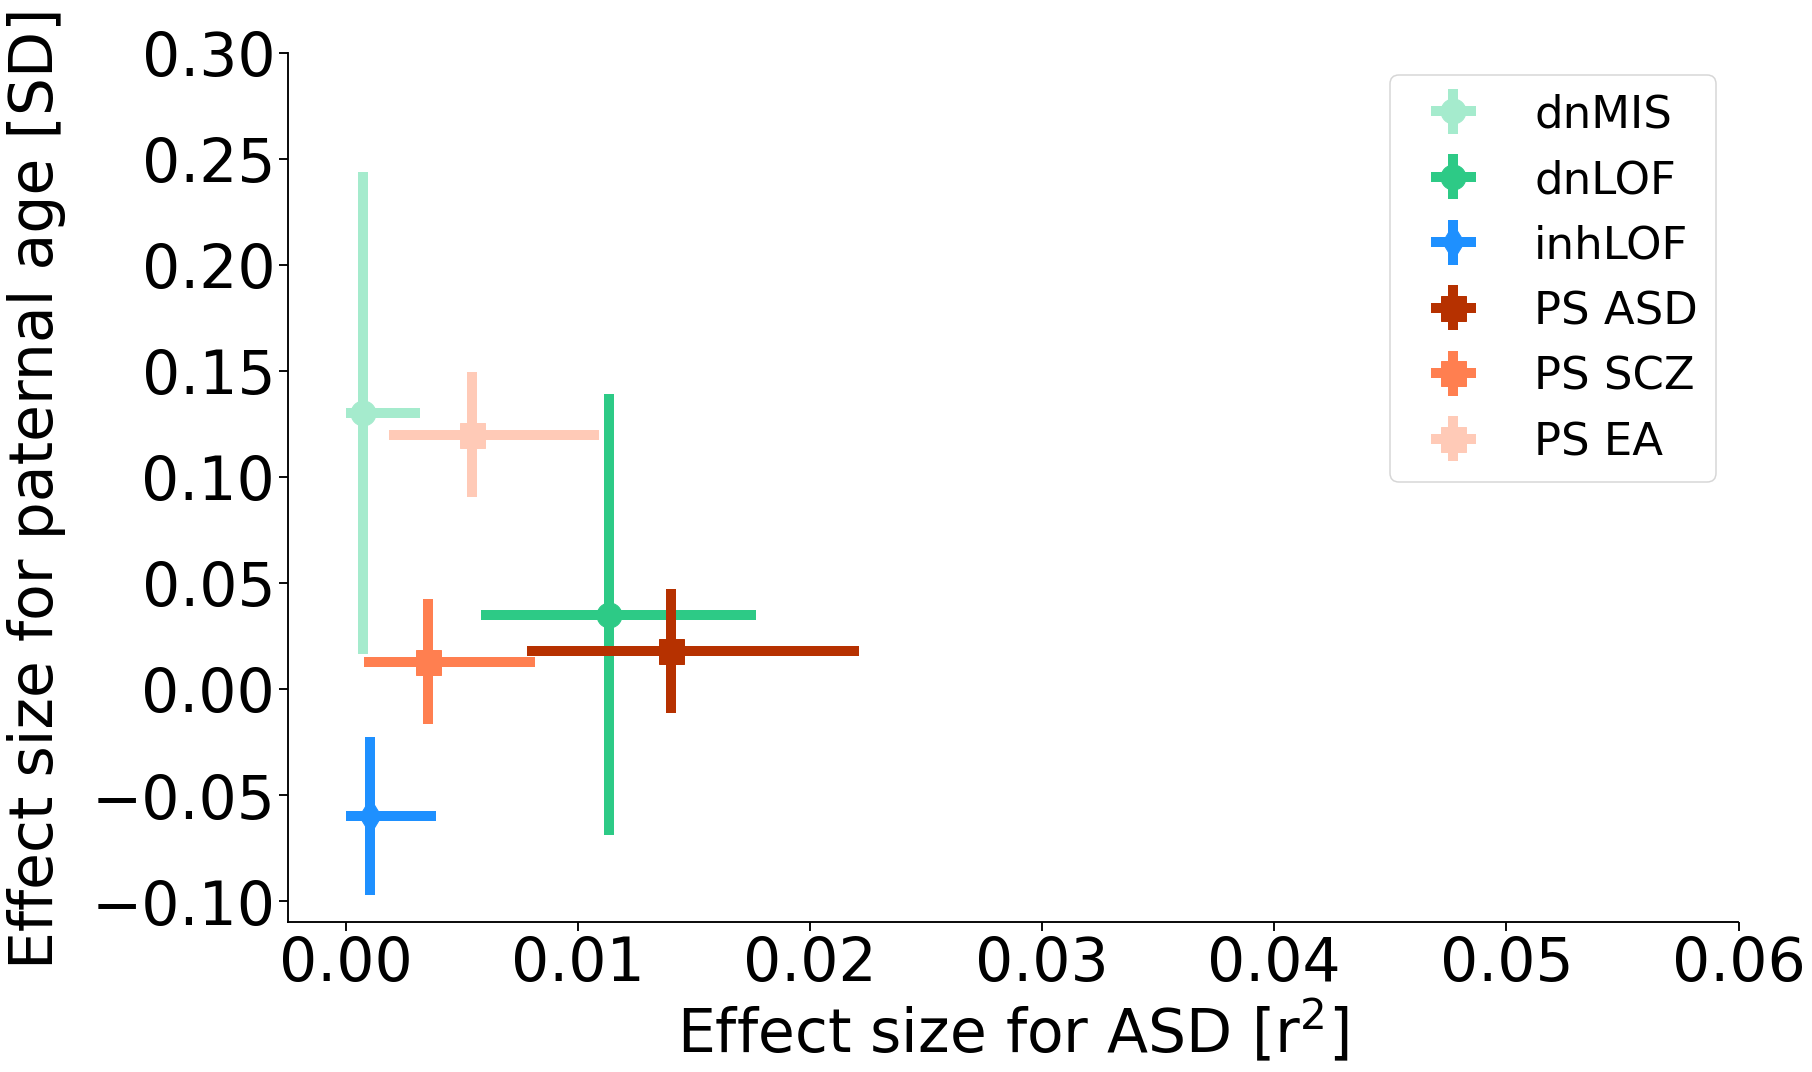

In [ ]:
# Figure 6
# Get Parental Age Estimates Table and reformat it
df_clin = pd.read_csv("/content/clin_results_eur.SBayesR.20210715.csv", sep=",")

df_clin = df_clin[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clin["variant.type"] = df_clin["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})
df_clin_parental_age = df_clin[df_clin["phenotype"] == "Parental Age"]

# Add sex column based on "group" column value
def set_sex(df_row):
  if df_row["group"] == "mother":
    return "female"
  elif df_row["group"] == "father":
    return "male"
  else:
    return "both"
df_clin_parental_age = df_clin_parental_age.assign(Sex=df_clin_parental_age.apply(set_sex, axis=1))
df_clin_parental_age = df_clin_parental_age.reset_index(drop=True)
# "Hacky" way of getting confidence interval from standard error
df_clin_parental_age["est.ci"] = df_clin_parental_age["est.stderr"]*1.96

# Get R2 Table and reformat it
df_r2 = pd.read_csv("/content/r2_table.csv", sep=",")


df_r2["ci_lower_adj"] = df_r2["nagelkerke_R2_val"] - df_r2["ci_lower"]
df_r2["ci_upper_adj"] = df_r2["ci_upper"] - df_r2["nagelkerke_R2_val"]

# df_r2[["R2_type", "Sex"]] = df_r2['R2_type'].str.split('_', 1, expand=True)
df_r2[["R2_type", "Sex"]] = df_r2['text'].str.split('_', 1, expand=True)
df_r2 = df_r2.rename(columns = {"R2_type": "variant.type"})
df_r2 = df_r2[(df_r2["variant.type"] == "dnLOF") | 
              (df_r2["variant.type"] == "dnMIS") |
              (df_r2["variant.type"] == "inhLOF") |
              (df_r2["variant.type"] == "ptdt.asd.dev") |
              (df_r2["variant.type"] == "ptdt.ea.dev") |
              (df_r2["variant.type"] == "ptdt.scz.dev")
              ]
df_r2["variant.type"] = df_r2["variant.type"].replace({
    "ptdt.asd.dev": "PS ASD",
    "ptdt.ea.dev": "PS EA",
    "ptdt.scz.dev": "PS SCZ"
})



df_r2 = df_r2.reset_index(drop=True)
# Merge Parental Age Estimates Table and R2 Table.
df_merge = df_clin_parental_age.merge(df_r2, on=["variant.type", "Sex"])


# Plotting
df = df_merge
def draw_plot(ax, df_in, index):
  ax.errorbar(
      x = df_in["nagelkerke_R2_val"],
      y = df_in["est"],
      # xerr = np.abs(df_in["ci"]),
      xerr = (np.abs(df_in["ci_lower_adj"]), np.abs(df_in["ci_upper_adj"])),
      yerr = np.abs(df_in["est.ci"]),
      fmt = "o",
      marker = mak[index],
      color = pal[index],
      # markersize = 18,
      markersize = 25,
      label = entry,
      # linewidth = 5,
      linewidth = 10,
      # alpha = 0.5
  )
  # ax.set_xlabel("Effect size for ASD [r$^2$]")
  # ax.set_ylabel("Effect size for parental age [standard deviation]")
  ax.set_xlabel("Effect size for ASD [r$^2$]", fontsize = MASSIVE, color = "black")
  # ax.set_ylabel("Effect size for parental age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")

  # ax.xaxis.grid(alpha=0.5)
  # ax.yaxis.grid(alpha=0.5)
  sns.despine(ax=ax)
  ax.set_ylim(-0.11,0.3)
  # ax.set_ylim(-0.5,0.5)
  ax.set_xlim(-0.0025,0.06)
  # ax.set_xlim(-0.01,0.03)
  
  plt.yticks(fontsize = MASSIVE, color = "black")
  plt.xticks(fontsize = MASSIVE, color = "black")
  ax.grid(False)

  ax.set_facecolor('white')
  ax.legend(loc = 1, fontsize = MASSIVE - 15)

  # ax.axhline(linewidth=2, color='black', y = -0.1)
  # ax.axvline(linewidth=2, color='black')



sns.set_context("talk")
mod = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
pal = ['#a5ebcd','#2dca86','dodgerblue','#b63100','coral','#ffcab7']
mak = ['o','o','d','s','s','s']


f1, ax1 = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

for index, entry in enumerate(mod):
  df_both = df[(df["variant.type"] == entry) & (df["Sex"] == "both")]
  draw_plot(ax1, df_both, index)
  ax1.set_ylabel("Effect size for parental age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")


  f1.savefig("fig6.both.png", bbox_inches = "tight")
  f1.savefig("fig6.both.svg", bbox_inches = "tight")
  f1.savefig("fig6.both.pdf", bbox_inches = "tight")


f2, ax2 = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

for index, entry in enumerate(mod):
  df_mother = df[(df["variant.type"] == entry) & (df["Sex"] == "female")]
  draw_plot(ax2, df_mother, index)
  ax2.set_ylabel("Effect size for maternal age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")

  f2.savefig("fig6.mother.png", bbox_inches = "tight")
  f2.savefig("fig6.mother.svg", bbox_inches = "tight")
  f2.savefig("fig6.mother.pdf", bbox_inches = "tight")


f3, ax3 = plt.subplots(1,1,figsize=FIGSIZE_DEFAULT)

for index, entry in enumerate(mod):
  df_father = df[(df["variant.type"] == entry) & (df["Sex"] == "male")]
  draw_plot(ax3, df_father, index)
  ax3.set_ylabel("Effect size for paternal age [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment='center', color = "black")

  f3.savefig("fig6.father.png", bbox_inches = "tight")
  f3.savefig("fig6.father.svg", bbox_inches = "tight")
  f3.savefig("fig6.father.pdf", bbox_inches = "tight")


In [ ]:
df_merge

,case.status,phenotype,group,variant.type,r.sq,est,est.stderr,pearson.cc,x.pval,sex.pval,Sex,est.ci,text,nagelkerke_R2_val,lr_p_val,ste,ci_lower,ci_upper,ci_t0,ci_lower_adj,ci_upper_adj
0,parent,Parental Age,mother,dnLOF,0.000001,0.0039,0.055,NaN,9.400000e-01,NaN,female,0.10780,dnLOF_female,0.035042,2.902914e-17,0.008584,0.020025,0.053626,0.035042,0.015017,0.018584
1,parent,Parental Age,mother,dnMIS,0.000170,0.0540,0.060,NaN,3.700000e-01,NaN,female,0.11760,dnMIS_female,0.009912,7.763778e-06,0.004441,0.003134,0.020649,0.009912,0.006777,0.010737
2,parent,Parental Age,mother,inhLOF,0.000023,0.0062,0.019,NaN,7.400000e-01,NaN,female,0.03724,inhLOF_female,0.002427,2.715960e-02,0.002320,0.000061,0.008659,0.002427,0.002366,0.006232
3,parent,Parental Age,mother,PS ASD,0.000006,-0.0024,0.015,NaN,8.700000e-01,NaN,female,0.02940,ptdt.asd.dev_female,0.020805,8.435829e-11,0.006270,0.010477,0.035048,0.020805,0.010327,0.014244
4,parent,Parental Age,mother,PS SCZ,0.000630,0.0260,0.015,NaN,8.000000e-02,NaN,female,0.02940,ptdt.scz.dev_female,0.001779,5.855614e-02,0.002030,0.000016,0.007575,0.001779,0.001763,0.005796
5,parent,Parental Age,mother,PS EA,0.023000,0.1500,0.015,NaN,5.100000e-26,NaN,female,0.02940,ptdt.ea.dev_female,0.011409,1.594842e-06,0.004802,0.003803,0.022571,0.011409,0.007606,0.011162
6,parent,Parental Age,father,dnLOF,0.000110,0.0350,0.053,NaN,5.100000e-01,NaN,male,0.10388,dnLOF_male,0.011332,1.745307e-11,0.003057,0.005836,0.017687,0.011332,0.005496,0.006354
7,parent,Parental Age,father,dnMIS,0.000990,0.1300,0.058,NaN,2.800000e-02,NaN,male,0.11368,dnMIS_male,0.000740,8.624987e-02,0.000896,0.000004,0.003209,0.000740,0.000736,0.002469
8,parent,Parental Age,father,inhLOF,0.002000,-0.0600,0.019,NaN,1.400000e-03,NaN,male,0.03724,inhLOF_male,0.001039,4.209766e-02,0.001066,0.000017,0.003872,0.001039,0.001022,0.002834
9,parent,Parental Age,father,PS ASD,0.002500,0.0180,0.015,NaN,2.200000e-01,NaN,male,0.02940,ptdt.asd.dev_male,0.014025,7.104912e-14,0.003668,0.007796,0.022103,0.014025,0.006229,0.008078


In [ ]:
# Zip and download all the data
!zip -r /content/Antaki2021_figure_data.zip /content
from google.colab import files
files.download("/content/Antaki2021_figure_data.zip")


In [ ]:
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]


df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")


df_filtered_dnms_iossifov = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")
df_filtered_dnms_iossifov = df_filtered_dnms_iossifov.rename(columns = {
                          "lof_count": "lof_count_iossifov",
                          "mis_count": "mis_count_iossifov",
                          "syn_count": "syn_count_iossifov"
                          })

df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")

df_dnms_merge = df_dnms_merge.merge(df_filtered_dnms_iossifov, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")

df_dnms_merge["lof_compare"] = df_dnms_merge["dnLOF"] - df_dnms_merge["lof_count"]
df_dnms_merge["mis_compare"] = df_dnms_merge["dnLOF"] - df_dnms_merge["lof_count"]

df_dnms_merge["has_lof"] = df_dnms_merge["lof_count"] > 0
df_dnms_merge["has_lof"] = df_dnms_merge["has_lof"].replace({True: 1, False: 0}) 

df_dnms_merge["has_mis"] = df_dnms_merge["mis_count"] > 0
df_dnms_merge["has_mis"] = df_dnms_merge["has_mis"].replace({True: 1, False: 0}) 

df_dnms_merge["has_syn"] = df_dnms_merge["syn_count"] > 0
df_dnms_merge["has_syn"] = df_dnms_merge["has_syn"].replace({True: 1, False: 0}) 

# Iossifov
df_dnms_merge["has_lof_iossifov"] = df_dnms_merge["lof_count_iossifov"] > 0
df_dnms_merge["has_lof_iossifov"] = df_dnms_merge["has_lof_iossifov"].replace({True: 1, False: 0}) 

df_dnms_merge["has_mis_iossifov"] = df_dnms_merge["mis_count_iossifov"] > 0
df_dnms_merge["has_mis_iossifov"] = df_dnms_merge["has_mis_iossifov"].replace({True: 1, False: 0}) 

df_dnms_merge["has_syn_iossifov"] = df_dnms_merge["syn_count_iossifov"] > 0
df_dnms_merge["has_syn_iossifov"] = df_dnms_merge["has_syn_iossifov"].replace({True: 1, False: 0}) 


# Filter
df_dnms_merge = df_dnms_merge.dropna(subset = ["mis_count", "lof_count", "syn_count"])
df_dnms_merge = df_dnms_merge.dropna(subset = ["has_mis", "has_lof", "has_syn"])
df_dnms_merge = df_dnms_merge.drop(df_dnms_merge[df_dnms_merge["syn_count"] > 10].index)
df_dnms_merge = df_dnms_merge[df_dnms_merge["Family Type"] == "trio"]


df_dnms_reach = df_dnms_merge[df_dnms_merge["Cohort"] == "REACH"]
df_dnms_ssc   = df_dnms_merge[df_dnms_merge["Cohort"] == "SSC"]
df_dnms_spark = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]


def run_ttest(df, column_name):
  df_ctl = df[df["Phenotype"] == 0]
  df_cas = df[df["Phenotype"] == 1]

  df_ctl_count = df_ctl[column_name].dropna()
  df_cas_count = df_cas[column_name].dropna()

  ttest = scipy.stats.ttest_ind(df_ctl_count, df_cas_count)
  print(column_name + ": " + str(ttest))

print("t-test test p-values\n")

print("\nAll cohorts")
run_ttest(df_dnms_merge, "lof_count_iossifov")
run_ttest(df_dnms_merge, "mis_count_iossifov")
run_ttest(df_dnms_merge, "syn_count_iossifov")


print("\nREACH")
run_ttest(df_dnms_reach, "lof_count_iossifov")
run_ttest(df_dnms_reach, "mis_count_iossifov")
run_ttest(df_dnms_reach, "syn_count_iossifov")

print("\nSSC")
run_ttest(df_dnms_ssc, "lof_count_iossifov")
run_ttest(df_dnms_ssc, "mis_count_iossifov")
run_ttest(df_dnms_ssc, "syn_count_iossifov")

print("\nSPARK")
run_ttest(df_dnms_spark, "lof_count_iossifov")
run_ttest(df_dnms_spark, "mis_count_iossifov")
run_ttest(df_dnms_spark, "syn_count_iossifov")



def run_chisq(df, column_name):
  df_tmp = df[column_name].dropna()
  contigency = pd.crosstab(df[column_name], df['Phenotype']) 
  # Chi-square test of independence. 
  c, p, dof, expected = chi2_contingency(contigency) 
  # Print the p-value
  print(column_name + " p_value: " + str(p))
  print(contigency)

print("Chi-squared test p-values\n")

print("\nAll cohorts")
run_chisq(df_dnms_merge, "has_lof_iossifov")
run_chisq(df_dnms_merge, "has_mis_iossifov")
run_chisq(df_dnms_merge, "has_syn_iossifov")

print("\nREACH")
run_chisq(df_dnms_reach, "has_lof_iossifov")
run_chisq(df_dnms_reach, "has_mis_iossifov")
run_chisq(df_dnms_reach, "has_syn_iossifov")

print("\nSSC")
run_chisq(df_dnms_ssc, "has_lof_iossifov")
run_chisq(df_dnms_ssc, "has_mis_iossifov")
run_chisq(df_dnms_ssc, "has_syn_iossifov")

print("\nSPARK")
run_chisq(df_dnms_spark, "has_lof_iossifov")
run_chisq(df_dnms_spark, "has_mis_iossifov")
run_chisq(df_dnms_spark, "has_syn_iossifov")

# df_dnms_merge.to_csv("df_dnms_merge.tsv", sep = "\t", index = False)

t-test test p-values


All cohorts
lof_count_iossifov: Ttest_indResult(statistic=-9.885593438123804, pvalue=5.972468853004858e-23)
mis_count_iossifov: Ttest_indResult(statistic=-5.571019409111952, pvalue=2.591218669000873e-08)
syn_count_iossifov: Ttest_indResult(statistic=-1.1986670204558691, pvalue=0.23068289890657392)

REACH
lof_count_iossifov: Ttest_indResult(statistic=-1.6248418967433644, pvalue=0.10487236833475204)
mis_count_iossifov: Ttest_indResult(statistic=-0.895392537677837, pvalue=0.3710395511300275)
syn_count_iossifov: Ttest_indResult(statistic=-0.6432214878360398, pvalue=0.5203967763925121)

SSC
lof_count_iossifov: Ttest_indResult(statistic=-6.85449173003509, pvalue=8.171546895412707e-12)
mis_count_iossifov: Ttest_indResult(statistic=-4.144766558316907, pvalue=3.466989189919595e-05)
syn_count_iossifov: Ttest_indResult(statistic=0.6461073117501467, pvalue=0.51824429170018)

SPARK
lof_count_iossifov: Ttest_indResult(statistic=-6.950738535689575, pvalue=3.9946596406780845e-12

In [ ]:
def get_counts(df, column_name):
  df_ctl = df[df["Phenotype"] == 0]
  df_cas = df[df["Phenotype"] == 1]

  df_ctl_count = df_ctl[column_name].dropna()
  df_cas_count = df_cas[column_name].dropna()

  print(df_ctl.shape)
  print(df_cas.shape)
  print(sum(df_ctl_count))
  print(sum(df_cas_count))


# get_counts(df_dnms_merge, "syn_count_iossifov")

def get_all_counts(df):
  df_ctl = df[df["Phenotype"] == 0]
  df_cas = df[df["Phenotype"] == 1]

  ctl_all_counts = df_ctl["lof_count_iossifov"] + df_ctl["mis_count_iossifov"] + df_ctl["syn_count_iossifov"]
  cas_all_counts = df_cas["lof_count_iossifov"] + df_cas["mis_count_iossifov"] + df_cas["syn_count_iossifov"]

  ctl_all_counts = ctl_all_counts.dropna()
  cas_all_counts = cas_all_counts.dropna()

  print(sum(ctl_all_counts))
  print(sum(cas_all_counts))

# get_all_counts(df_dnms_merge)



(3988, 26)
(7174, 26)
1223.0
2293.0


In [ ]:
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")

df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")

df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)
# Am I using "non_count"?
df_dnms_merge['non_count'] = df_dnms_merge['non_count'].fillna(value = 0)

df_filtered_dnms_iossifov = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")
df_filtered_dnms_iossifov = df_filtered_dnms_iossifov.rename(columns = {
                          "lof_count": "lof_count_iossifov",
                          "mis_count": "mis_count_iossifov",
                          "syn_count": "syn_count_iossifov"
                          })

df_dnms_merge = df_dnms_merge.merge(df_filtered_dnms_iossifov, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
df_dnms_merge['lof_count_iossifov'] = df_dnms_merge['lof_count_iossifov'].fillna(value = 0)
df_dnms_merge['mis_count_iossifov'] = df_dnms_merge['mis_count_iossifov'].fillna(value = 0)
df_dnms_merge['syn_count_iossifov'] = df_dnms_merge['syn_count_iossifov'].fillna(value = 0)


lof_count = df_dnms_merge["lof_count"]
dnLOF = df_dnms_merge["dnLOF"]
print(sum(lof_count))
print(sum(dnLOF))

mis_count = df_dnms_merge["mis_count"]
dnMIS = df_dnms_merge["dnMIS"]
print(sum(mis_count))
print(sum(dnMIS))

df_dnms_merge["lof_compare"] = df_dnms_merge["dnLOF"] - df_dnms_merge["lof_count"]
df_dnms_merge["mis_compare"] = df_dnms_merge["dnMIS"] - df_dnms_merge["mis_count"]

df_dnms_merge["lof_compare_iossifov"] = df_dnms_merge["dnLOF"] - df_dnms_merge["lof_count_iossifov"]
df_dnms_merge["mis_compare_iossifov"] = df_dnms_merge["dnMIS"] - df_dnms_merge["mis_count_iossifov"]


# df_dnms_merge[df_dnms_merge["lof_compare"] == -1]

# df_filtered_dnms[df_filtered_dnms["IID"] == "REACH000774"]
# df_dnms_merge[df_dnms_merge["IID"] == "REACH000774"]


df_dnms_merge[df_dnms_merge["Phenotype"] == 1].shape
df_dnms_merge[df_dnms_merge["Phenotype"] == 0].shape


# No chromosome X
# Get rid

In [ ]:
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")

df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)


def make_df(df, col):
  df_tmp = df.dropna(subset=[col])
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])


df_lof_count = make_df(df_dnms_merge, "lof_count")
df_mis_count = make_df(df_dnms_merge, "mis_count")
df_syn_count = make_df(df_dnms_merge, "syn_count")

df_2b = pd.concat([df_lof_count, df_mis_count, df_syn_count])


# Plotting
colors = ['mediumaquamarine', 'bisque']

ax = df_2b.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k"
)

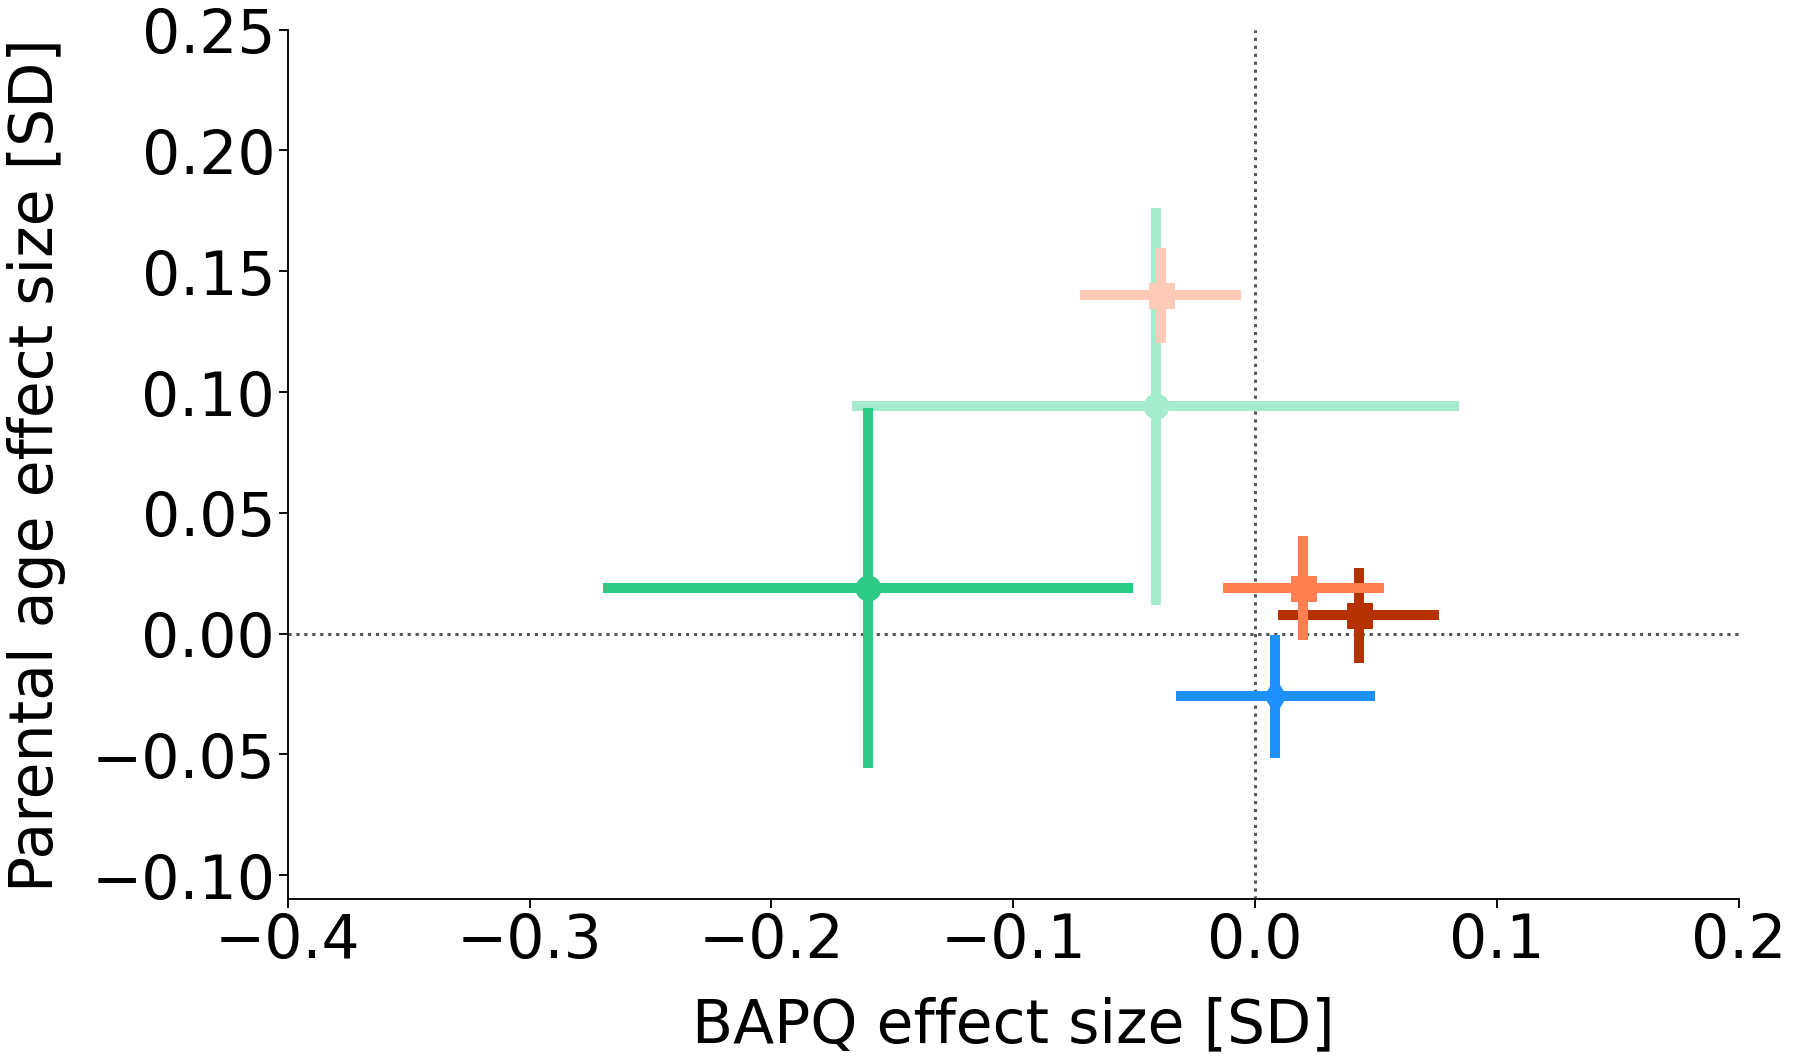

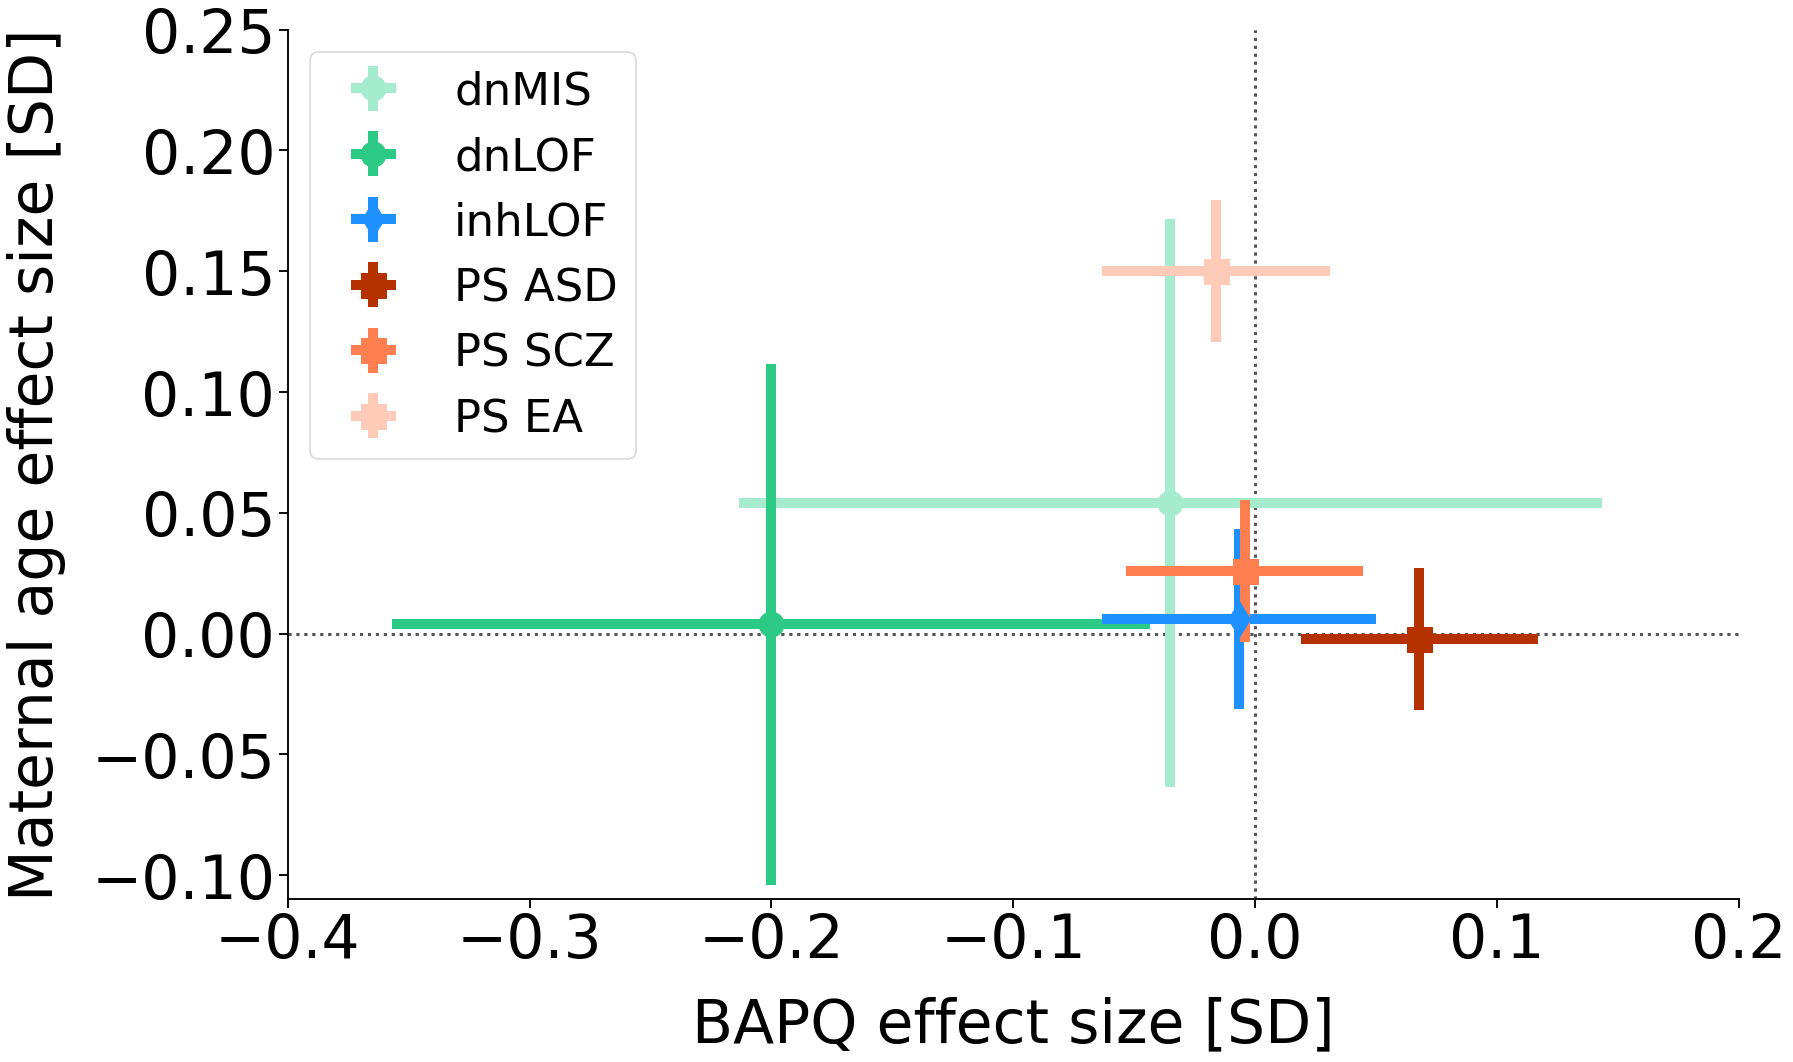

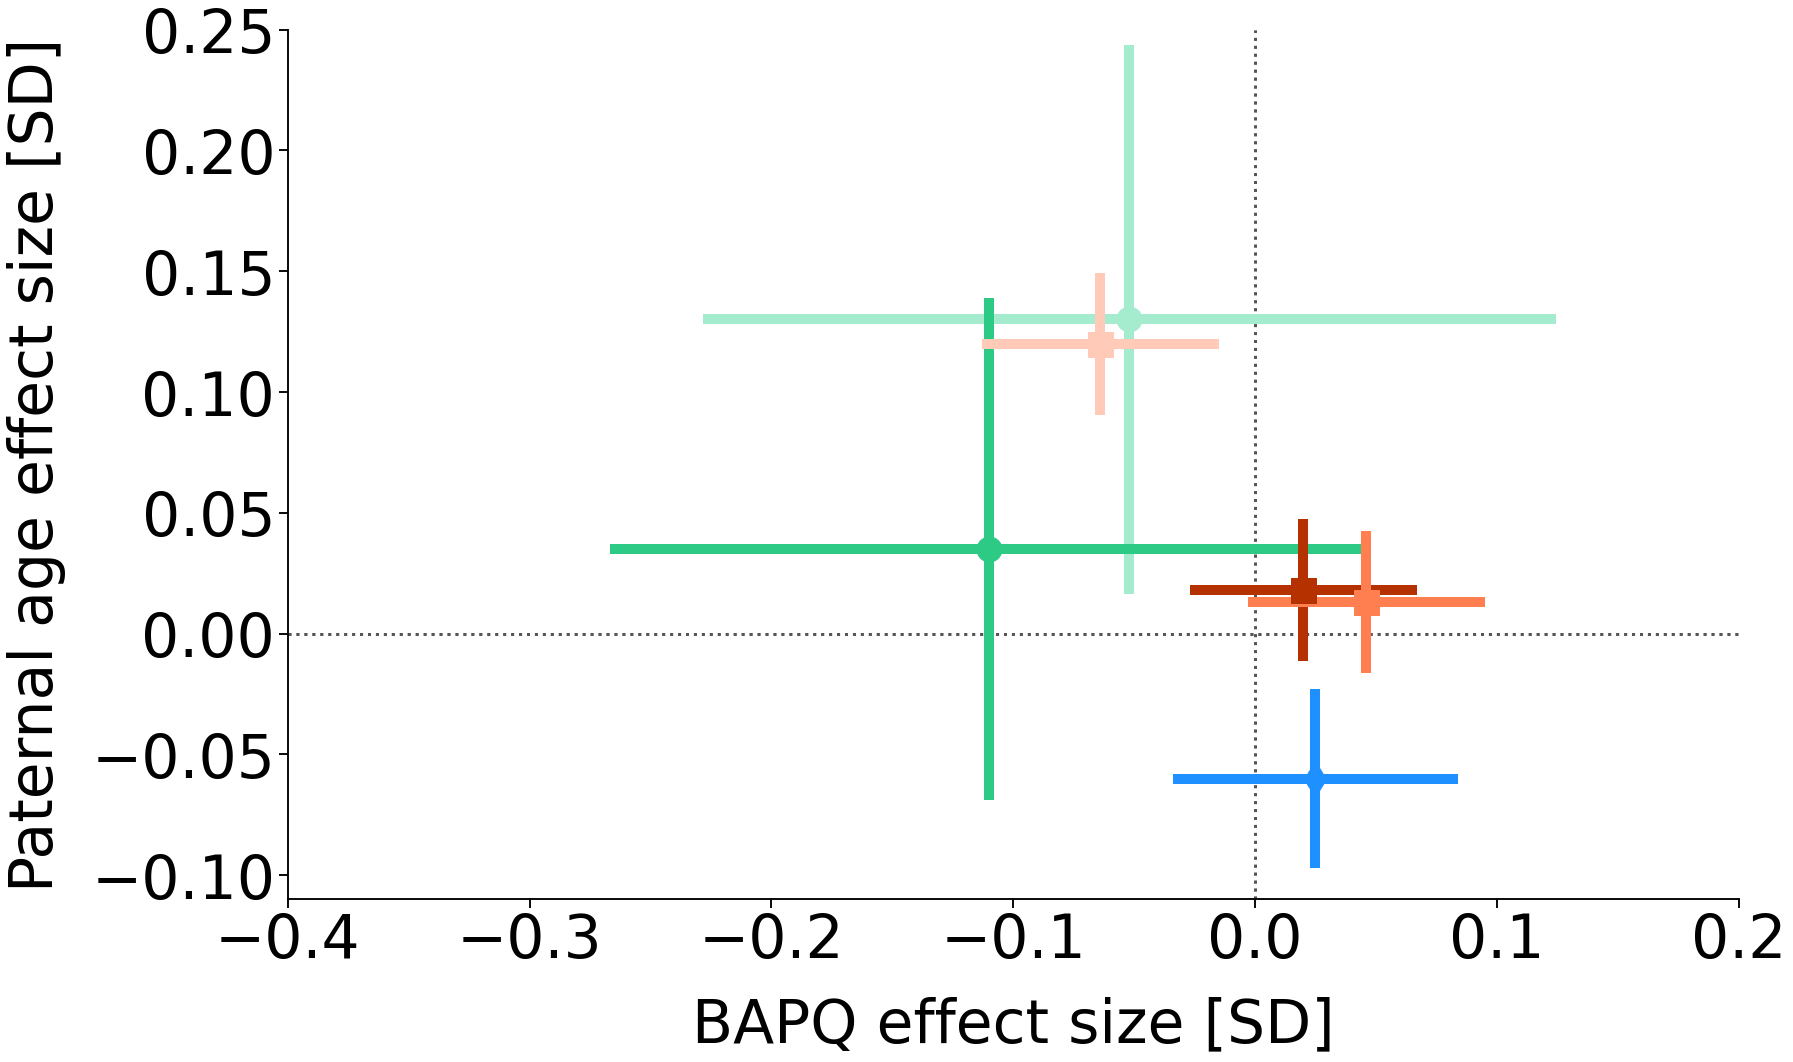

In [ ]:
# Figure 6
# Get Parental Age Estimates Table and reformat it
df_clin = pd.read_csv("/content/clin_results_eur.SBayesR.20210715.csv", sep=",")

df_clin = df_clin[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clin["variant.type"] = df_clin["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})

# Add sex column based on "group" column value
def set_sex(df_row):
  if df_row["group"] == "mother":
    return "female"
  elif df_row["group"] == "father":
    return "male"
  else:
    return "both"


df_clin_parental_age = df_clin[df_clin["phenotype"] == "Parental Age"]
df_clin_parental_age = df_clin_parental_age.assign(Sex=df_clin_parental_age.apply(set_sex, axis=1))
df_clin_parental_age = df_clin_parental_age.reset_index(drop=True)
# "Hacky" way of getting confidence interval from standard error
df_clin_parental_age["est.ci"] = df_clin_parental_age["est.stderr"]*1.96

df_clin_parental_age = df_clin_parental_age.rename(columns = {
                          "r.sq": "r.sq.pa",
                          "est": "est.pa",
                          "est.stderr": "est.stderr.pa",
                          "pearson.cc": "pearson.cc.pa",
                          "x.pval": "x.pval.pa",
                          "sex.pval": "sex.pval.pa",
                          "est.ci": "est.ci.pa"
                          })


df_clin_bapq = df_clin[df_clin["phenotype"] == "BAPQ"]
df_clin_bapq = df_clin_bapq.assign(Sex=df_clin_bapq.apply(set_sex, axis=1))
df_clin_bapq = df_clin_bapq.reset_index(drop=True)
# "Hacky" way of getting confidence interval from standard error
df_clin_bapq["est.ci"] = df_clin_bapq["est.stderr"]*1.96

df_clin_bapq = df_clin_bapq.rename(columns = {
                          "r.sq": "r.sq.bapq",
                          "est": "est.bapq",
                          "est.stderr": "est.stderr.bapq",
                          "pearson.cc": "pearson.cc.bapq",
                          "x.pval": "x.pval.bapq",
                          "sex.pval": "sex.pval.bapq",
                          "est.ci": "est.ci.bapq"
                          })


df_merge = df_clin_parental_age.merge(df_clin_bapq, 
                                      on = ["case.status", "group", "variant.type", "Sex"])

# Plotting
df = df_merge

mod = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
pal = ['#a5ebcd','#2dca86','dodgerblue','#b63100','coral','#ffcab7']
mak = ['o','o','d','s','s','s']

def draw_plot(ax, df_in, index):
  ax.hlines(y = 0, xmin = -0.4, xmax = 0.2, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  ax.vlines(x = 0, ymin = -0.11, ymax = 0.25, alpha = 0.2, color = '#1c1c1c', linestyle = ':', linewidth = 3, zorder = 0)
  
  ax.errorbar(
      x = df_in["est.bapq"],
      y = df_in["est.pa"],
      xerr = np.abs(df_in["est.ci.bapq"]),
      yerr = np.abs(df_in["est.ci.pa"]),
      fmt = "o",
      marker = mak[index],
      color = pal[index],
      markersize = 25,
      label = entry,
      linewidth = 10,
  )
  ax.set_ylim(-0.11,0.25)
  ax.set_xlim(-0.4, 0.2)
  
  plt.yticks(fontsize = MASSIVE, color = "black")
  plt.xticks(fontsize = MASSIVE, color = "black")
  
  # ax.grid(False)
  # ax.set_facecolor('white')
  # ax.axhline(linewidth = 2, color = 'black', y = 0)


  sns.despine(ax = ax)


sns.set_context("talk")

f1, ax1 = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
for index, entry in enumerate(mod):
  df_both = df[(df["variant.type"] == entry) & (df["Sex"] == "both")]
  draw_plot(ax1, df_both, index)
  ax1.set_ylabel("Parental age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
  ax1.set_xlabel("BAPQ effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")

  f1.savefig("fig6.both.bapq.png", bbox_inches = "tight")
  f1.savefig("fig6.both.bapq.svg", bbox_inches = "tight")
  f1.savefig("fig6.both.bapq.pdf", bbox_inches = "tight")

f2, ax2 = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
for index, entry in enumerate(mod):
  df_mother = df[(df["variant.type"] == entry) & (df["Sex"] == "female")]
  draw_plot(ax2, df_mother, index)
  ax2.set_ylabel("Maternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
  ax2.set_xlabel("BAPQ effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")

  ax2.legend(loc = 2, fontsize = MASSIVE - 15)

  f2.savefig("fig6.mother.png", bbox_inches = "tight")
  f2.savefig("fig6.mother.svg", bbox_inches = "tight")
  f2.savefig("fig6.mother.pdf", bbox_inches = "tight")

f3, ax3 = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)
for index, entry in enumerate(mod):
  df_father = df[(df["variant.type"] == entry) & (df["Sex"] == "male")]
  draw_plot(ax3, df_father, index)
  ax3.set_ylabel("Paternal age effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")
  ax3.set_xlabel("BAPQ effect size [SD]", fontsize = MASSIVE, labelpad = YLABEL_PAD, multialignment = 'center', color = "black")

  f3.savefig("fig6.father.png", bbox_inches = "tight")
  f3.savefig("fig6.father.svg", bbox_inches = "tight")
  f3.savefig("fig6.father.pdf", bbox_inches = "tight")


  # Put horizontal line at 0


Ttest_indResult(statistic=-1.064790720505704, pvalue=0.2876764514512674)
Ttest_indResult(statistic=3.2312191204869367, pvalue=0.0012422602896057613)
Ttest_indResult(statistic=-1.1713594154380293, pvalue=0.2414842738404432)
Ttest_indResult(statistic=0.32856003056205774, pvalue=0.7424932336801155)


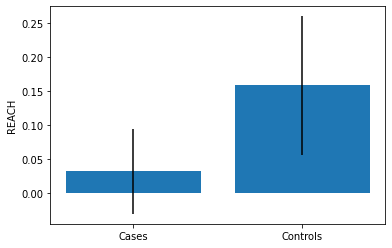

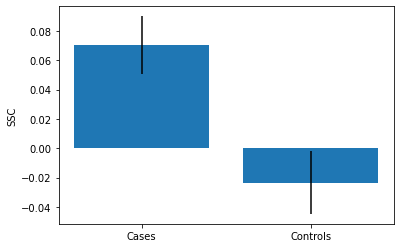

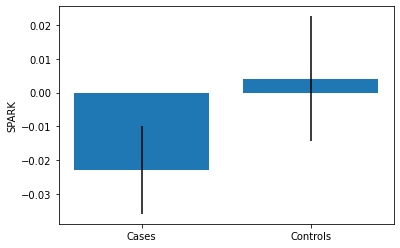

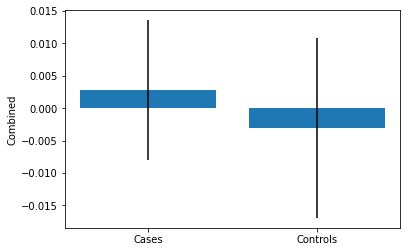

In [ ]:
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)

# Get parental ages
df_mp = pd.read_csv("/content/master_phen_4.SBayesR.csv", sep=",")
df_mp = df_mp[["fid", "iid", "phen", "sex", "cohort",
               "father.age.at.birth.z", "mother.age.at.birth.z"]]
df_mp = df_mp.rename(columns = {"fid": "FID", "iid": "IID", "phen": "Phenotype", "sex": "Sex", "cohort": "Cohort"})
df_mp['Sex'] = df_mp['Sex'].replace({"Male": 0, "Female": 1})
df_mp['Phenotype'] = df_mp['Phenotype'].replace({"CON": 0, "ASD": 1})
df_mp['Cohort'] = df_mp['Cohort'].replace({1: "REACH", 2: "SSC", 3: "SPARK"})

df_dnms_pa_merge = df_dnms_merge.merge(df_mp, on = ["IID", "FID", "Sex", "Phenotype", "Cohort"], how = "left")
# df_dnms_pa_merge[df_dnms_pa_merge["father.age.at.birth.z"].isna()]
# df_dnms_pa_merge[df_dnms_pa_merge["mother.age.at.birth.z"].isna()]
# df_dnms_pa_merge[df_dnms_pa_merge["father.age.at.birth.z"].isna() & df_dnms_pa_merge["mother.age.at.birth.z"].notna()]
# df_dnms_pa_merge[df_dnms_pa_merge["mother.age.at.birth.z"].isna() & df_dnms_pa_merge["father.age.at.birth.z"].notna()]
df_dnms_pa_merge = df_dnms_pa_merge.dropna(subset = ["father.age.at.birth.z"])

df_cas = df_dnms_pa_merge[df_dnms_pa_merge["Phenotype"] == 1]
df_ctl = df_dnms_pa_merge[df_dnms_pa_merge["Phenotype"] == 0]

df_cas_reach = df_cas[df_cas["Cohort"] == "REACH"]
df_cas_ssc   = df_cas[df_cas["Cohort"] == "SSC"]
df_cas_spark = df_cas[df_cas["Cohort"] == "SPARK"]

df_ctl_reach = df_ctl[df_ctl["Cohort"] == "REACH"]
df_ctl_ssc   = df_ctl[df_ctl["Cohort"] == "SSC"]
df_ctl_spark = df_ctl[df_ctl["Cohort"] == "SPARK"]

# col = "father.age.at.birth.z"
# REACH
# print(scipy.stats.ttest_ind(df_cas_reach[col], df_ctl_reach[col]))
# # SSC
# print(scipy.stats.ttest_ind(df_cas_ssc[col], df_ctl_ssc[col]))
# # SPARK
# print(scipy.stats.ttest_ind(df_cas_spark[col], df_ctl_spark[col]))

def plot_bar(df, col, ax, cohort = None):
  df_tmp = df
  if cohort:
    df_tmp = df[df["Cohort"] == cohort]

  df_cas = df_tmp[df_tmp["Phenotype"] == 1]
  df_ctl = df_tmp[df_tmp["Phenotype"] == 0]

  cas_mean = df_cas[col].mean()
  cas_sem = df_cas[col].sem()

  ctl_mean = df_ctl[col].mean()
  ctl_sem = df_ctl[col].sem()

  print(scipy.stats.ttest_ind(df_cas["father.age.at.birth.z"], df_ctl["father.age.at.birth.z"]))

  ax.bar(
    x = ["Cases", "Controls"],
    height = [cas_mean, ctl_mean],
    yerr = [cas_sem, ctl_sem],
    )
  
  if cohort:
    ax.set_ylabel(cohort)
  else:
    ax.set_ylabel("Combined")



f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax, cohort = "REACH")

f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax, cohort = "SSC")

f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax, cohort = "SPARK")

f, ax = plt.subplots(1, 1)
plot_bar(df_dnms_pa_merge, "father.age.at.birth.z", ax)


# All the QC plots

df_dnms_pa_merge = df_dnms_pa_merge.dropna(subset = ["father.age.at.birth.z"])


# LoF, Missense, Synonymous
# Potential confounders?



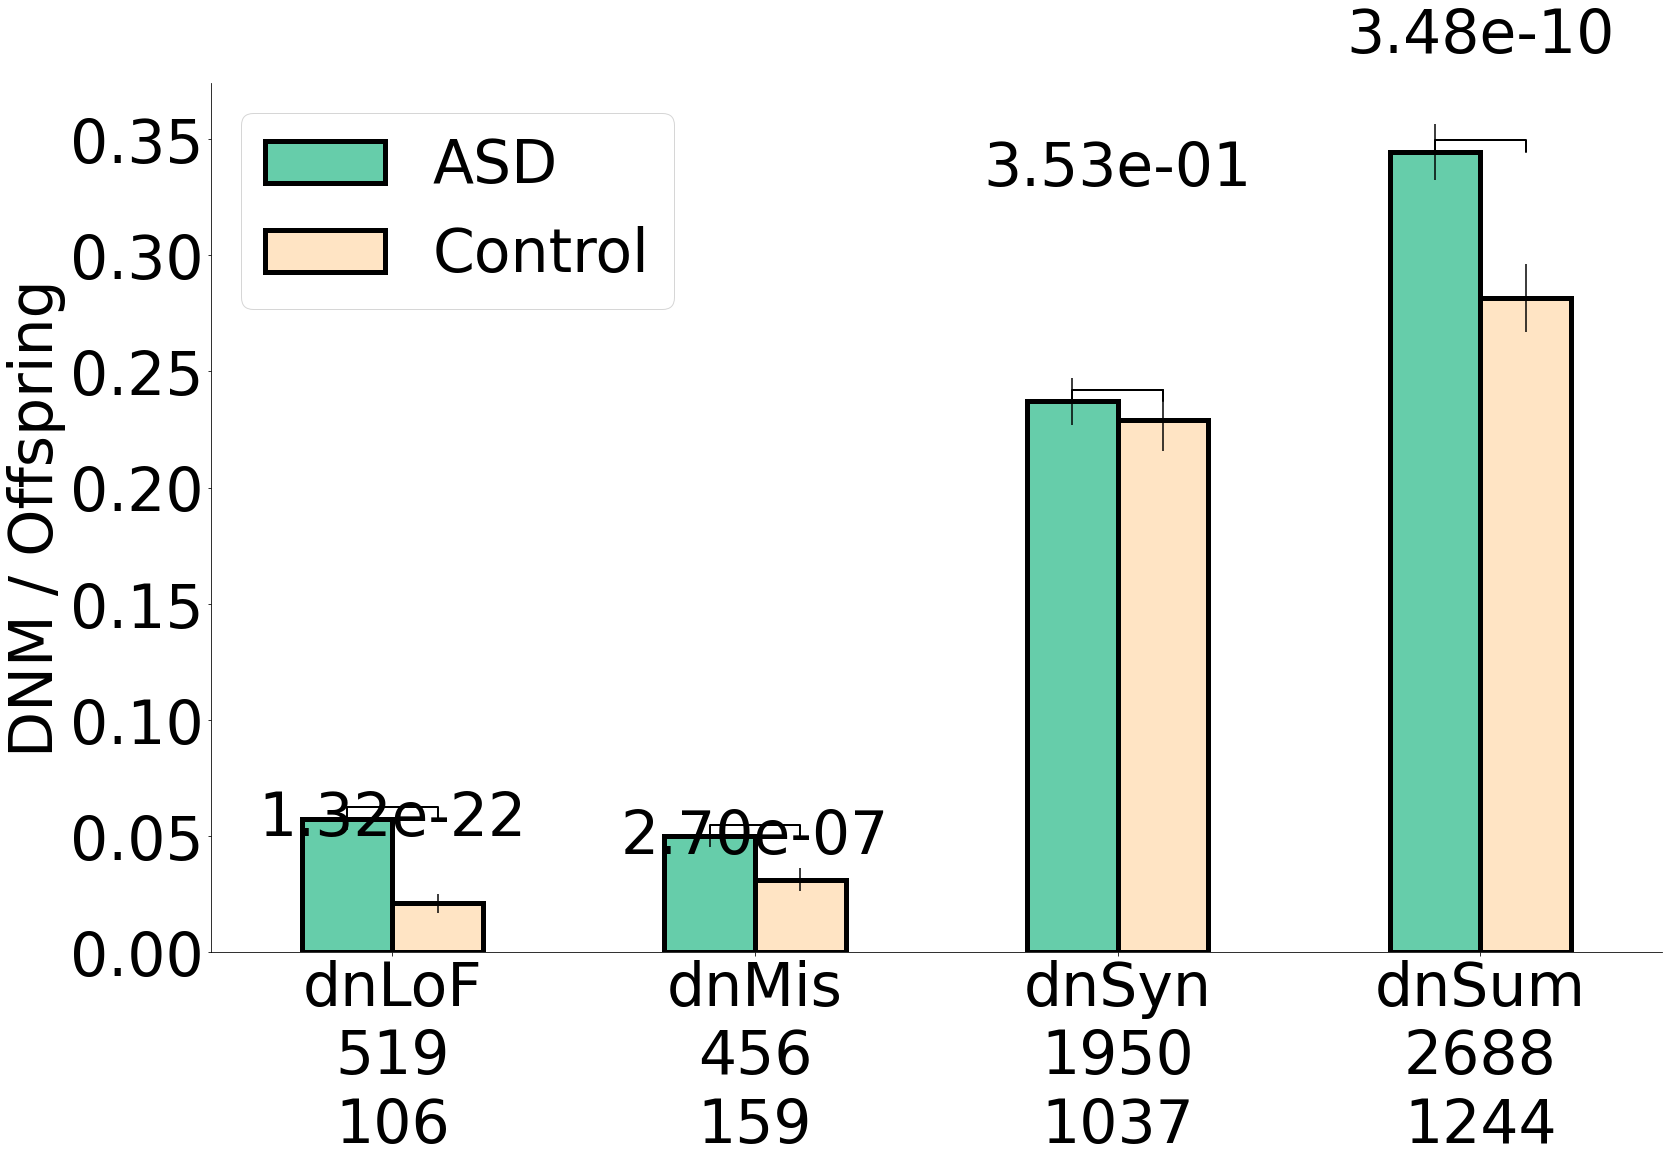

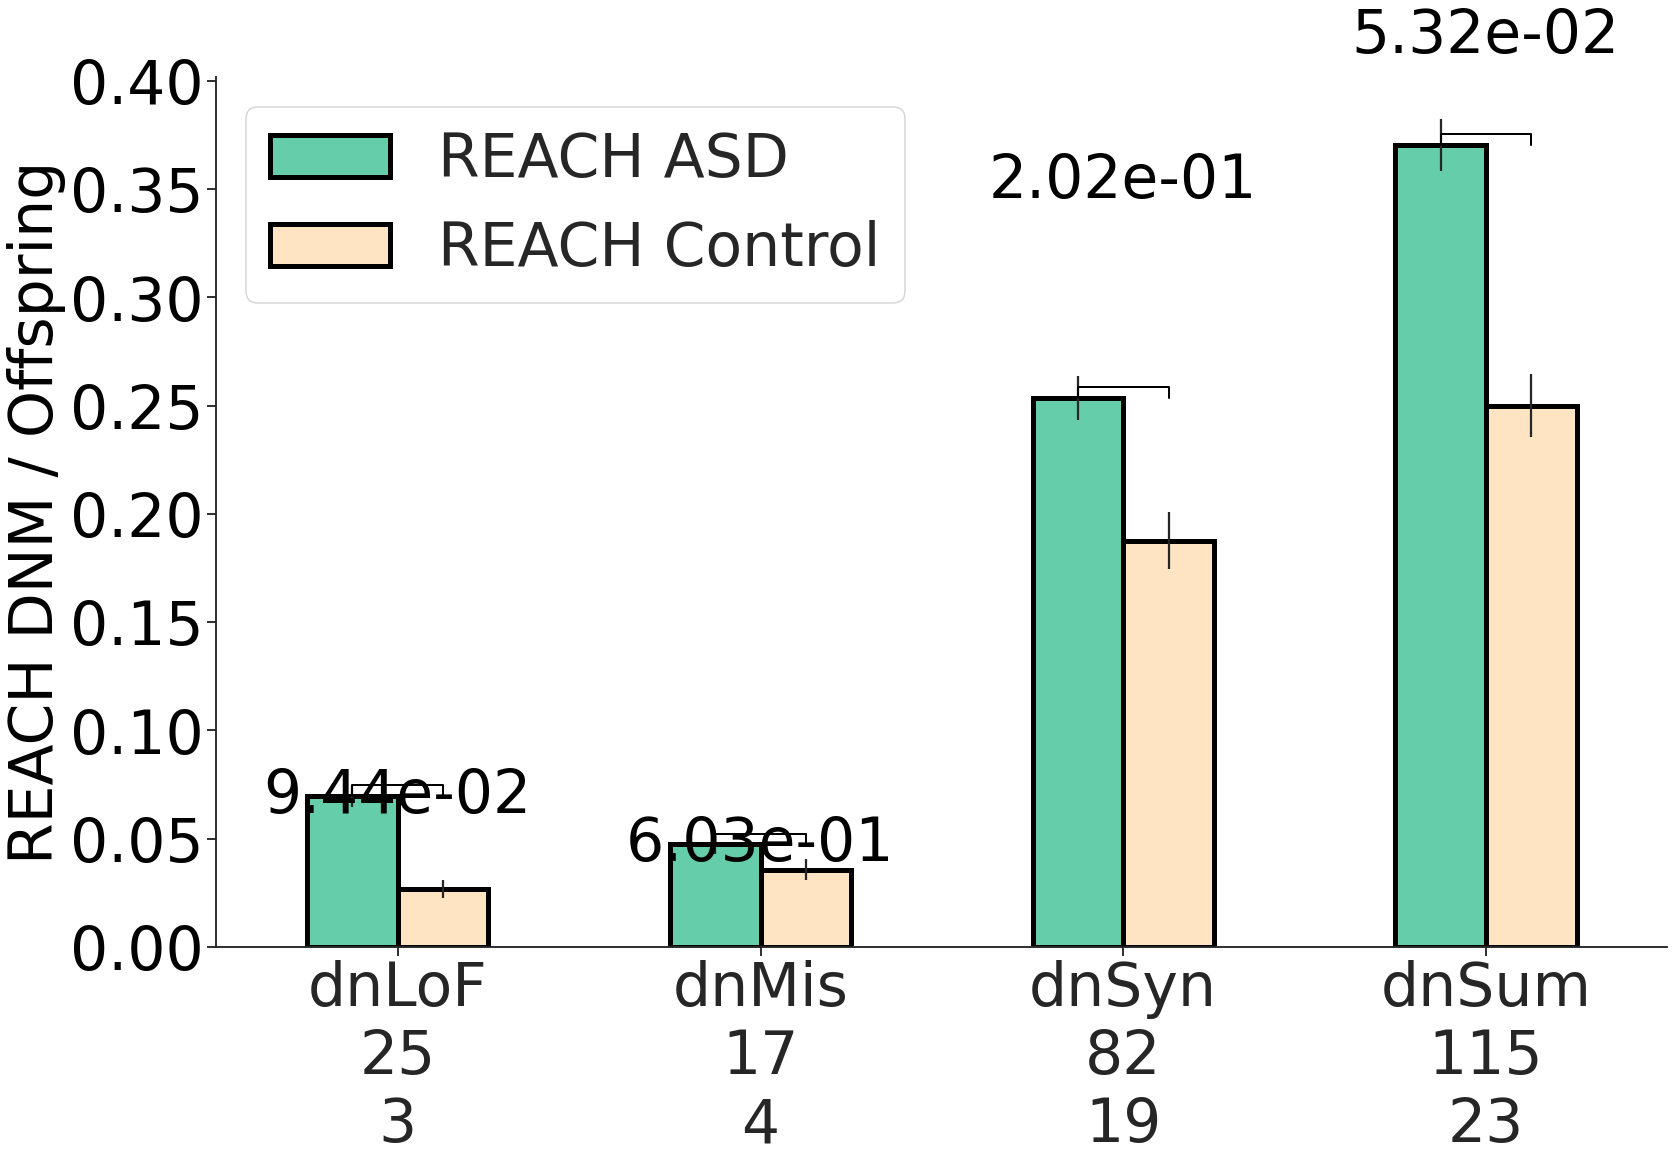

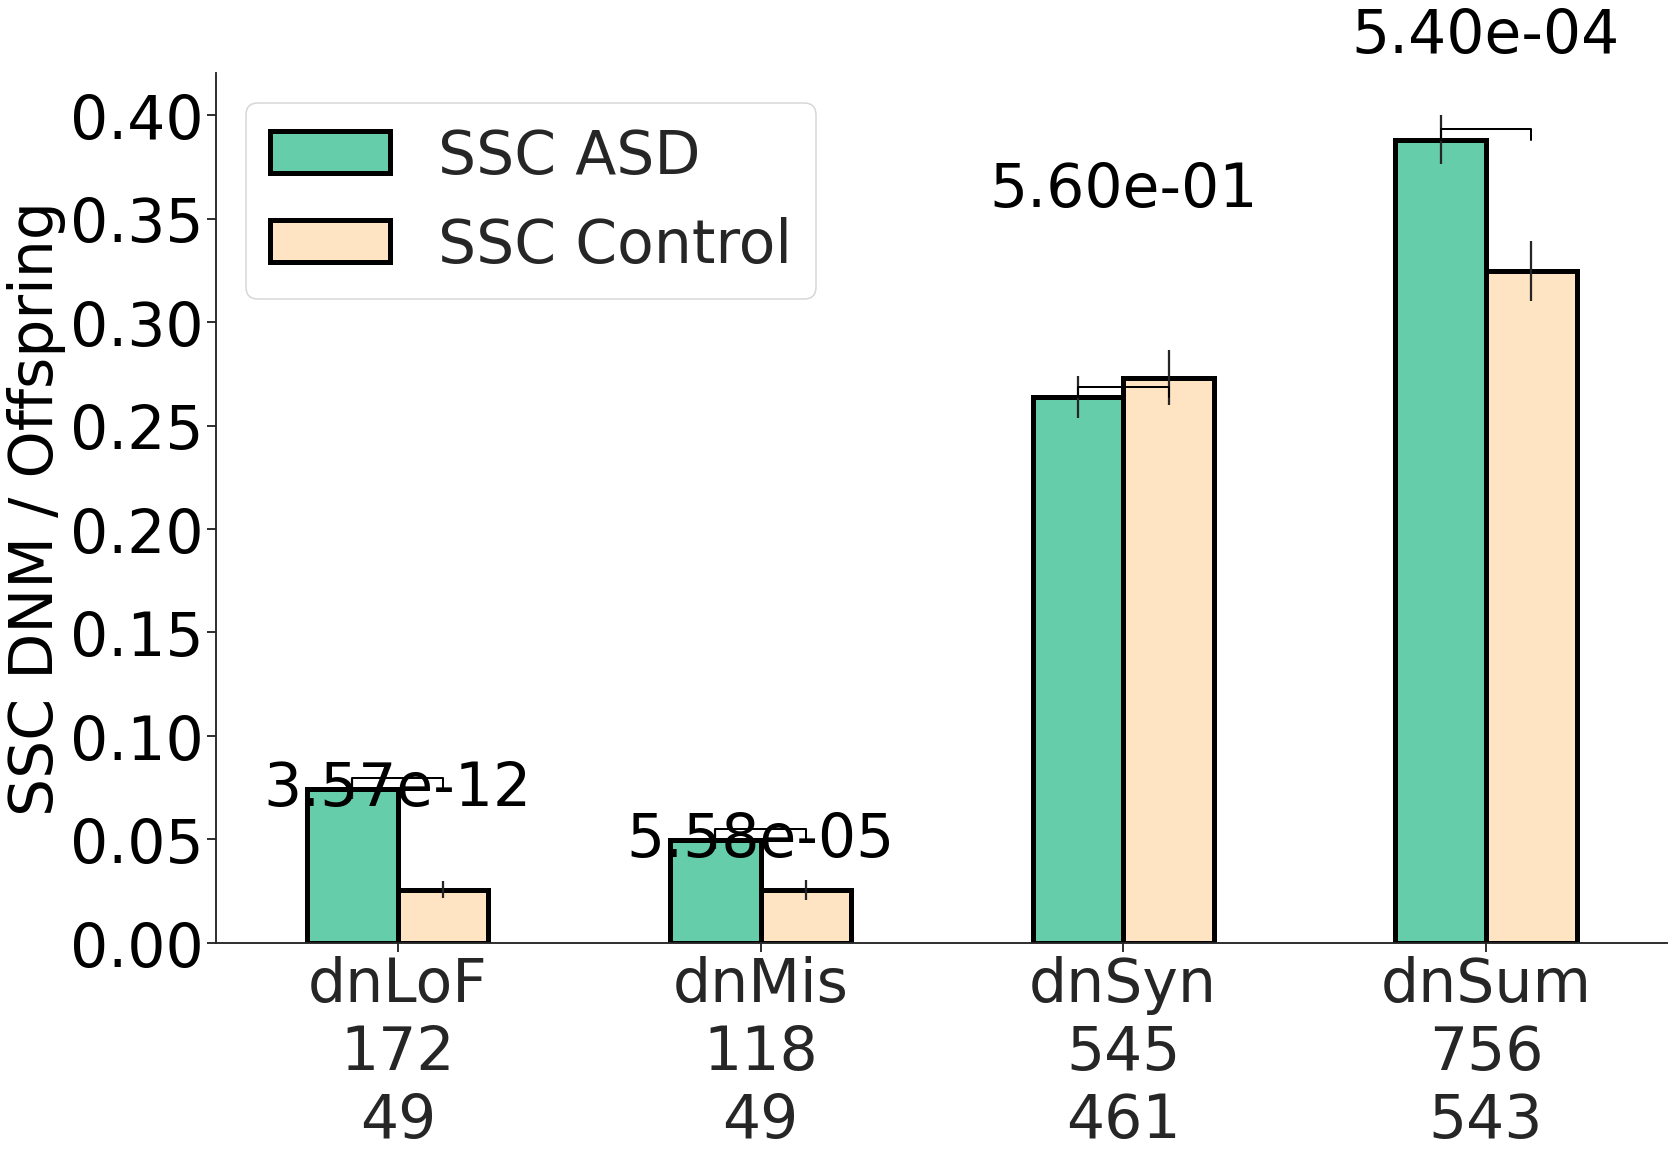

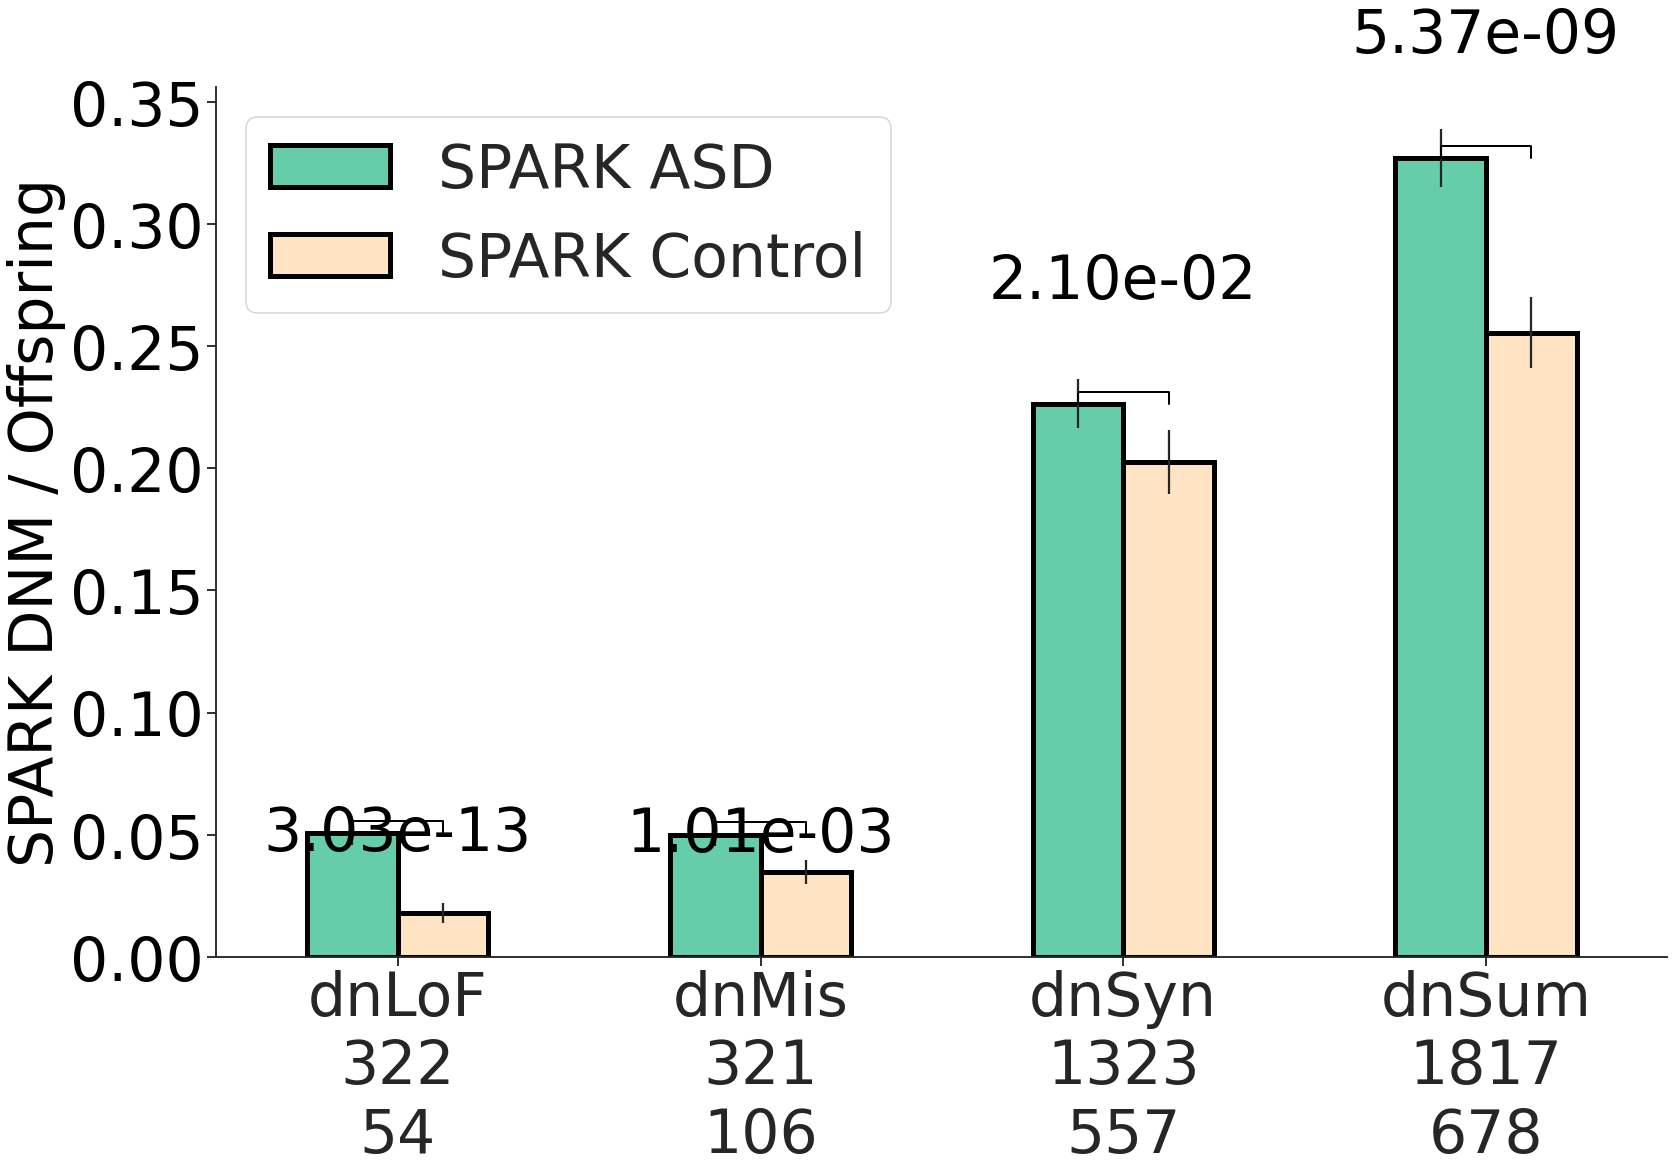

In [ ]:
# dnLoF, dnMis, and dnSyn counts

exclude_iids = ["SSC00428",
"SSC00796",
"SSC12169",
"SSC10120",
"SSC10135",
"SSC06079",
"SSC10085",
"SSC06086",
"SSC12150",
"SSC10090"]

def plot_pvals(ax, index, pval, text_buffer = 0, line_buffer = 0):
  # if pval > 0.05: return
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk =  "***"
  elif pval < 0.01: pval_asterisk =  "**"
  elif pval < 0.05: pval_asterisk =  "*"

  # Properties of the bar
  xy = ax.patches[index].xy
  x_start = xy[0]
  width = ax.patches[index].get_width()
  x_end = x_start + width
  height = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  ax.plot([midpoint, midpoint, midpoint + width, midpoint + width], [height + line_buffer, height + 0.005 + line_buffer, height + 0.005 + line_buffer, height + line_buffer], linewidth = 2, color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")


def make_df(df, col, cohort = None):
  df_tmp = df.dropna(subset = [col])

  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["DNMs", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])


# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]
# Exclude the hypermutators
df = df[~df["IID"].isin(exclude_iids)]

# Get DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)
df_dnms_merge["sum_count"] = df_dnms_merge['lof_count'] + df_dnms_merge['mis_count'] + df_dnms_merge['syn_count']

# Combined cohort
df_lof_count = make_df(df_dnms_merge, "lof_count")
# df_lof_count_original = make_df(df_dnms_merge, "dnLOF")
df_mis_count = make_df(df_dnms_merge, "mis_count")
# df_mis_count_original = make_df(df_dnms_merge, "dnMIS")
df_syn_count = make_df(df_dnms_merge, "syn_count")
# df_2b = pd.concat([df_lof_count, df_lof_count_original, df_mis_count, df_mis_count_original, df_syn_count])
df_sum_count = make_df(df_dnms_merge, "sum_count")
df_2b = pd.concat([df_lof_count, df_mis_count, df_syn_count, df_sum_count])

# Per cohort
df_lof_count_REACH = make_df(df_dnms_merge, "lof_count", "REACH")
# df_lof_count_REACH_original = make_df(df_dnms_merge, "dnLOF", "REACH")
df_mis_count_REACH = make_df(df_dnms_merge, "mis_count", "REACH")
# df_mis_count_REACH_original = make_df(df_dnms_merge, "dnMIS", "REACH")
df_syn_count_REACH = make_df(df_dnms_merge, "syn_count", "REACH")
df_sum_count_REACH = make_df(df_dnms_merge, "sum_count", "REACH")

df_lof_count_SSC = make_df(df_dnms_merge, "lof_count", "SSC")
# df_lof_count_SSC_original = make_df(df_dnms_merge, "dnLOF", "SSC")
df_mis_count_SSC = make_df(df_dnms_merge, "mis_count", "SSC")
# df_mis_count_SSC_original = make_df(df_dnms_merge, "dnMIS", "SSC")
df_syn_count_SSC = make_df(df_dnms_merge, "syn_count", "SSC")
df_sum_count_SSC = make_df(df_dnms_merge, "sum_count", "SSC")

df_lof_count_SPARK = make_df(df_dnms_merge, "lof_count", "SPARK")
# df_lof_count_SPARK_original = make_df(df_dnms_merge, "dnLOF", "SPARK")
df_mis_count_SPARK = make_df(df_dnms_merge, "mis_count", "SPARK")
# df_mis_count_SPARK_original = make_df(df_dnms_merge, "dnMIS", "SPARK")
df_syn_count_SPARK = make_df(df_dnms_merge, "syn_count", "SPARK")
df_sum_count_SPARK = make_df(df_dnms_merge, "sum_count", "SPARK")

# df_2b_cohorts = pd.concat([df_lof_count_REACH, df_lof_count_REACH_original, df_mis_count_REACH, df_mis_count_REACH_original, df_syn_count_REACH,
#                            df_lof_count_SSC, df_lof_count_SSC_original, df_mis_count_SSC, df_mis_count_SSC_original, df_syn_count_SSC,
#                            df_lof_count_SPARK, df_lof_count_SPARK_original, df_mis_count_SPARK, df_mis_count_SPARK_original, df_syn_count_SPARK])
df_2b_cohorts = pd.concat([df_lof_count_REACH, df_mis_count_REACH, df_syn_count_REACH, df_sum_count_REACH,
                           df_lof_count_SSC, df_mis_count_SSC, df_syn_count_SSC, df_sum_count_SSC,
                           df_lof_count_SPARK, df_mis_count_SPARK, df_syn_count_SPARK, df_sum_count_SPARK])


# Plotting
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_2b.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b["ASD Samples"].astype(str) + "\n" + df_2b["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b["P-value"].values[2], text_buffer = 0.1)
plot_pvals(ax, index = 3, pval = df_2b["P-value"].values[3], text_buffer = 0.05)

f.savefig("fig.rebuttal.combined.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.combined.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.combined.pdf", bbox_inches = "tight")


# REACH plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"].plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["REACH ASD", "REACH Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('REACH DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["ASD Samples"].astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[2], text_buffer = 0.1)
plot_pvals(ax, index = 3, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "REACH"]["P-value"].values[3], text_buffer = 0.05)

f.savefig("fig.rebuttal.reach.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.reach.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.reach.pdf", bbox_inches = "tight")


# SSC plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"].plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SSC ASD", "SSC Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('SSC DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["ASD Samples"].astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[2], text_buffer = 0.1)
plot_pvals(ax, index = 3, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SSC"]["P-value"].values[3], text_buffer = 0.05)

f.savefig("fig.rebuttal.ssc.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.ssc.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.ssc.pdf", bbox_inches = "tight")


# SPARK plot
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"].plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_2b[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 2, fontsize = MASSIVE)

ax.set_ylabel('SPARK DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_2b_labels = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["DNMs"].replace({"lof_count": "dnLoF", "mis_count": "dnMis", "syn_count": "dnSyn", "sum_count": "dnSum"}).astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["ASD Samples"].astype(str) + "\n" + df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["Control Samples"].astype(str)
ax.set_xticklabels(df_2b_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[0])
plot_pvals(ax, index = 1, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[1])
plot_pvals(ax, index = 2, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[2], text_buffer = 0.05)
plot_pvals(ax, index = 3, pval = df_2b_cohorts[df_2b_cohorts["Cohort"] == "SPARK"]["P-value"].values[3], text_buffer = 0.05)


f.savefig("fig.rebuttal.spark.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.spark.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.spark.pdf", bbox_inches = "tight")



df_2b.to_csv("df_rebuttal.csv", index = False)
df_2b_cohorts.to_csv("df_rebuttal_cohorts.csv", index = False)

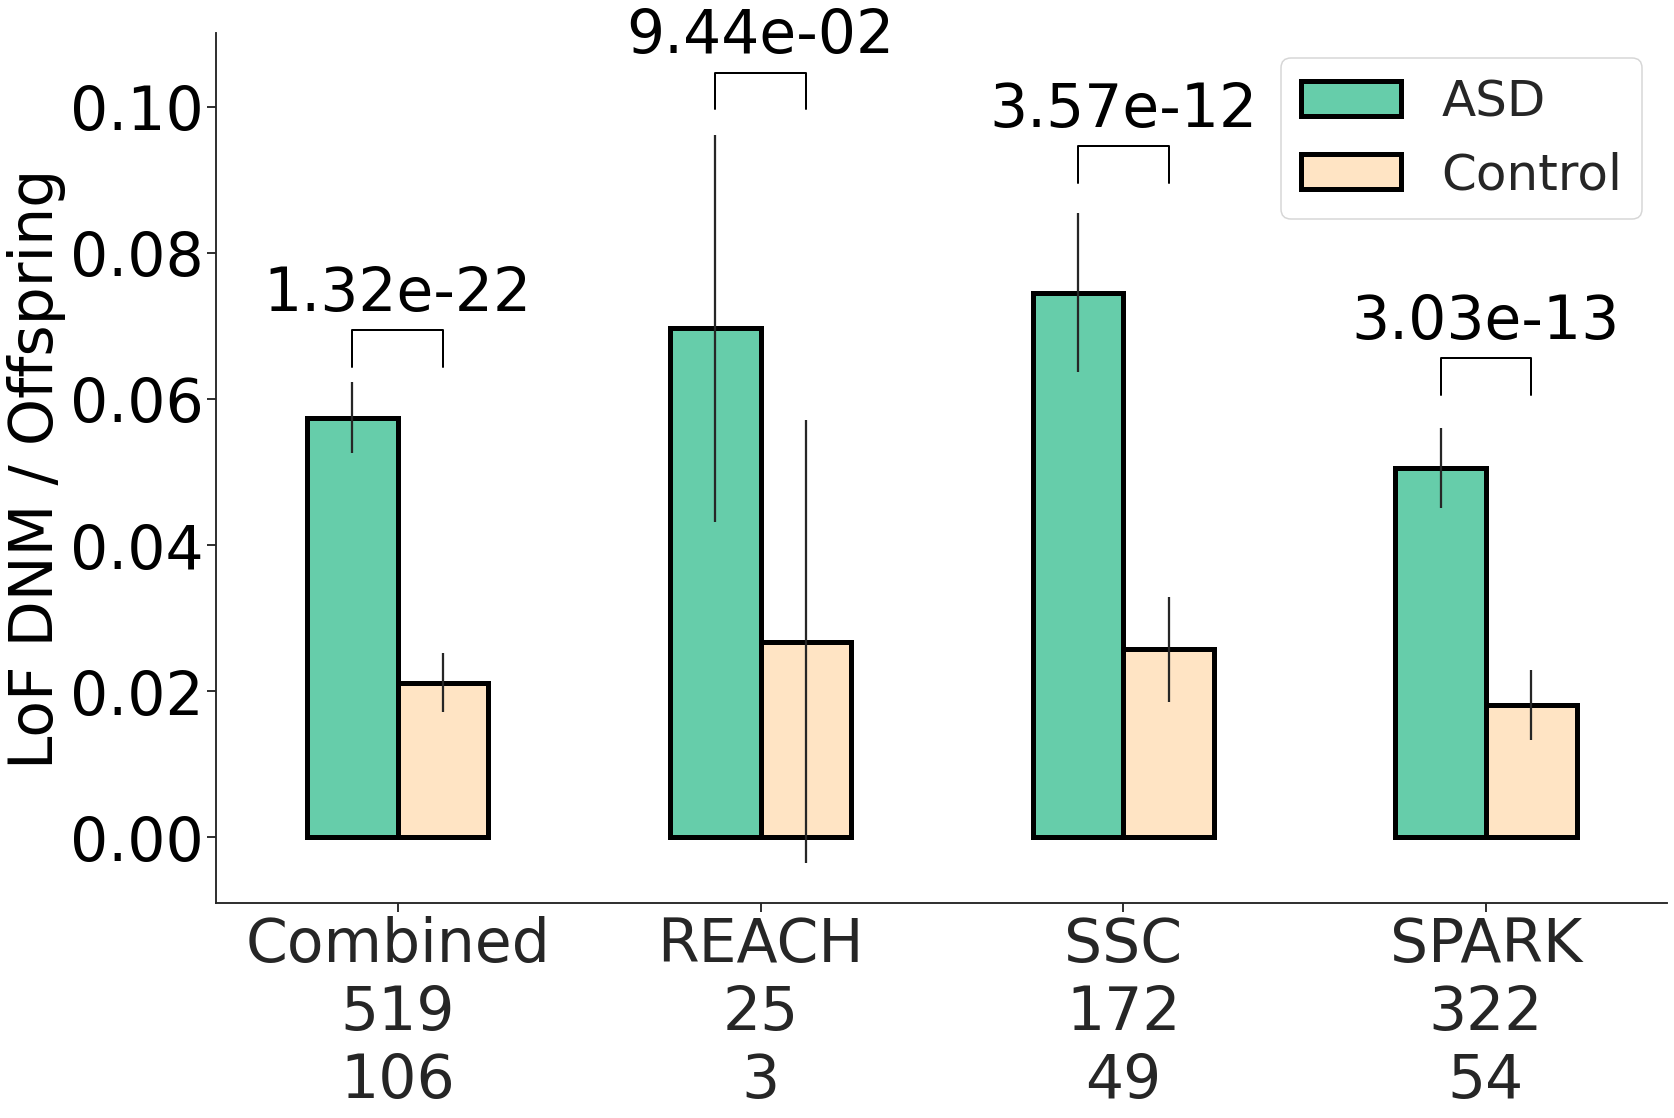

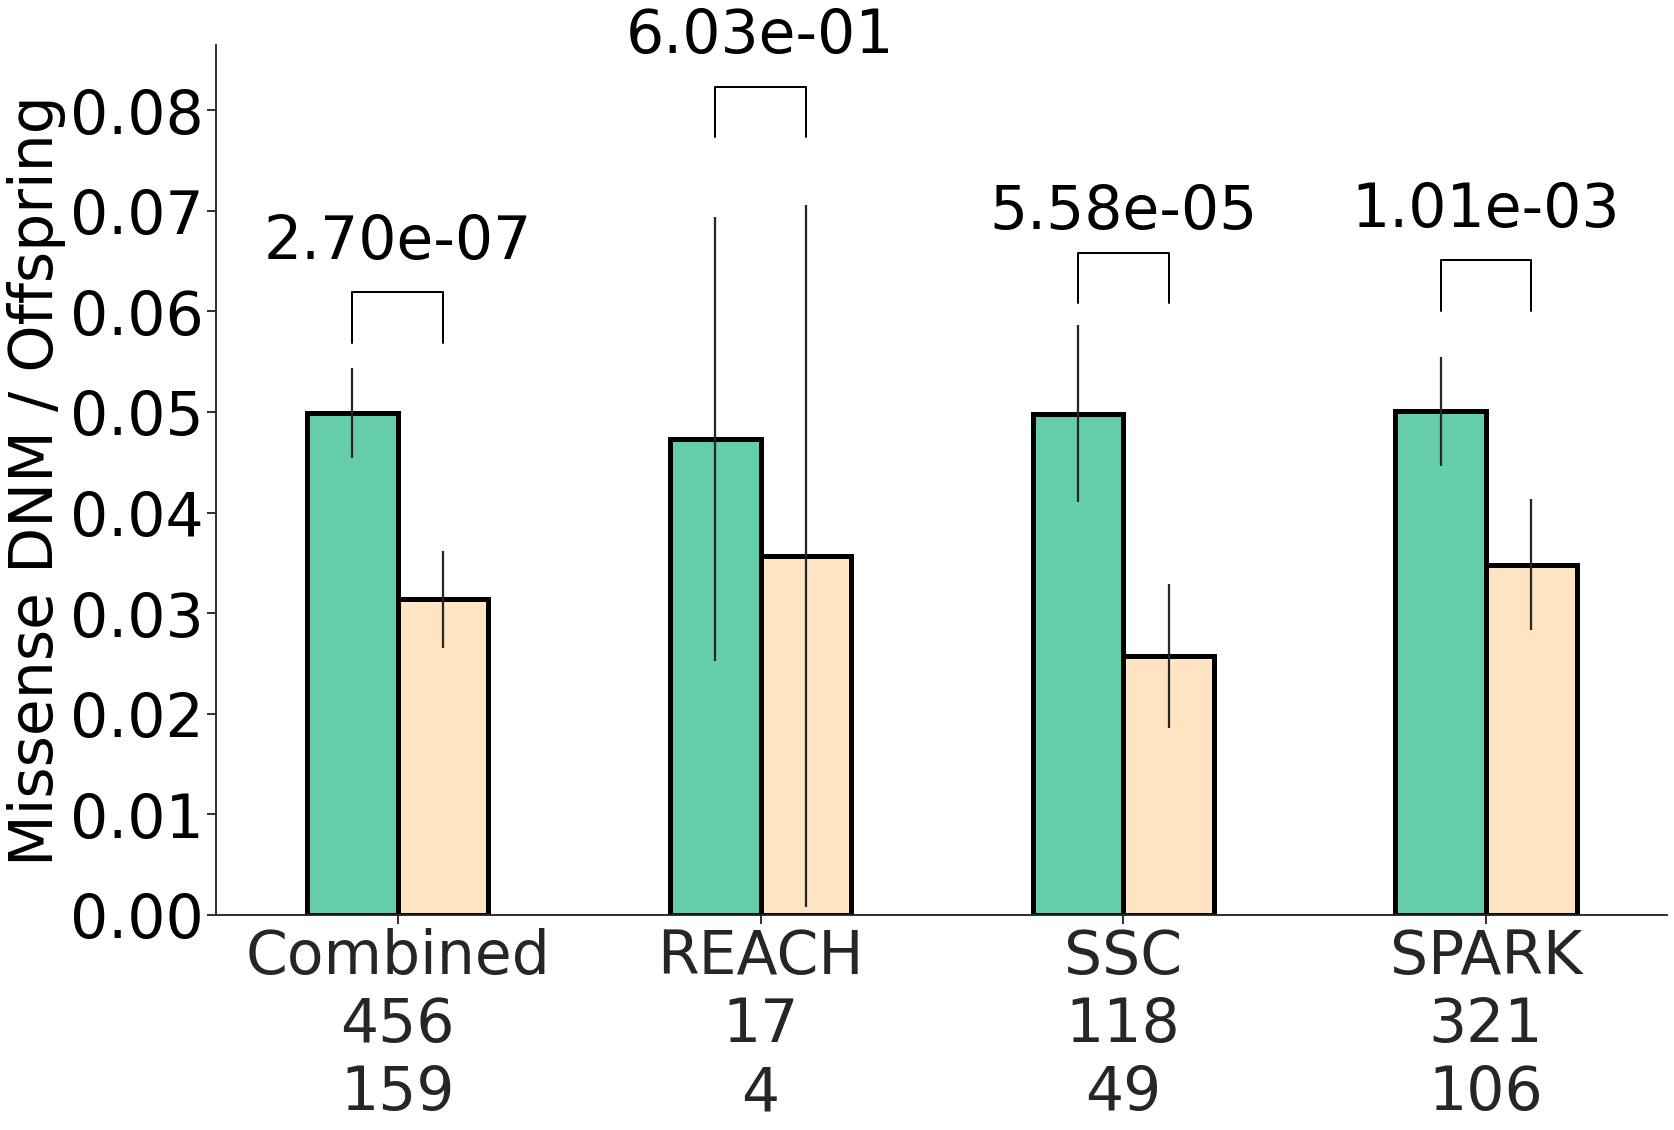

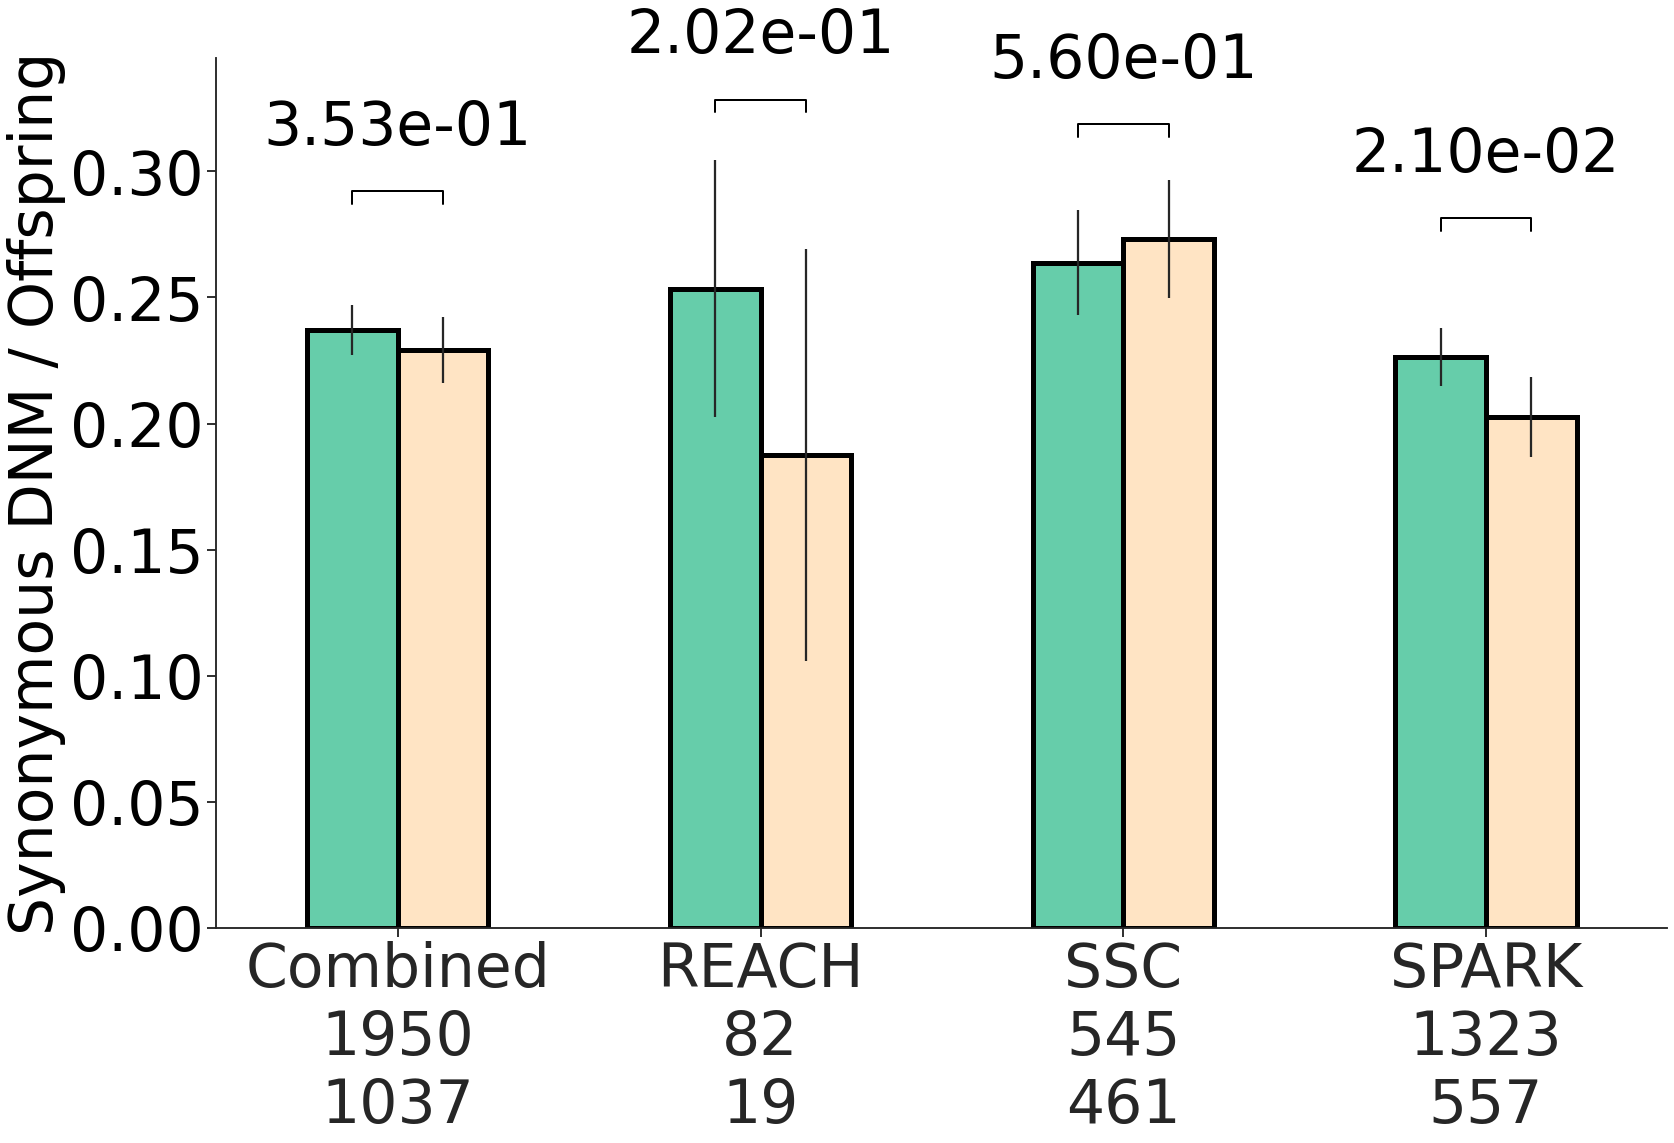

In [ ]:
df_2b["Cohort"] = ["Combined"]*4
df_lof = pd.concat([df_2b[df_2b["DNMs"] == "lof_count"], df_2b_cohorts[df_2b_cohorts["DNMs"] == "lof_count"]])
df_mis = pd.concat([df_2b[df_2b["DNMs"] == "mis_count"], df_2b_cohorts[df_2b_cohorts["DNMs"] == "mis_count"]])
df_syn = pd.concat([df_2b[df_2b["DNMs"] == "syn_count"], df_2b_cohorts[df_2b_cohorts["DNMs"] == "syn_count"]])

# LoF
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_lof.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_lof[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    ax = ax
)

leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('LoF DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_lof_labels = df_lof["Cohort"].astype(str) + "\n" + df_lof["ASD Samples"].astype(str) + "\n" + df_lof["Control Samples"].astype(str)
ax.set_xticklabels(df_lof_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_lof["P-value"].values[0], line_buffer = 0.007, text_buffer = 0.017)
plot_pvals(ax, index = 1, pval = df_lof["P-value"].values[1], line_buffer = 0.030, text_buffer = 0.040)
plot_pvals(ax, index = 2, pval = df_lof["P-value"].values[2], line_buffer = 0.015, text_buffer = 0.025)
plot_pvals(ax, index = 3, pval = df_lof["P-value"].values[3], line_buffer = 0.010, text_buffer = 0.020)

f.savefig("fig.rebuttal.lof.exclude_hypermutators.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.lof.exclude_hypermutators.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.lof.exclude_hypermutators.pdf", bbox_inches = "tight")


# Missense
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_mis.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_mis[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    legend = None,
    ax = ax
)

# leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Missense DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_mis_labels = df_mis["Cohort"].astype(str) + "\n" + df_mis["ASD Samples"].astype(str) + "\n" + df_mis["Control Samples"].astype(str)
ax.set_xticklabels(df_mis_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_mis["P-value"].values[0], line_buffer = 0.007, text_buffer = 0.017)
plot_pvals(ax, index = 1, pval = df_mis["P-value"].values[1], line_buffer = 0.030, text_buffer = 0.040)
plot_pvals(ax, index = 2, pval = df_mis["P-value"].values[2], line_buffer = 0.011, text_buffer = 0.020)
plot_pvals(ax, index = 3, pval = df_mis["P-value"].values[3], line_buffer = 0.010, text_buffer = 0.020)

f.savefig("fig.rebuttal.mis.exclude_hypermutators.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.mis.exclude_hypermutators.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.mis.exclude_hypermutators.pdf", bbox_inches = "tight")


# Synonymous
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_syn.plot.bar(
    x = "DNMs",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_syn[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["ASD", "Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH,
    legend = None,
    ax = ax
)

# leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Synonymous DNM / Offspring', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_syn_labels = df_syn["Cohort"].astype(str) + "\n" + df_syn["ASD Samples"].astype(str) + "\n" + df_syn["Control Samples"].astype(str)
ax.set_xticklabels(df_syn_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_syn["P-value"].values[0], line_buffer = 0.05, text_buffer = 0.08)
plot_pvals(ax, index = 1, pval = df_syn["P-value"].values[1], line_buffer = 0.07, text_buffer = 0.10)
plot_pvals(ax, index = 2, pval = df_syn["P-value"].values[2], line_buffer = 0.05, text_buffer = 0.08)
plot_pvals(ax, index = 3, pval = df_syn["P-value"].values[3], line_buffer = 0.05, text_buffer = 0.08)

f.savefig("fig.rebuttal.syn.exclude_hypermutators.png", bbox_inches = "tight")
f.savefig("fig.rebuttal.syn.exclude_hypermutators.svg", bbox_inches = "tight")
f.savefig("fig.rebuttal.syn.exclude_hypermutators.pdf", bbox_inches = "tight")

In [ ]:
# Rebuttal supplementary table
df_dnms = pd.concat([df_lof, df_mis, df_syn])
df_dnms = df_dnms[["Cohort", "DNMs", 
                   "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", 
                   "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations",
                   "P-value"]]
df_dnms["DNMs"] = df_dnms["DNMs"].replace({
    "lof_count": "dnLoF",
    "mis_count": "dnMis",
    "syn_count": "dnSyn",
})

df_dnms.to_csv("SupplementaryTable2.dnms.rebuttal.csv", index = False)

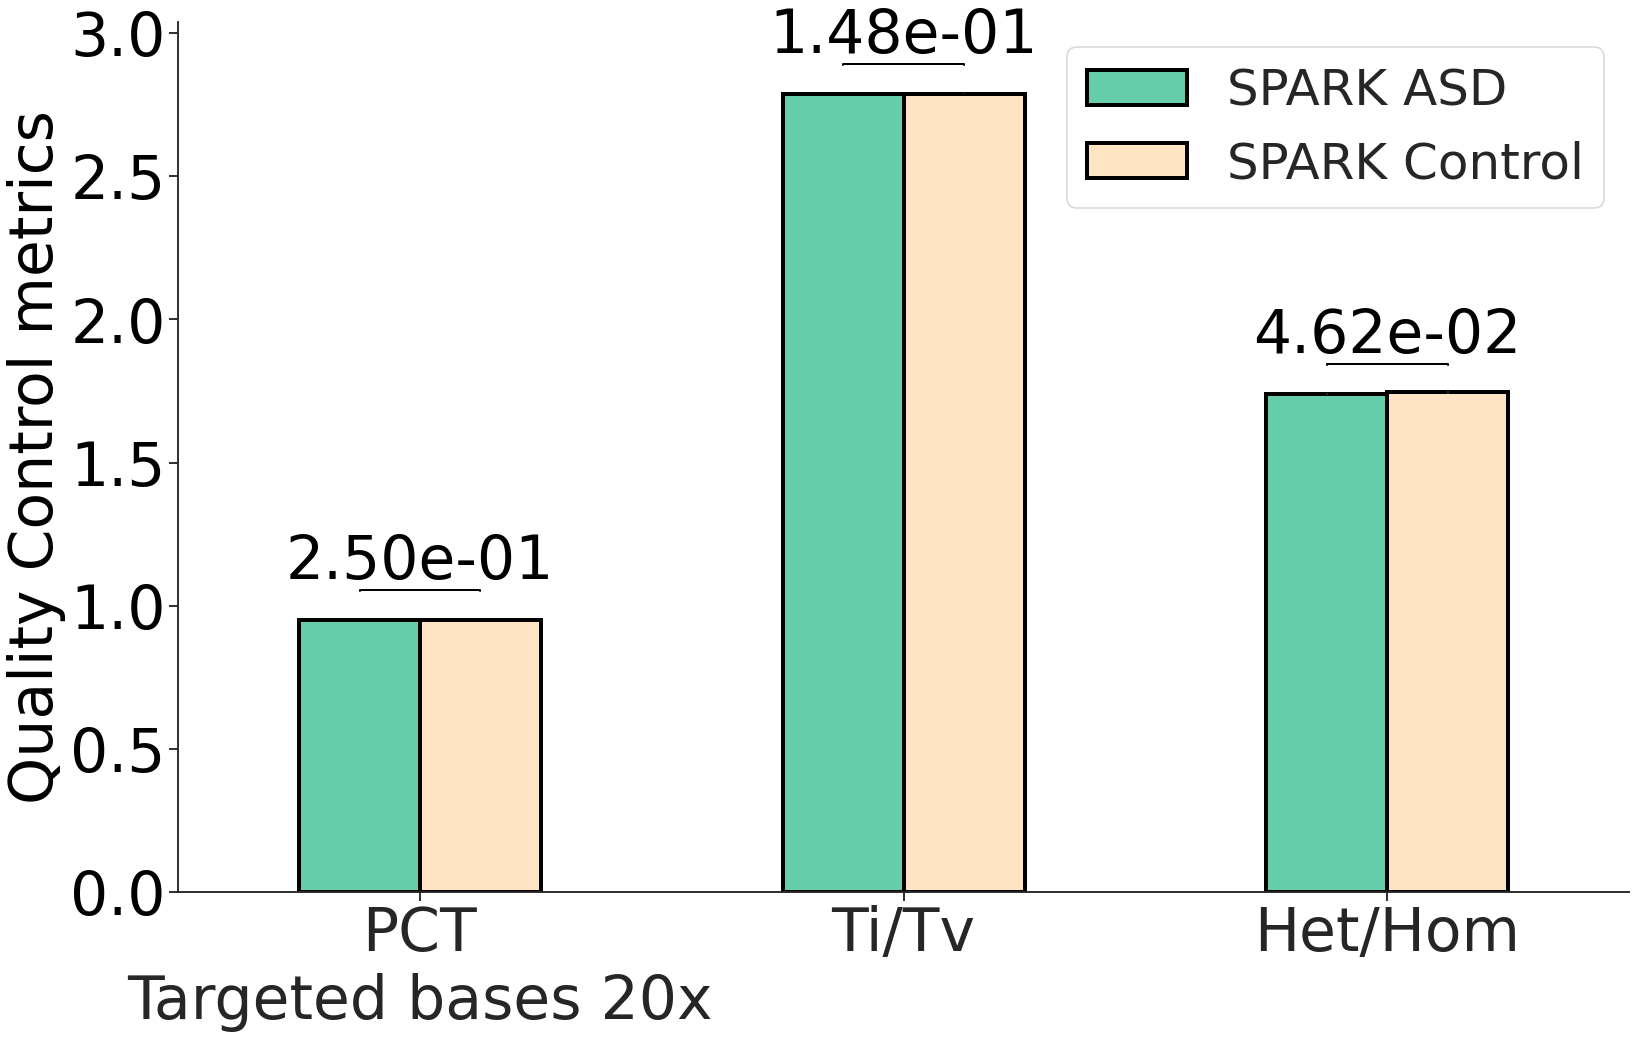

In [ ]:
# SPARK quality control metrics
def plot_pvals(ax, index, pval, text_buffer = 0, line_buffer = 0):
  # if pval > 0.05: return
  pval_asterisk = ""
  if pval < 0.001:  pval_asterisk =  "***"
  elif pval < 0.01: pval_asterisk =  "**"
  elif pval < 0.05: pval_asterisk =  "*"

  # Properties of the bar
  xy = ax.patches[index].xy
  x_start = xy[0]
  width = ax.patches[index].get_width()
  x_end = x_start + width
  height = ax.patches[index].get_height()
  midpoint = (x_start + x_end)*0.5

  ax.plot([midpoint, midpoint, midpoint + width, midpoint + width], [height + line_buffer, height + 0.005 + line_buffer, height + 0.005 + line_buffer, height + line_buffer], linewidth = 2, color = "black")
  ax.text(x = x_end, y = height + text_buffer, s = "{:.2e}".format(pval), ha = "center", va = "center", fontsize = MASSIVE, color = "black")


def make_df(df, col, cohort = "SPARK"):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])
  # Frequency
  cas_freq = cas_sum/cas.shape[0]
  ctl_freq = ctl_sum/ctl.shape[0]

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["Cohort", "QC_Metric", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])
  
  return pd.DataFrame([[col, cas_mean, cas_ci, num_cas, cas_sum, cas_freq, ctl_mean, ctl_ci, num_ctl, ctl_sum, ctl_freq, p_val]], columns = ["QC_Metric", "ASD Mean", "ASD 95% CI", "ASD Samples", "ASD Mutations", "ASD Frequency", "Control Mean", "Control 95% CI", "Control Samples", "Control Mutations", "Control Frequency", "P-value"])

# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]

# Get SPARK DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['dnLoF_Iossifov'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['dnMis_Iossifov'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['dnSyn_Iossifov'] = df_dnms_merge['syn_count'].fillna(value = 0)

# We're only looking at SPARK DNMs for this part of the analysis
df_spark_dnms = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]

# Get quality control metrics for SPARK
df_spark_info = pd.read_csv("df.spark_info.csv")
df_spark_info['Sex'] = df_spark_info['Sex'].replace({1: 0, 2: 1})
df_spark_info['Phenotype'] = df_spark_info['Phenotype'].replace({1: 0, 2: 1})

# Merge df_spark_info (quality control metrics) with the merged dataframe
df_spark_dnms_info = df_spark_dnms.merge(df_spark_info, on = ["IID", "FID", "Phenotype", "Sex"])

# Get parental ages
df_mp = pd.read_csv("/content/master_phen_4.SBayesR.csv", sep=",")
df_mp = df_mp[["fid", "iid", "phen", "sex", "cohort", "father.age.at.birth.z", "mother.age.at.birth.z"]]
df_mp = df_mp.rename(columns = {"fid": "FID", "iid": "IID", "phen": "Phenotype", "sex": "Sex", "cohort": "Cohort"})
df_mp['Sex'] = df_mp['Sex'].replace({"Male": 0, "Female": 1})
df_mp['Phenotype'] = df_mp['Phenotype'].replace({"CON": 0, "ASD": 1})
df_mp['Cohort'] = df_mp['Cohort'].replace({1: "REACH", 2: "SSC", 3: "SPARK"})

# Merge df_mp (containing parental ages at birth of child) with merged dataframe
df_spark_dnms_info = df_spark_dnms_info.merge(df_mp, on = ["IID", "FID", "Phenotype", "Cohort"])

# Make dataframes for each of the quality control metrics
df_spark_pct = make_df(df_spark_dnms_info, col = "PCT_Targeted_bases_20x")
df_spark_ti_tv = make_df(df_spark_dnms_info, col = "ti_tv")
df_spark_het_hom_ratio = make_df(df_spark_dnms_info, col = "het_hom_ratio")
df_spark_father_age_at_birth = make_df(df_spark_dnms_info, col = "father.age.at.birth.z")

# Concatenate the quality control metric dataframes
df_spark_qc = pd.concat([df_spark_pct, df_spark_ti_tv, df_spark_het_hom_ratio])

# Plotting
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_spark_qc.plot.bar(
    x = "QC_Metric",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_spark_qc[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    ax = ax
)

leg = ax.legend(loc = 1, fontsize = MASSIVE - 10)

ax.set_ylabel('Quality Control metrics', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_spark_qc_labels = ["PCT\nTargeted bases 20x", "Ti/Tv", "Het/Hom"]
ax.set_xticklabels(df_spark_qc_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

plot_pvals(ax, index = 0, pval = df_spark_qc["P-value"].values[0], line_buffer = 0.10, text_buffer = 0.20)
plot_pvals(ax, index = 1, pval = df_spark_qc["P-value"].values[1], line_buffer = 0.10, text_buffer = 0.20)
plot_pvals(ax, index = 2, pval = df_spark_qc["P-value"].values[2], line_buffer = 0.10, text_buffer = 0.20)


f.savefig("rebuttal.spark.qc.png", bbox_inches = "tight")
f.savefig("rebuttal.spark.qc.svg", bbox_inches = "tight")
f.savefig("rebuttal.spark.qc.pdf", bbox_inches = "tight")


In [ ]:
# Correlate dnSyn and Het/Hom
scipy.stats.pearsonr(df_spark_dnms_info['dnSyn_Iossifov'], df_spark_dnms_info['het_hom_ratio'])

(-0.010860566115926382, 0.2869242816537576)

In [ ]:
# Supplementary table 6 (Figure 4B genetic correlation results)
df = pd.read_csv("/content/asd_genetic_correlations_by_sex_final.SBayesR.20210715.tsv", sep = "\t")
df = df.rename(columns = {"y": "Y",
                          "x": "X",
                          "male_est": "Male Estimate",
                          "male_pval": "Male P-value",
                          "male_r2": "Male r2",
                          "male_cor": "Male Correlation",
                          "female_est": "Female Estimate",
                          "female_pval": "Female P-value",
                          "female_r2": "Female r2",
                          "female_cor": "Female Correlation",
                          "combined_est": "Combined Estimate",
                          "combined_pval": "Combined P-value",
                          "combined_r2": "Combined r2",
                          "combined_cor": "Combined Correlation",
                          "sex_interaction_pval": "Gene by Sex Interaction P-value"}
               )
# Filter df for only statistically significant results
df_filtered = df[(df["Male P-value"] <= 0.05) | (df["Female P-value"] <= 0.05) | (df["Combined P-value"] <= 0.05) | (df["Gene by Sex Interaction P-value"] <= 0.05)]

df.to_csv("SupplementaryTable6.full.csv", index = False)
df_filtered.to_csv("SupplementaryTable6.statsig.csv", index = False)


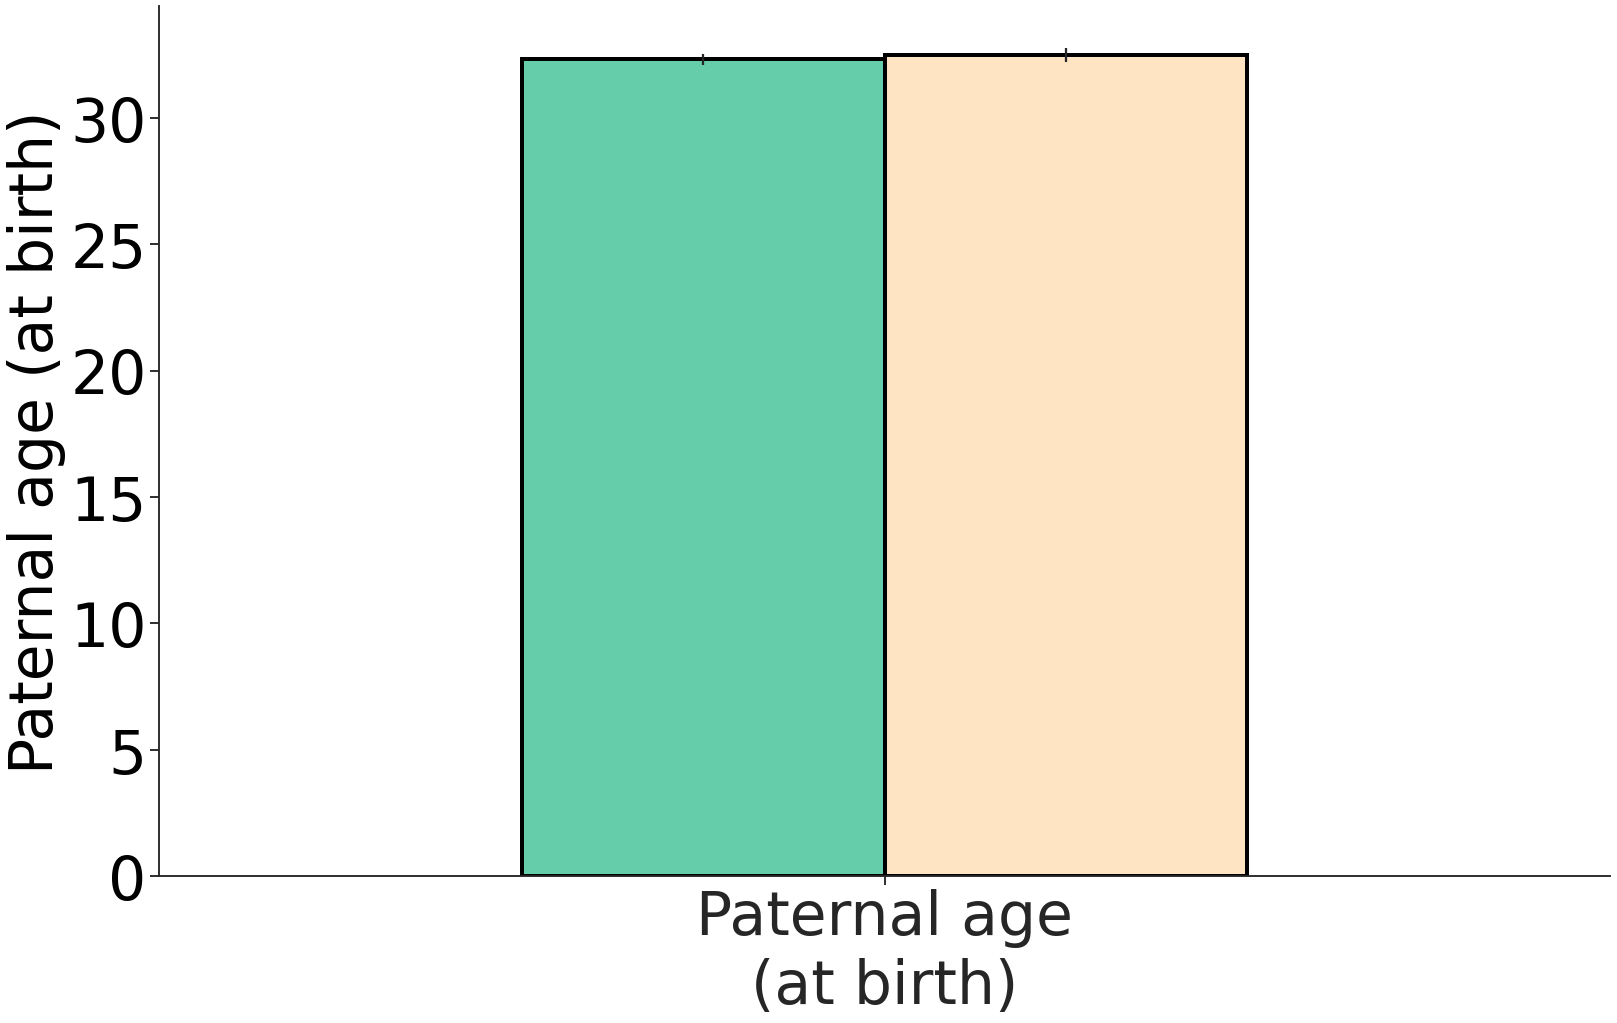

In [ ]:
def make_df(df, col, cohort = "SPARK"):
  df_tmp = df.dropna(subset = [col])
  if cohort:
    df_tmp = df_tmp[df_tmp["Cohort"] == cohort]

  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = ctl[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0])
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0])

  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]
  if cohort:
    return pd.DataFrame([[cohort, col, cas_mean, cas_ci, ctl_mean, ctl_ci, p_val]], columns = ["Cohort", "QC_Metric", "ASD Mean", "ASD 95% CI", "Control Mean", "Control 95% CI", "P-value"])

  return pd.DataFrame([[col, cas_mean, cas_ci, ctl_mean, ctl_ci, p_val]], columns = ["QC_Metric", "ASD Mean", "ASD 95% CI", "Control Mean", "Control 95% CI", "P-value"])



# Get summary data table
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.csv", sep=",")
df = df[["FID", "IID", "Phenotype", "Sex", "Cohort", "Family Type", "Cases in Family", "EUR Ancestry", "dnMIS", "dnLOF"]]
df = df[df["Family Type"] == "trio"]
# Exclude the hypermutators
df = df[~df["IID"].isin(exclude_iids)]

# Get DNMs (after filtering and intersecting with Iossifov's exonic region)
# df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.tsv", sep = "\t")
df_filtered_dnms = pd.read_csv("/content/df_filtered_dnms.iossifov.tsv", sep = "\t")

# Merge df (summary data table) with df_filtered_dnms (DNM counts per type)
df_dnms_merge = df.merge(df_filtered_dnms, on = ["IID", "Sex", "Phenotype", "Cohort"], how = "left")
# Fill NAs with zeros (they are 0 for dnLOF and dnMIS)
df_dnms_merge['lof_count'] = df_dnms_merge['lof_count'].fillna(value = 0)
df_dnms_merge['mis_count'] = df_dnms_merge['mis_count'].fillna(value = 0)
df_dnms_merge['syn_count'] = df_dnms_merge['syn_count'].fillna(value = 0)

# Get parental ages
df_pa = pd.read_csv("/content/parental_ages_reach_ssc_spark.csv")
df_pa = df_pa[["IID", "Father_IID", "Mother_IID", "FATHER_AGE", "MOTHER_AGE", "cohort"]]
df_pa = df_pa.rename(columns = {"cohort": "Cohort"})

# Merge
df_dnms_merge = df_dnms_merge.merge(df_pa, on = ["IID", "Cohort"])

# Split by cohort
df_dnms_reach = df_dnms_merge[df_dnms_merge["Cohort"] == "REACH"]
df_dnms_spark = df_dnms_merge[df_dnms_merge["Cohort"] == "SPARK"]
df_dnms_ssc   = df_dnms_merge[df_dnms_merge["Cohort"] == "SSC"]

# Make dataframes for fathers' ages
df_reach_father_age_at_birth = make_df(df_dnms_reach, col = "FATHER_AGE", cohort = "REACH")
df_spark_father_age_at_birth = make_df(df_dnms_spark, col = "FATHER_AGE", cohort = "SPARK")
df_ssc_father_age_at_birth   = make_df(df_dnms_ssc,   col = "FATHER_AGE", cohort = "SSC")


# Plotting
f, ax = plt.subplots(1, 1, figsize = FIGSIZE_DEFAULT)

colors = ['mediumaquamarine', 'bisque']
width = 0.5
df_spark_father_age_at_birth.plot.bar(
    x = "QC_Metric",
    y = ["ASD Mean", "Control Mean"],
    yerr = df_spark_father_age_at_birth[["ASD 95% CI", "Control 95% CI"]].values.T,
    label = ["SPARK ASD", "SPARK Control"],
    color = colors,
    edgecolor = "k",
    width = width,
    linewidth = LINEWIDTH - 1,
    legend = None,
    ax = ax
)

ax.set_ylabel('Paternal age (at birth)', color = "black", fontsize = MASSIVE)
ax.set_xlabel('')
df_spark_father_age_at_birth_labels = ["Paternal age\n(at birth)"]
ax.set_xticklabels(df_spark_father_age_at_birth_labels, rotation = 0, fontsize = MASSIVE)

plt.yticks(fontsize = MASSIVE, color = "black")

sns.set_context('talk')
sns.set_style('ticks')
sns.despine(ax = ax)

f.savefig("rebuttal.spark.paternal_age.png", bbox_inches = "tight")
f.savefig("rebuttal.spark.paternal_age.svg", bbox_inches = "tight")
f.savefig("rebuttal.spark.paternal_age.pdf", bbox_inches = "tight")

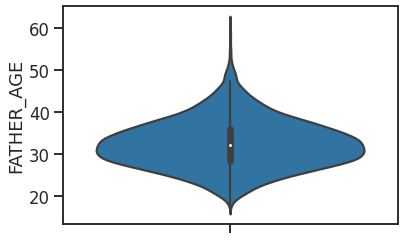

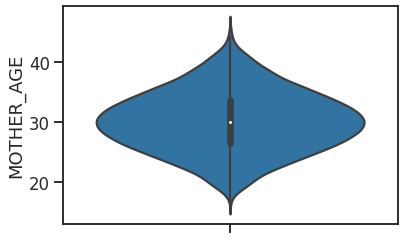

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

df_dnms_spark[["FID", "IID", "FATHER_AGE", "MOTHER_AGE"]]

f, ax = plt.subplots(1, 1)
ax = sns.violinplot(y = "FATHER_AGE", data = df_dnms_spark)
f, ax = plt.subplots(1, 1)
ax = sns.violinplot(y = "MOTHER_AGE", data = df_dnms_spark)